In [ ]:
import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F
import numpy.linalg as npl

#from utils import *
import warnings
warnings.filterwarnings('ignore')
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.nn.functional import relu
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PairwiseDistance 
import torch.nn as nn
import torch.fft
from torch_topological.nn import SummaryStatisticLoss
from torch_topological.nn import VietorisRipsComplex
from tqdm import tqdm
import torch
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform

def rotation_matrix(theta, degrees=True, **kwargs) -> np.ndarray:
    """
    Creates a 2D rotation matrix for theta
    Parameters
    ----------
    theta : float
        angle offset wrt. the cardinal x-axis
    degrees : boolean
        Whether to use degrees or radians
    Returns
    -------
    rotmat : np.ndarray
        the 2x2 rotation matrix
    Examples
    --------
    >>> import numpy as np
    >>> x = np.ones(2) / np.sqrt(2)
    >>> rotmat = rotation_matrix(45)
    >>> tmp = rotmat @ x
    >>> eps = 1e-8
    >>> np.sum(np.abs(tmp - np.array([0., 1.]))) < eps
    True
    """
    # convert to radians
    theta = theta * np.pi / 180 if degrees else theta
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c, -s), (s, c)))

torch.autograd.set_detect_anomaly(True)
class GridPhases(torch.nn.Module):
    def __init__(self, N, pos, maxdim, batch_size, ks, non_negative, init_phases, seed=42):
        super(GridPhases, self).__init__()
        self.pos = pos
        torch.manual_seed(seed)
        self.N = N
        if init_phases == 'normal':
            self.phases = torch.nn.Parameter(
              torch.randn(N, 2)/10 +torch.tensor((0.5, 0.5)),
              requires_grad=True)
        elif init_phases == 'uniform':
            self.phases = torch.nn.Parameter(
              torch.rand(N, 2),
              requires_grad=True)

        self.ks = ks
        self.num_times = len(pos)
        self.batch_size = batch_size
        self.non_negative = non_negative
        
        
    def forward(self): 
        activity = torch.zeros(self.batch_size, self.N)

        for i in range(self.batch_size):
            activity[i,:] = torch.sum(torch.cos(torch.matmul((self.pos[i, :] - self.phases), 
                                                                  self.ks.T)), axis=-1)
            
        if self.non_negative:
            activity = torch.relu(activity)
#        else:
#            activity = 2 * (activity / 3 + 0.5) / 3       
        return activity

class OptimPhase:
    def __init__(
            self,
            pos,  # time steps x 2 
            ks,
            non_negative = True,
            N = 100, # numer neurons
            maxdim=2,  # optimize the first signature[1] H_signature[0]s
            batch_size= 16,
            epochs=3,
            train_steps=10,  # per epoch
            lr=1e-2,
            seed=47,
            verbose=True,  # whether to print and plot intermediate statistics
            device="cpu",
            num_worse=3,
            init_phases = 'uniform',
            bTranspose = False,
            score = 'top'
            # how many epochs loss may get worse before stopping
    ):
        # Parameters
        self.maxdim = maxdim
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_steps = train_steps
        self.lr = lr
        self.seed = seed
        self.verbose = verbose
        self.num_worse = num_worse
        self.num_times = len(pos)
        self.bTranspose = bTranspose
        self.pdist = nn.PairwiseDistance(p=2)
        
        # Setup Data, Model, Optimizer
        self.rips = VietorisRipsComplex(dim=maxdim).to(device)        
        self.model = GridPhases(N, pos, maxdim, batch_size, ks, non_negative, init_phases).to(device)
        if lr>0:
            self.optimizer = torch.optim.Adam([self.model.phases])
        else:
            self.optimizer = torch.optim.Adam([self.model.phases], lr=lr)            
        #self.optimizer = torch.optim.Adam([self.model.phases])
        self.score = score
        
        #torch.random.manual_seed(self.seed + i)
        #batch_ind = torch.randperm(self.num_times)[:self.batch_size]
        self.batch_ind = torch.linspace(0,self.num_times-1,self.batch_size, dtype = int)

    def train(self):
        worse = 0  # counter for early stopping
        running_loss = 0.0
        running_loss_top = 0.0
        running_loss_rest = 0.0
        run_loss, run_bars = [], []
        t0 = time.time()
        self.stats = {'phases': [], 'loss': []}
        
        for i in range(self.epochs * self.train_steps + 1):
            # training step
            self.optimizer.zero_grad()
            out = self.model()
            if self.bTranspose:
                out1 = 1-torch.corrcoef(out.T)
            else:
                out1 = self.pdist(out[None, :], out[:, None])
            layer_out = self.rips(out1, treat_as_distances = True)
            lives0 = torch.sort(layer_out[0][1][1:,1] - layer_out[0][1][1:,0], descending = True)
            lives1 = torch.sort(layer_out[1][1][:,1] - layer_out[1][1][:,0], descending = True)
            lives11 = torch.concatenate((lives1[0], torch.zeros(3)))
            if self.maxdim>1:
                lives2 = torch.sort(layer_out[2][1][:,1] - layer_out[2][1][:,0], descending = True)     
                lives22 = torch.concatenate((lives2[0], torch.zeros(2)))

            else:
                lives2, lives22 = [0, 0], [0,0]                
            if self.score == 'top':
                loss_top = (lives11[1]-lives11[2] + lives22[0]-lives22[1])
                loss_rest = 0                
            elif self.score == 'sum':
                loss_top = (torch.sum(lives11[:2]) + 
                            torch.sum(lives22[:1]))
                loss_rest = (torch.sum(lives11[2:])/len(lives11[2:]) + 
                             torch.sum(lives22[1:])/len(lives22[1:]))
            loss = loss_rest-loss_top
            print(loss)
            self.stats['loss'].append(loss.item())
            self.stats['phases'].append(torch.tensor(self.model.phases))
            loss.backward()
            if self.lr > 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.lr)
            self.optimizer.step()
            # logging
            print('')
            
            if i > -1 and not (i % self.train_steps):
                if self.maxdim>1:
                    maxlife = torch.max(torch.concatenate((lives0[0], lives1[0], lives2[0])))
                    maxbirth = torch.max(torch.concatenate((layer_out[0][1][1:,0], 
                                                           layer_out[1][1][:,0],
                                                           layer_out[2][1][:,0])))
                else:
                    maxlife = torch.max(torch.concatenate((lives0[0], lives1[0])))
                    maxbirth = torch.max(torch.concatenate((layer_out[0][1][1:,0], 
                                                           layer_out[1][1][:,0])))
                plt.figure()
                plt.plot([0,0], [0,maxlife.detach().numpy()], c = 'k', zorder = -1)
                plt.plot([0,maxbirth.detach().numpy()], [0,0], c = 'k', zorder = -1)
                plt.scatter(layer_out[0][1][1:,0][lives0[1]].detach().numpy(), lives0[0].detach().numpy())
                plt.scatter(layer_out[1][1][:,0][lives1[1]].detach().numpy(), lives1[0].detach().numpy())
                if self.maxdim>1:
                    plt.scatter(layer_out[2][1][:,0][lives2[1]].detach().numpy(), lives2[0].detach().numpy())
                
                log = 'run=%s, time=%.2fs' % (i, time.time() - t0)
                print(log)
                fig, ax = plt.subplots(1,1)
                ax.scatter(*self.stats['phases'][np.argmin(self.stats['loss'])].T%1)
                ax.set_xlim([0,1])
                ax.set_ylim([0,1])
                ax.set_aspect('equal', 'box')
                
                plt.figure()
                plt.plot(self.stats['loss'])
                # early stopping
                ii = int(i/self.train_steps)
                if ii>0:
                    mincurrtrain = np.min(self.stats['loss'][(ii-1)*self.train_steps:ii*self.train_steps]) 
                    mincurr = np.min(self.stats['loss'])
                    log = 'min=%.2f and mincurr%.2f' % (mincurr, mincurrtrain)
                    print(log)
                    if mincurrtrain > mincurr:
                        worse += 1
                        
                        if worse > self.num_worse:
                            print('Early stopping at iteration', i)
                            break
                plt.show()
                print('')
        print('Training finished.')



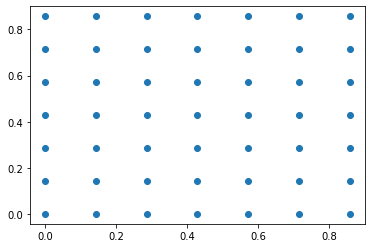

In [24]:
orientation_offset=0
f=1
rot_hex=60
n_comps_hex=3
non_negative=True
add=True
a = 1
relative_R_hex = rotation_matrix(rot_hex)
init_R = rotation_matrix(orientation_offset)

k1 = np.array([1.0, 0.0])  # init wave vector. unit length in x-direction
k1 = init_R @ k1

ks_hex = np.array([npl.matrix_power(relative_R_hex, k) @ k1 for k in range(n_comps_hex)])* 2 * np.pi*f
ks_hex = ks_hex * 2 / (a*np.sqrt(3)) # user-defined spatial frequency
#ks_hex = torch.tensor(ks_hex, dtype = torch.float)  # spatial angular frequency (unit-movement in space is one period)
ks_hex = torch.from_numpy(ks_hex)


rot_sqr=90
n_comps_sqr=2
relative_R_sqr = rotation_matrix(rot_sqr)
ks_sqr = np.array([npl.matrix_power(relative_R_sqr, k) @ k1 for k in range(n_comps_sqr)])
ks_sqr *= 2 * np.pi  # spatial angular frequency (unit-movement in space is one period)
ks_sqr *= f  # user-defined spatial frequency
ks_sqr = torch.from_numpy(ks_sqr)


xymesh = torch.meshgrid((torch.linspace(0,1,8, dtype=float)[:-1],torch.linspace(0,1,8, dtype=float)[:-1]))
xx = xymesh[0].flatten()
yy = xymesh[1].flatten()

pos1 = torch.zeros(49,2, dtype=float)
pos1[:,0] = xx #+ torch.rand(64, dtype = float)*0.05
pos1[:,1] = yy #+ torch.rand(64, dtype = float)*0.05

plt.scatter(pos1[:,0], pos1[:,1])

## Square grid cell

 ### score = Top

#### Init_phase = Normal

##### 4 neurons

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 4,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.0,
              init_phases = 'normal',
              bTranspose = False
            )
print(time.time()-t0)
model1.train()

In [ ]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 4 neurons, lr 0.01

0.005074501037597656
tensor(-0.3779, grad_fn=<RsubBackward1>)

run=0, time=1.41s


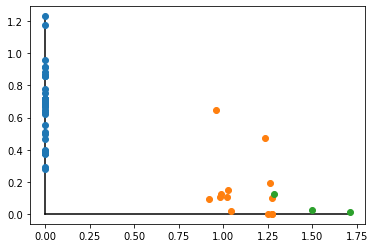

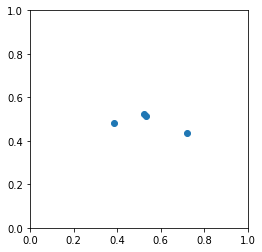

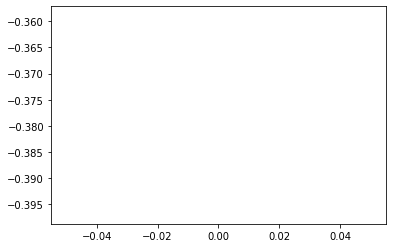


tensor(-0.3909, grad_fn=<RsubBackward1>)

tensor(-0.1875, grad_fn=<RsubBackward1>)

tensor(-0.1712, grad_fn=<RsubBackward1>)

tensor(-0.2018, grad_fn=<RsubBackward1>)

tensor(-0.3078, grad_fn=<RsubBackward1>)

tensor(-0.3000, grad_fn=<RsubBackward1>)

tensor(-0.4054, grad_fn=<RsubBackward1>)

tensor(-0.3166, grad_fn=<RsubBackward1>)

tensor(-0.3482, grad_fn=<RsubBackward1>)

tensor(-0.3492, grad_fn=<RsubBackward1>)

tensor(-0.3956, grad_fn=<RsubBackward1>)

tensor(-0.4036, grad_fn=<RsubBackward1>)

tensor(-0.3879, grad_fn=<RsubBackward1>)

tensor(-0.3777, grad_fn=<RsubBackward1>)

tensor(-0.3812, grad_fn=<RsubBackward1>)

tensor(-0.3815, grad_fn=<RsubBackward1>)

tensor(-0.4117, grad_fn=<RsubBackward1>)

tensor(-0.3712, grad_fn=<RsubBackward1>)

tensor(-0.3540, grad_fn=<RsubBackward1>)

tensor(-0.3822, grad_fn=<RsubBackward1>)

tensor(-0.4225, grad_fn=<RsubBackward1>)

tensor(-0.3257, grad_fn=<RsubBackward1>)

tensor(-0.3135, grad_fn=<RsubBackward1>)

tensor(-0.3932, grad_fn=<RsubBack

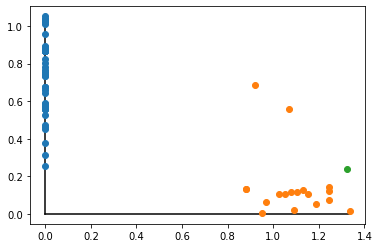

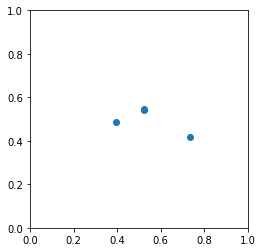

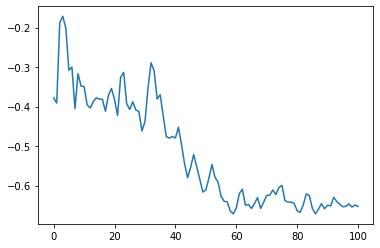


tensor(-0.6698, grad_fn=<RsubBackward1>)

tensor(-0.6702, grad_fn=<RsubBackward1>)

tensor(-0.6561, grad_fn=<RsubBackward1>)

tensor(-0.6487, grad_fn=<RsubBackward1>)

tensor(-0.6422, grad_fn=<RsubBackward1>)

tensor(-0.6336, grad_fn=<RsubBackward1>)

tensor(-0.6464, grad_fn=<RsubBackward1>)

tensor(-0.6649, grad_fn=<RsubBackward1>)

tensor(-0.6325, grad_fn=<RsubBackward1>)

tensor(-0.6160, grad_fn=<RsubBackward1>)

tensor(-0.6213, grad_fn=<RsubBackward1>)

tensor(-0.6632, grad_fn=<RsubBackward1>)

tensor(-0.5902, grad_fn=<RsubBackward1>)

tensor(-0.5639, grad_fn=<RsubBackward1>)

tensor(-0.5951, grad_fn=<RsubBackward1>)

tensor(-0.6026, grad_fn=<RsubBackward1>)

tensor(-0.6201, grad_fn=<RsubBackward1>)

tensor(-0.6083, grad_fn=<RsubBackward1>)

tensor(-0.6059, grad_fn=<RsubBackward1>)

tensor(-0.6339, grad_fn=<RsubBackward1>)

tensor(-0.6488, grad_fn=<RsubBackward1>)

tensor(-0.6262, grad_fn=<RsubBackward1>)

tensor(-0.6131, grad_fn=<RsubBackward1>)

tensor(-0.6389, grad_fn=<RsubBack

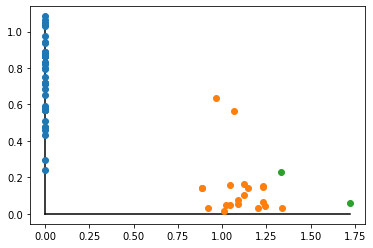

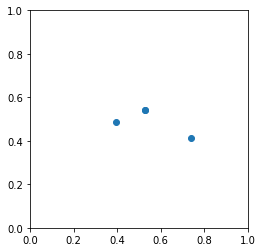

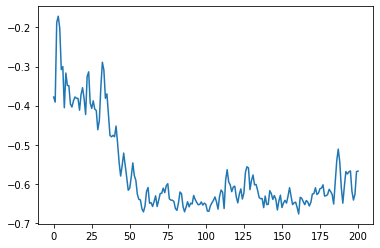


tensor(-0.6156, grad_fn=<RsubBackward1>)

tensor(-0.6109, grad_fn=<RsubBackward1>)

tensor(-0.6141, grad_fn=<RsubBackward1>)

tensor(-0.6082, grad_fn=<RsubBackward1>)

tensor(-0.5727, grad_fn=<RsubBackward1>)

tensor(-0.5753, grad_fn=<RsubBackward1>)

tensor(-0.5668, grad_fn=<RsubBackward1>)

tensor(-0.5655, grad_fn=<RsubBackward1>)

tensor(-0.5975, grad_fn=<RsubBackward1>)

tensor(-0.6194, grad_fn=<RsubBackward1>)

tensor(-0.6132, grad_fn=<RsubBackward1>)

tensor(-0.5858, grad_fn=<RsubBackward1>)

tensor(-0.5855, grad_fn=<RsubBackward1>)

tensor(-0.6009, grad_fn=<RsubBackward1>)

tensor(-0.6156, grad_fn=<RsubBackward1>)

tensor(-0.6371, grad_fn=<RsubBackward1>)

tensor(-0.6348, grad_fn=<RsubBackward1>)

tensor(-0.6345, grad_fn=<RsubBackward1>)

tensor(-0.6362, grad_fn=<RsubBackward1>)

tensor(-0.6421, grad_fn=<RsubBackward1>)

tensor(-0.6491, grad_fn=<RsubBackward1>)

tensor(-0.6602, grad_fn=<RsubBackward1>)

tensor(-0.5964, grad_fn=<RsubBackward1>)

tensor(-0.5818, grad_fn=<RsubBack

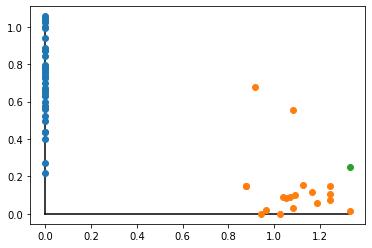

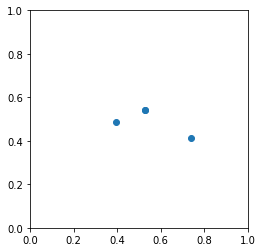

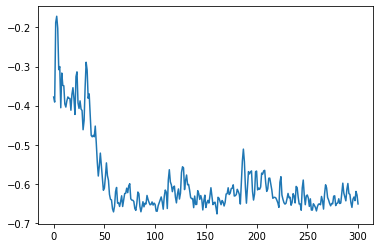


tensor(-0.6477, grad_fn=<RsubBackward1>)

tensor(-0.6619, grad_fn=<RsubBackward1>)

tensor(-0.6409, grad_fn=<RsubBackward1>)

tensor(-0.6256, grad_fn=<RsubBackward1>)

tensor(-0.6368, grad_fn=<RsubBackward1>)

tensor(-0.6620, grad_fn=<RsubBackward1>)

tensor(-0.6359, grad_fn=<RsubBackward1>)

tensor(-0.6456, grad_fn=<RsubBackward1>)

tensor(-0.6452, grad_fn=<RsubBackward1>)

tensor(-0.6508, grad_fn=<RsubBackward1>)

tensor(-0.6315, grad_fn=<RsubBackward1>)

tensor(-0.6048, grad_fn=<RsubBackward1>)

tensor(-0.6197, grad_fn=<RsubBackward1>)

tensor(-0.6365, grad_fn=<RsubBackward1>)

tensor(-0.6557, grad_fn=<RsubBackward1>)

tensor(-0.6693, grad_fn=<RsubBackward1>)

tensor(-0.6608, grad_fn=<RsubBackward1>)

tensor(-0.6526, grad_fn=<RsubBackward1>)

tensor(-0.6477, grad_fn=<RsubBackward1>)

tensor(-0.6193, grad_fn=<RsubBackward1>)

tensor(-0.5833, grad_fn=<RsubBackward1>)

tensor(-0.6243, grad_fn=<RsubBackward1>)

tensor(-0.6391, grad_fn=<RsubBackward1>)

tensor(-0.6257, grad_fn=<RsubBack

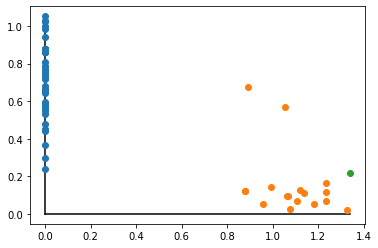

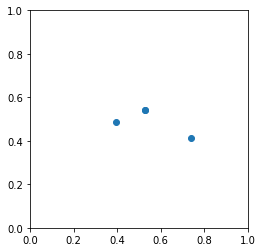

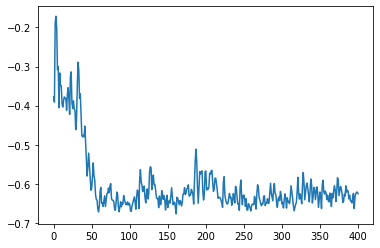


tensor(-0.6239, grad_fn=<RsubBackward1>)

tensor(-0.6455, grad_fn=<RsubBackward1>)

tensor(-0.6491, grad_fn=<RsubBackward1>)

tensor(-0.6004, grad_fn=<RsubBackward1>)

tensor(-0.6046, grad_fn=<RsubBackward1>)

tensor(-0.6174, grad_fn=<RsubBackward1>)

tensor(-0.5968, grad_fn=<RsubBackward1>)

tensor(-0.6177, grad_fn=<RsubBackward1>)

tensor(-0.6217, grad_fn=<RsubBackward1>)

tensor(-0.6052, grad_fn=<RsubBackward1>)

tensor(-0.6025, grad_fn=<RsubBackward1>)

tensor(-0.6408, grad_fn=<RsubBackward1>)

tensor(-0.6304, grad_fn=<RsubBackward1>)

tensor(-0.6111, grad_fn=<RsubBackward1>)

tensor(-0.6174, grad_fn=<RsubBackward1>)

tensor(-0.6114, grad_fn=<RsubBackward1>)

tensor(-0.6399, grad_fn=<RsubBackward1>)

tensor(-0.6350, grad_fn=<RsubBackward1>)

tensor(-0.6401, grad_fn=<RsubBackward1>)

tensor(-0.6137, grad_fn=<RsubBackward1>)

tensor(-0.6213, grad_fn=<RsubBackward1>)

tensor(-0.6214, grad_fn=<RsubBackward1>)

tensor(-0.6447, grad_fn=<RsubBackward1>)

tensor(-0.6180, grad_fn=<RsubBack

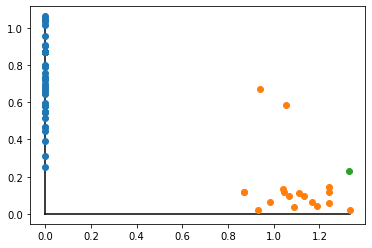

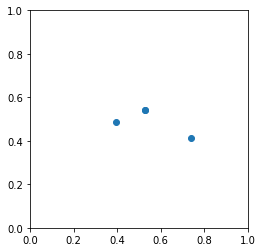

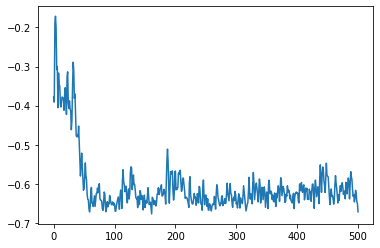


Training finished.


In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 4,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.01,
              init_phases = 'normal',
              bTranspose = False
            )
print(time.time()-t0)
model1.train()

-0.3779391050338745
-0.6770261526107788


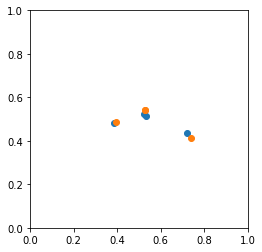

In [50]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 4 neurons, lr 0.05

0.004037141799926758
tensor(-0.3779, grad_fn=<RsubBackward1>)

run=0, time=0.41s


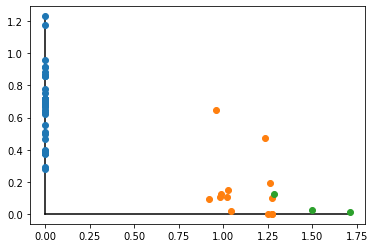

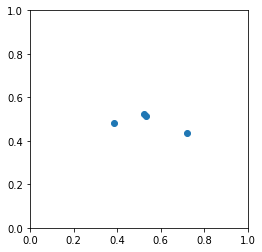

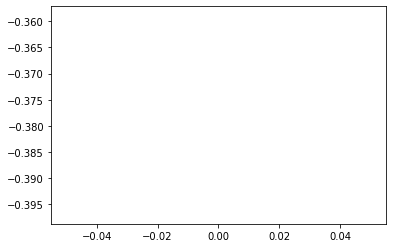


tensor(-0.1033, grad_fn=<RsubBackward1>)

tensor(-0.1634, grad_fn=<RsubBackward1>)

tensor(-0.1802, grad_fn=<RsubBackward1>)

tensor(-0.2819, grad_fn=<RsubBackward1>)

tensor(-0.0469, grad_fn=<RsubBackward1>)

tensor(-0.0170, grad_fn=<RsubBackward1>)

tensor(-0.0416, grad_fn=<RsubBackward1>)

tensor(-0.0292, grad_fn=<RsubBackward1>)

tensor(-0.2317, grad_fn=<RsubBackward1>)

tensor(-0.1978, grad_fn=<RsubBackward1>)

tensor(-0.3438, grad_fn=<RsubBackward1>)

tensor(-0.0345, grad_fn=<RsubBackward1>)

tensor(-0.2209, grad_fn=<RsubBackward1>)

tensor(-0.1259, grad_fn=<RsubBackward1>)

tensor(-0.1305, grad_fn=<RsubBackward1>)

tensor(-0.1257, grad_fn=<RsubBackward1>)

tensor(-0.1831, grad_fn=<RsubBackward1>)

tensor(-0.0261, grad_fn=<RsubBackward1>)

tensor(-0.0243, grad_fn=<RsubBackward1>)

tensor(-0.0027, grad_fn=<RsubBackward1>)

tensor(-0.1245, grad_fn=<RsubBackward1>)

tensor(-0.0713, grad_fn=<RsubBackward1>)

tensor(-0.0650, grad_fn=<RsubBackward1>)

tensor(-0.0641, grad_fn=<RsubBack

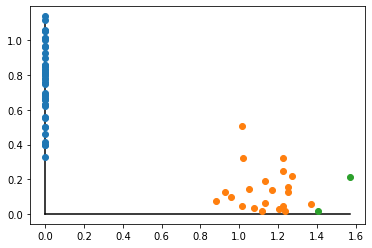

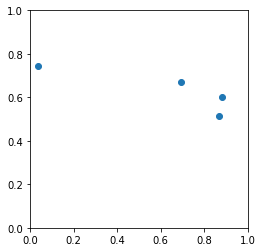

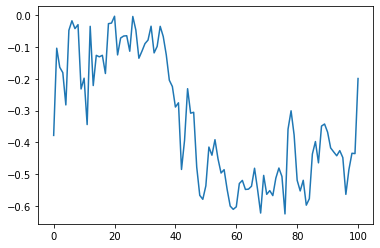


tensor(-0.1090, grad_fn=<RsubBackward1>)

tensor(-0.0471, grad_fn=<RsubBackward1>)

tensor(-0.0965, grad_fn=<RsubBackward1>)

tensor(-0.2243, grad_fn=<RsubBackward1>)

tensor(-0.0792, grad_fn=<RsubBackward1>)

tensor(-0.0045, grad_fn=<RsubBackward1>)

tensor(-0.0525, grad_fn=<RsubBackward1>)

tensor(-0.0650, grad_fn=<RsubBackward1>)

tensor(-0.0865, grad_fn=<RsubBackward1>)

tensor(-0.1115, grad_fn=<RsubBackward1>)

tensor(-0.1435, grad_fn=<RsubBackward1>)

tensor(-0.1769, grad_fn=<RsubBackward1>)

tensor(-0.1480, grad_fn=<RsubBackward1>)

tensor(-0.1587, grad_fn=<RsubBackward1>)

tensor(-0.0940, grad_fn=<RsubBackward1>)

tensor(-0.0504, grad_fn=<RsubBackward1>)

tensor(-0.0398, grad_fn=<RsubBackward1>)

tensor(-0.1147, grad_fn=<RsubBackward1>)

tensor(-0.0463, grad_fn=<RsubBackward1>)

tensor(-0.0205, grad_fn=<RsubBackward1>)

tensor(-0.0142, grad_fn=<RsubBackward1>)

tensor(-0.0147, grad_fn=<RsubBackward1>)

tensor(-0.0917, grad_fn=<RsubBackward1>)

tensor(-0.0515, grad_fn=<RsubBack

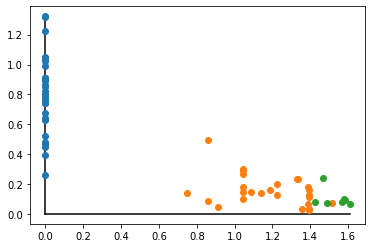

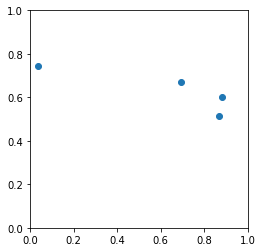

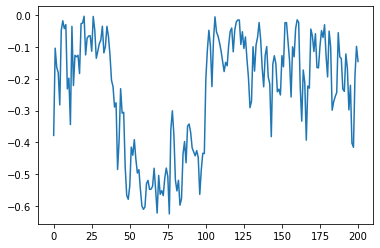


tensor(-0.0434, grad_fn=<RsubBackward1>)

tensor(-0.0888, grad_fn=<RsubBackward1>)

tensor(-0.1327, grad_fn=<RsubBackward1>)

tensor(-0.1282, grad_fn=<RsubBackward1>)

tensor(-0.1628, grad_fn=<RsubBackward1>)

tensor(-0.0645, grad_fn=<RsubBackward1>)

tensor(-0.1992, grad_fn=<RsubBackward1>)

tensor(-0.2585, grad_fn=<RsubBackward1>)

tensor(-0.2701, grad_fn=<RsubBackward1>)

tensor(-0.2499, grad_fn=<RsubBackward1>)

tensor(-0.3919, grad_fn=<RsubBackward1>)

tensor(-0.2885, grad_fn=<RsubBackward1>)

tensor(-0.1468, grad_fn=<RsubBackward1>)

tensor(-0.2071, grad_fn=<RsubBackward1>)

tensor(-0.2006, grad_fn=<RsubBackward1>)

tensor(-0.1678, grad_fn=<RsubBackward1>)

tensor(-0.2750, grad_fn=<RsubBackward1>)

tensor(-0.1968, grad_fn=<RsubBackward1>)

tensor(-0.2400, grad_fn=<RsubBackward1>)

tensor(-0.3591, grad_fn=<RsubBackward1>)

tensor(-0.3083, grad_fn=<RsubBackward1>)

tensor(-0.2933, grad_fn=<RsubBackward1>)

tensor(-0.1859, grad_fn=<RsubBackward1>)

tensor(-0.1197, grad_fn=<RsubBack

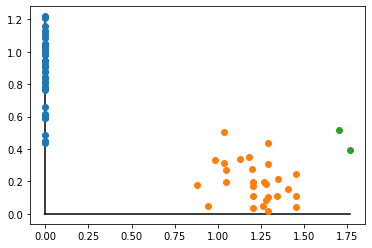

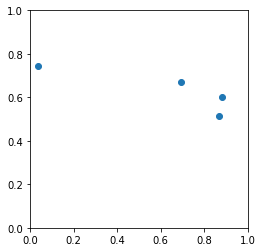

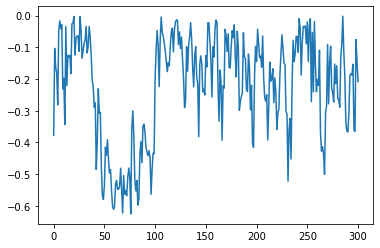


tensor(-0.2310, grad_fn=<RsubBackward1>)

tensor(-0.1607, grad_fn=<RsubBackward1>)

tensor(-0.1019, grad_fn=<RsubBackward1>)

tensor(-0.0473, grad_fn=<RsubBackward1>)

tensor(-0.1294, grad_fn=<RsubBackward1>)

tensor(-0.0991, grad_fn=<RsubBackward1>)

tensor(-0.1085, grad_fn=<RsubBackward1>)

tensor(-0.0695, grad_fn=<RsubBackward1>)

tensor(-0.3453, grad_fn=<RsubBackward1>)

tensor(-0.2428, grad_fn=<RsubBackward1>)

tensor(-0.1953, grad_fn=<RsubBackward1>)

tensor(-0.1906, grad_fn=<RsubBackward1>)

tensor(-0.2346, grad_fn=<RsubBackward1>)

tensor(-0.3473, grad_fn=<RsubBackward1>)

tensor(-0.3920, grad_fn=<RsubBackward1>)

tensor(-0.3622, grad_fn=<RsubBackward1>)

tensor(-0.3762, grad_fn=<RsubBackward1>)

tensor(-0.2900, grad_fn=<RsubBackward1>)

tensor(-0.2748, grad_fn=<RsubBackward1>)

tensor(-0.4686, grad_fn=<RsubBackward1>)

tensor(-0.5490, grad_fn=<RsubBackward1>)

tensor(-0.5165, grad_fn=<RsubBackward1>)

tensor(-0.2081, grad_fn=<RsubBackward1>)

tensor(-0.2035, grad_fn=<RsubBack

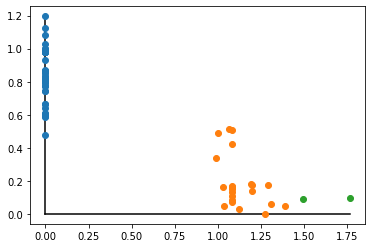

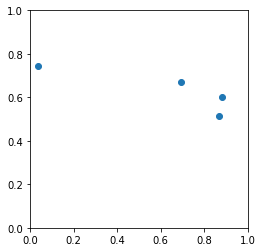

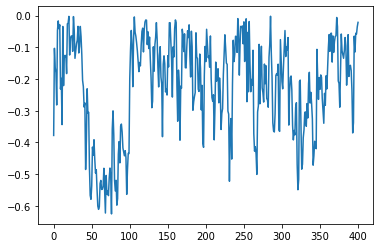


tensor(-0.0810, grad_fn=<RsubBackward1>)

tensor(-0.0901, grad_fn=<RsubBackward1>)

tensor(-0.1537, grad_fn=<RsubBackward1>)

tensor(-0.0385, grad_fn=<RsubBackward1>)

tensor(-0.0561, grad_fn=<RsubBackward1>)

tensor(-0.0126, grad_fn=<RsubBackward1>)

tensor(-0.2736, grad_fn=<RsubBackward1>)

tensor(-0.1446, grad_fn=<RsubBackward1>)

tensor(-0.2512, grad_fn=<RsubBackward1>)

tensor(-0.0369, grad_fn=<RsubBackward1>)

tensor(-0.0967, grad_fn=<RsubBackward1>)

tensor(-0.0007, grad_fn=<RsubBackward1>)

tensor(-0.1010, grad_fn=<RsubBackward1>)

tensor(-0.1356, grad_fn=<RsubBackward1>)

tensor(-0.2474, grad_fn=<RsubBackward1>)

tensor(-0.1659, grad_fn=<RsubBackward1>)

tensor(-0.1814, grad_fn=<RsubBackward1>)

tensor(-0.1670, grad_fn=<RsubBackward1>)

tensor(-0.2214, grad_fn=<RsubBackward1>)

tensor(-0.3012, grad_fn=<RsubBackward1>)

tensor(-0.2952, grad_fn=<RsubBackward1>)

tensor(-0.2709, grad_fn=<RsubBackward1>)

tensor(-0.2850, grad_fn=<RsubBackward1>)

tensor(-0.2226, grad_fn=<RsubBack

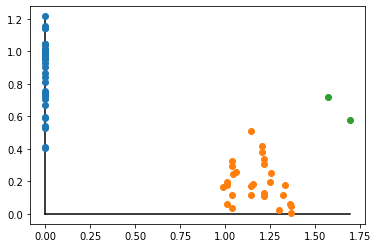

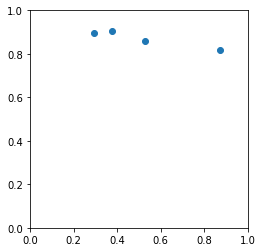

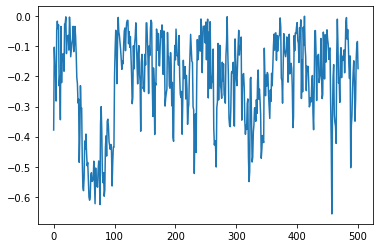


Training finished.


In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 4,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.05,
              init_phases = 'normal',
              bTranspose = False
            )
print(time.time()-t0)
model1.train()

-0.3779391050338745
-0.6562568545341492


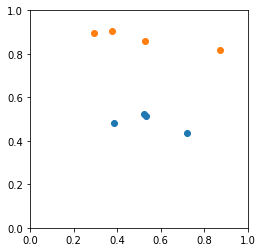

In [69]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 49,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.0,
              init_phases = 'normal',
                bTranspose = False

            )
print(time.time()-t0)
model1.train()

In [ ]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.01

0.019013166427612305
tensor(-0.5873, grad_fn=<RsubBackward1>)

run=0, time=1.10s


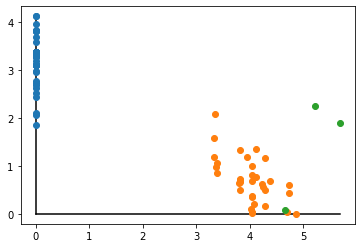

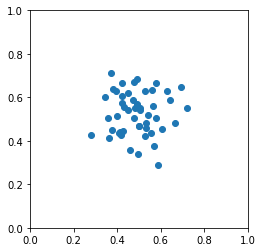

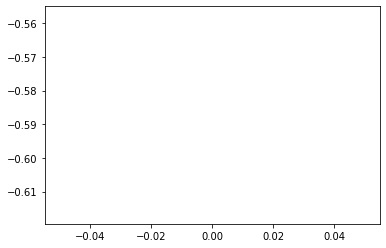


tensor(-0.7834, grad_fn=<RsubBackward1>)

tensor(-0.9923, grad_fn=<RsubBackward1>)

tensor(-1.0823, grad_fn=<RsubBackward1>)

tensor(-1.0377, grad_fn=<RsubBackward1>)

tensor(-1.0068, grad_fn=<RsubBackward1>)

tensor(-1.0326, grad_fn=<RsubBackward1>)

tensor(-1.1998, grad_fn=<RsubBackward1>)

tensor(-1.1929, grad_fn=<RsubBackward1>)

tensor(-1.3046, grad_fn=<RsubBackward1>)

tensor(-1.4333, grad_fn=<RsubBackward1>)

tensor(-1.7667, grad_fn=<RsubBackward1>)

tensor(-1.8592, grad_fn=<RsubBackward1>)

tensor(-1.7540, grad_fn=<RsubBackward1>)

tensor(-1.6999, grad_fn=<RsubBackward1>)

tensor(-1.8391, grad_fn=<RsubBackward1>)

tensor(-1.9319, grad_fn=<RsubBackward1>)

tensor(-2.0664, grad_fn=<RsubBackward1>)

tensor(-2.1412, grad_fn=<RsubBackward1>)

tensor(-2.1314, grad_fn=<RsubBackward1>)

tensor(-2.0728, grad_fn=<RsubBackward1>)

tensor(-2.0570, grad_fn=<RsubBackward1>)

tensor(-2.1584, grad_fn=<RsubBackward1>)

tensor(-2.1093, grad_fn=<RsubBackward1>)

tensor(-2.0602, grad_fn=<RsubBack

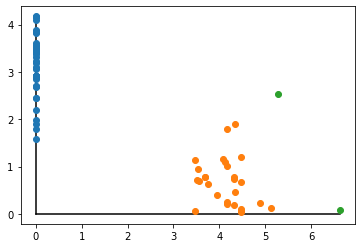

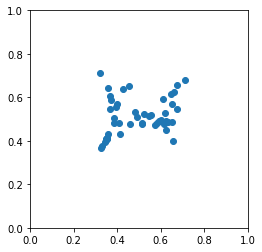

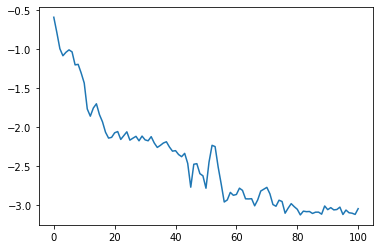


tensor(-3.0062, grad_fn=<RsubBackward1>)

tensor(-3.0904, grad_fn=<RsubBackward1>)

tensor(-2.9572, grad_fn=<RsubBackward1>)

tensor(-2.9260, grad_fn=<RsubBackward1>)

tensor(-2.9771, grad_fn=<RsubBackward1>)

tensor(-2.9750, grad_fn=<RsubBackward1>)

tensor(-3.0126, grad_fn=<RsubBackward1>)

tensor(-3.0932, grad_fn=<RsubBackward1>)

tensor(-2.9437, grad_fn=<RsubBackward1>)

tensor(-2.9024, grad_fn=<RsubBackward1>)

tensor(-2.9282, grad_fn=<RsubBackward1>)

tensor(-2.9812, grad_fn=<RsubBackward1>)

tensor(-3.1191, grad_fn=<RsubBackward1>)

tensor(-3.0741, grad_fn=<RsubBackward1>)

tensor(-2.9900, grad_fn=<RsubBackward1>)

tensor(-3.0039, grad_fn=<RsubBackward1>)

tensor(-2.9671, grad_fn=<RsubBackward1>)

tensor(-2.9994, grad_fn=<RsubBackward1>)

tensor(-3.0215, grad_fn=<RsubBackward1>)

tensor(-3.0769, grad_fn=<RsubBackward1>)

tensor(-3.0481, grad_fn=<RsubBackward1>)

tensor(-3.0975, grad_fn=<RsubBackward1>)

tensor(-3.0941, grad_fn=<RsubBackward1>)

tensor(-3.0799, grad_fn=<RsubBack

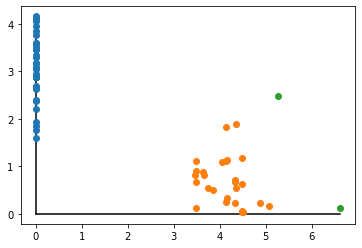

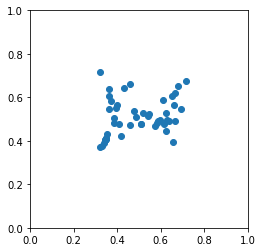

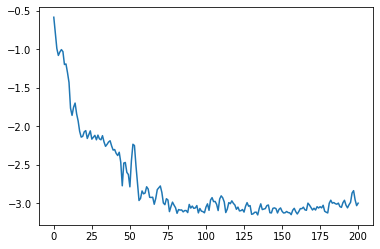


tensor(-3.0399, grad_fn=<RsubBackward1>)

tensor(-3.0680, grad_fn=<RsubBackward1>)

tensor(-2.9841, grad_fn=<RsubBackward1>)

tensor(-2.9934, grad_fn=<RsubBackward1>)

tensor(-3.0727, grad_fn=<RsubBackward1>)

tensor(-3.0121, grad_fn=<RsubBackward1>)

tensor(-2.9846, grad_fn=<RsubBackward1>)

tensor(-3.0307, grad_fn=<RsubBackward1>)

tensor(-3.1157, grad_fn=<RsubBackward1>)

tensor(-3.1665, grad_fn=<RsubBackward1>)

tensor(-3.0197, grad_fn=<RsubBackward1>)

tensor(-3.0068, grad_fn=<RsubBackward1>)

tensor(-2.9805, grad_fn=<RsubBackward1>)

tensor(-3.0529, grad_fn=<RsubBackward1>)

tensor(-3.1122, grad_fn=<RsubBackward1>)

tensor(-3.0802, grad_fn=<RsubBackward1>)

tensor(-3.0111, grad_fn=<RsubBackward1>)

tensor(-2.9350, grad_fn=<RsubBackward1>)

tensor(-2.9575, grad_fn=<RsubBackward1>)

tensor(-3.0052, grad_fn=<RsubBackward1>)

tensor(-3.0928, grad_fn=<RsubBackward1>)

tensor(-3.0583, grad_fn=<RsubBackward1>)

tensor(-3.0990, grad_fn=<RsubBackward1>)

tensor(-3.0471, grad_fn=<RsubBack

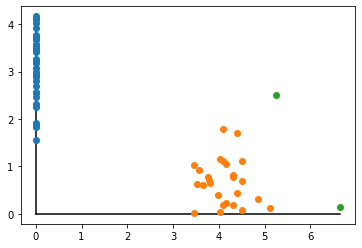

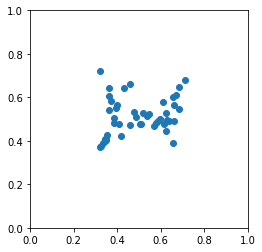

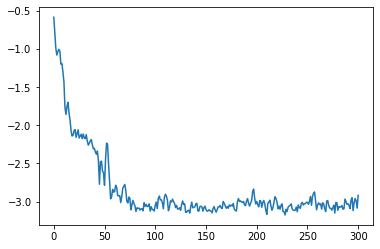


tensor(-2.8462, grad_fn=<RsubBackward1>)

tensor(-2.8563, grad_fn=<RsubBackward1>)

tensor(-2.9906, grad_fn=<RsubBackward1>)

tensor(-3.0614, grad_fn=<RsubBackward1>)

tensor(-3.0418, grad_fn=<RsubBackward1>)

tensor(-2.9994, grad_fn=<RsubBackward1>)

tensor(-3.0126, grad_fn=<RsubBackward1>)

tensor(-3.0769, grad_fn=<RsubBackward1>)

tensor(-3.0443, grad_fn=<RsubBackward1>)

tensor(-3.0326, grad_fn=<RsubBackward1>)

tensor(-3.0373, grad_fn=<RsubBackward1>)

tensor(-3.0146, grad_fn=<RsubBackward1>)

tensor(-2.9927, grad_fn=<RsubBackward1>)

tensor(-3.0954, grad_fn=<RsubBackward1>)

tensor(-3.0279, grad_fn=<RsubBackward1>)

tensor(-2.9590, grad_fn=<RsubBackward1>)

tensor(-2.9583, grad_fn=<RsubBackward1>)

tensor(-3.0266, grad_fn=<RsubBackward1>)

tensor(-2.9807, grad_fn=<RsubBackward1>)

tensor(-2.8834, grad_fn=<RsubBackward1>)

tensor(-2.9253, grad_fn=<RsubBackward1>)

tensor(-3.0947, grad_fn=<RsubBackward1>)

tensor(-3.0233, grad_fn=<RsubBackward1>)

tensor(-2.9369, grad_fn=<RsubBack

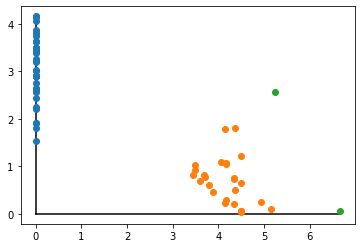

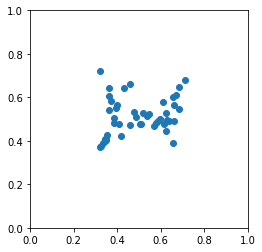

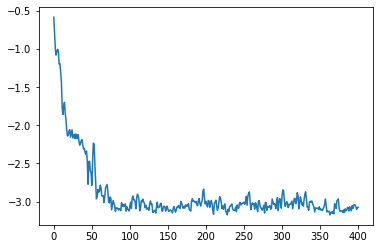


tensor(-3.0631, grad_fn=<RsubBackward1>)

tensor(-3.0809, grad_fn=<RsubBackward1>)

tensor(-3.1333, grad_fn=<RsubBackward1>)

tensor(-3.0595, grad_fn=<RsubBackward1>)

tensor(-3.0859, grad_fn=<RsubBackward1>)

tensor(-3.1113, grad_fn=<RsubBackward1>)

tensor(-3.1151, grad_fn=<RsubBackward1>)

tensor(-3.0851, grad_fn=<RsubBackward1>)

tensor(-3.0488, grad_fn=<RsubBackward1>)

tensor(-3.1107, grad_fn=<RsubBackward1>)

tensor(-3.0928, grad_fn=<RsubBackward1>)

tensor(-3.0758, grad_fn=<RsubBackward1>)

tensor(-3.0366, grad_fn=<RsubBackward1>)

tensor(-3.0442, grad_fn=<RsubBackward1>)

tensor(-3.0282, grad_fn=<RsubBackward1>)

tensor(-2.9894, grad_fn=<RsubBackward1>)

tensor(-2.9960, grad_fn=<RsubBackward1>)

tensor(-3.1122, grad_fn=<RsubBackward1>)

tensor(-3.1238, grad_fn=<RsubBackward1>)

tensor(-3.1472, grad_fn=<RsubBackward1>)

tensor(-2.9881, grad_fn=<RsubBackward1>)

tensor(-3.0262, grad_fn=<RsubBackward1>)

tensor(-2.8819, grad_fn=<RsubBackward1>)

tensor(-2.8906, grad_fn=<RsubBack

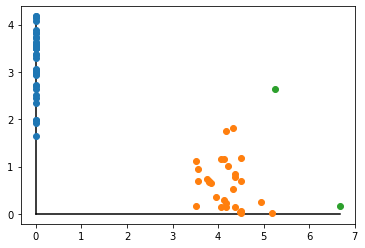

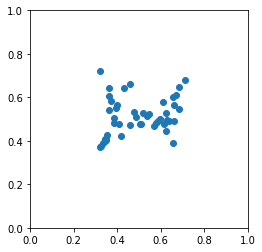

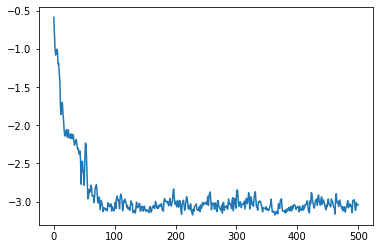


Training finished.


In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 49,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.01,
              init_phases = 'normal',
                bTranspose = False

            )
print(time.time()-t0)
model1.train()

-0.5872576236724854
-3.1734399795532227


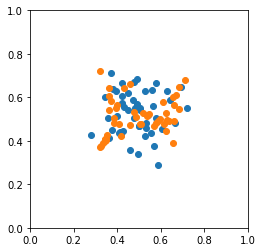

In [55]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.05

0.011412620544433594
tensor(-0.5873, grad_fn=<RsubBackward1>)

run=0, time=1.00s


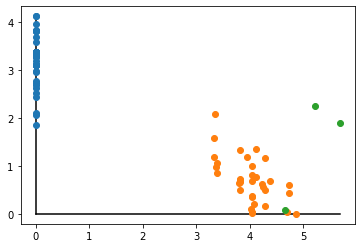

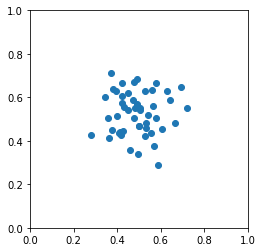

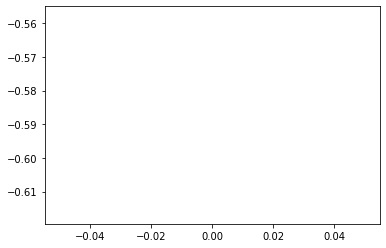


tensor(-0.6571, grad_fn=<RsubBackward1>)

tensor(-0.4419, grad_fn=<RsubBackward1>)

tensor(-1.5927, grad_fn=<RsubBackward1>)

tensor(-1.1653, grad_fn=<RsubBackward1>)

tensor(-0.6281, grad_fn=<RsubBackward1>)

tensor(-0.8464, grad_fn=<RsubBackward1>)

tensor(-0.5950, grad_fn=<RsubBackward1>)

tensor(-1.2828, grad_fn=<RsubBackward1>)

tensor(-1.8358, grad_fn=<RsubBackward1>)

tensor(-1.4336, grad_fn=<RsubBackward1>)

tensor(-1.5482, grad_fn=<RsubBackward1>)

tensor(-1.0423, grad_fn=<RsubBackward1>)

tensor(-0.2409, grad_fn=<RsubBackward1>)

tensor(-0.1720, grad_fn=<RsubBackward1>)

tensor(-0.3464, grad_fn=<RsubBackward1>)

tensor(-0.2607, grad_fn=<RsubBackward1>)

tensor(-0.1323, grad_fn=<RsubBackward1>)

tensor(-0.5914, grad_fn=<RsubBackward1>)

tensor(-0.3679, grad_fn=<RsubBackward1>)

tensor(-0.2785, grad_fn=<RsubBackward1>)

tensor(-0.5013, grad_fn=<RsubBackward1>)

tensor(-0.5950, grad_fn=<RsubBackward1>)

tensor(-0.2148, grad_fn=<RsubBackward1>)

tensor(-0.3652, grad_fn=<RsubBack

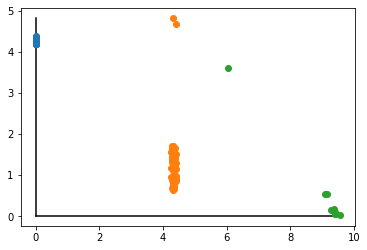

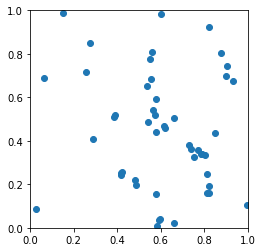

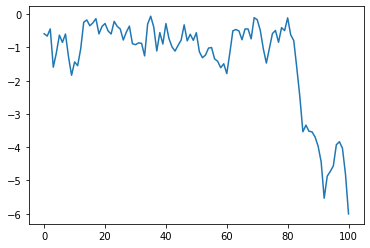


tensor(-6.3365, grad_fn=<RsubBackward1>)

tensor(-5.7890, grad_fn=<RsubBackward1>)

tensor(-5.4225, grad_fn=<RsubBackward1>)

tensor(-5.6784, grad_fn=<RsubBackward1>)

tensor(-5.9509, grad_fn=<RsubBackward1>)

tensor(-6.1089, grad_fn=<RsubBackward1>)

tensor(-6.2203, grad_fn=<RsubBackward1>)

tensor(-6.1281, grad_fn=<RsubBackward1>)

tensor(-6.0817, grad_fn=<RsubBackward1>)

tensor(-6.0882, grad_fn=<RsubBackward1>)

tensor(-6.2460, grad_fn=<RsubBackward1>)

tensor(-6.3455, grad_fn=<RsubBackward1>)

tensor(-5.9975, grad_fn=<RsubBackward1>)

tensor(-5.7465, grad_fn=<RsubBackward1>)

tensor(-5.9807, grad_fn=<RsubBackward1>)

tensor(-6.3485, grad_fn=<RsubBackward1>)

tensor(-6.1069, grad_fn=<RsubBackward1>)

tensor(-5.8821, grad_fn=<RsubBackward1>)

tensor(-5.6344, grad_fn=<RsubBackward1>)

tensor(-5.1601, grad_fn=<RsubBackward1>)

tensor(-4.9981, grad_fn=<RsubBackward1>)

tensor(-5.2618, grad_fn=<RsubBackward1>)

tensor(-5.6258, grad_fn=<RsubBackward1>)

tensor(-5.8138, grad_fn=<RsubBack

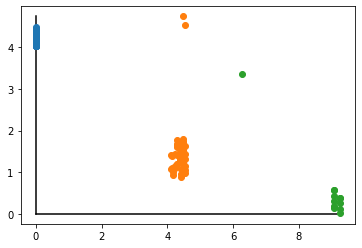

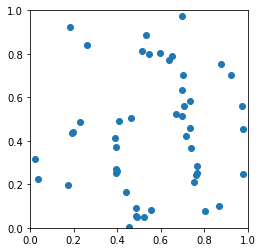

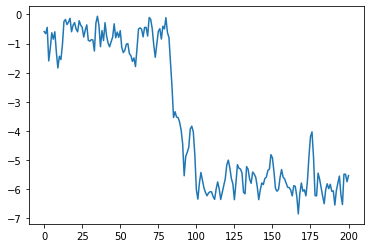


tensor(-5.0041, grad_fn=<RsubBackward1>)

tensor(-5.0913, grad_fn=<RsubBackward1>)

tensor(-5.1229, grad_fn=<RsubBackward1>)

tensor(-5.5198, grad_fn=<RsubBackward1>)

tensor(-5.5433, grad_fn=<RsubBackward1>)

tensor(-5.2792, grad_fn=<RsubBackward1>)

tensor(-5.2279, grad_fn=<RsubBackward1>)

tensor(-5.4155, grad_fn=<RsubBackward1>)

tensor(-5.7735, grad_fn=<RsubBackward1>)

tensor(-5.7500, grad_fn=<RsubBackward1>)

tensor(-5.7274, grad_fn=<RsubBackward1>)

tensor(-6.2951, grad_fn=<RsubBackward1>)

tensor(-6.3259, grad_fn=<RsubBackward1>)

tensor(-6.4281, grad_fn=<RsubBackward1>)

tensor(-6.5870, grad_fn=<RsubBackward1>)

tensor(-6.6680, grad_fn=<RsubBackward1>)

tensor(-6.4605, grad_fn=<RsubBackward1>)

tensor(-6.5000, grad_fn=<RsubBackward1>)

tensor(-6.3123, grad_fn=<RsubBackward1>)

tensor(-6.3477, grad_fn=<RsubBackward1>)

tensor(-6.0269, grad_fn=<RsubBackward1>)

tensor(-6.3253, grad_fn=<RsubBackward1>)

tensor(-6.3948, grad_fn=<RsubBackward1>)

tensor(-5.9620, grad_fn=<RsubBack

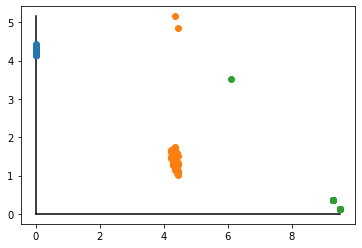

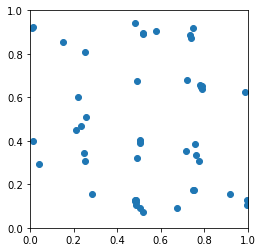

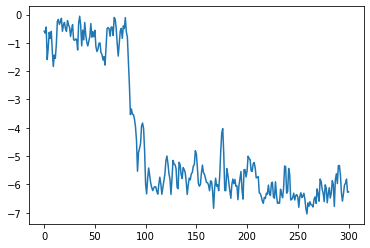


tensor(-6.5816, grad_fn=<RsubBackward1>)

tensor(-6.1773, grad_fn=<RsubBackward1>)

tensor(-6.4166, grad_fn=<RsubBackward1>)

tensor(-6.3060, grad_fn=<RsubBackward1>)

tensor(-6.0078, grad_fn=<RsubBackward1>)

tensor(-6.3137, grad_fn=<RsubBackward1>)

tensor(-6.9261, grad_fn=<RsubBackward1>)

tensor(-5.9910, grad_fn=<RsubBackward1>)

tensor(-5.8923, grad_fn=<RsubBackward1>)

tensor(-5.7016, grad_fn=<RsubBackward1>)

tensor(-6.2449, grad_fn=<RsubBackward1>)

tensor(-6.6585, grad_fn=<RsubBackward1>)

tensor(-6.2424, grad_fn=<RsubBackward1>)

tensor(-6.1123, grad_fn=<RsubBackward1>)

tensor(-6.4099, grad_fn=<RsubBackward1>)

tensor(-6.5410, grad_fn=<RsubBackward1>)

tensor(-6.1093, grad_fn=<RsubBackward1>)

tensor(-6.0575, grad_fn=<RsubBackward1>)

tensor(-6.2214, grad_fn=<RsubBackward1>)

tensor(-6.5744, grad_fn=<RsubBackward1>)

tensor(-6.3832, grad_fn=<RsubBackward1>)

tensor(-6.1848, grad_fn=<RsubBackward1>)

tensor(-6.5628, grad_fn=<RsubBackward1>)

tensor(-6.7229, grad_fn=<RsubBack

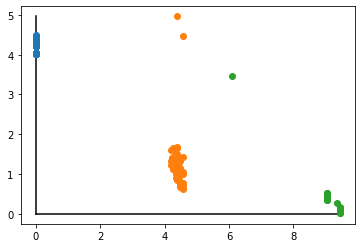

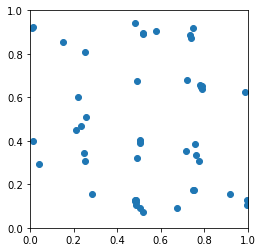

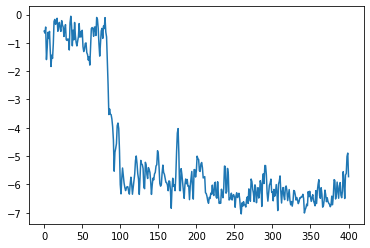


tensor(-5.8064, grad_fn=<RsubBackward1>)

tensor(-5.1612, grad_fn=<RsubBackward1>)

tensor(-4.9722, grad_fn=<RsubBackward1>)

tensor(-5.1651, grad_fn=<RsubBackward1>)

tensor(-4.8140, grad_fn=<RsubBackward1>)

tensor(-4.8501, grad_fn=<RsubBackward1>)

tensor(-4.9992, grad_fn=<RsubBackward1>)

tensor(-5.5927, grad_fn=<RsubBackward1>)

tensor(-5.7668, grad_fn=<RsubBackward1>)

tensor(-6.1436, grad_fn=<RsubBackward1>)

tensor(-5.6279, grad_fn=<RsubBackward1>)

tensor(-5.3988, grad_fn=<RsubBackward1>)

tensor(-5.4073, grad_fn=<RsubBackward1>)

tensor(-5.4676, grad_fn=<RsubBackward1>)

tensor(-5.8398, grad_fn=<RsubBackward1>)

tensor(-6.2776, grad_fn=<RsubBackward1>)

tensor(-5.3491, grad_fn=<RsubBackward1>)

tensor(-5.1103, grad_fn=<RsubBackward1>)

tensor(-5.2393, grad_fn=<RsubBackward1>)

tensor(-5.2538, grad_fn=<RsubBackward1>)

tensor(-5.5623, grad_fn=<RsubBackward1>)

tensor(-5.8677, grad_fn=<RsubBackward1>)

tensor(-6.5605, grad_fn=<RsubBackward1>)

tensor(-6.3288, grad_fn=<RsubBack

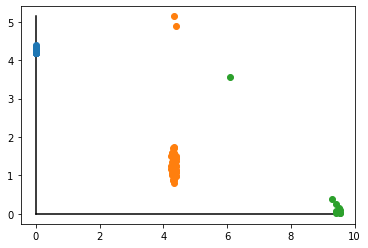

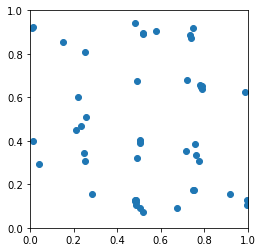

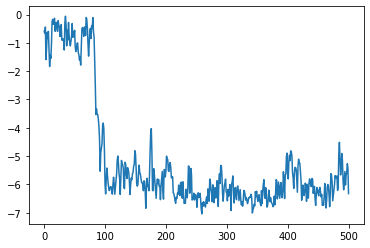


Training finished.


In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 49,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.05,
              init_phases = 'normal',
                bTranspose = False

            )
print(time.time()-t0)
model1.train()

-0.5872576236724854
-7.04415225982666


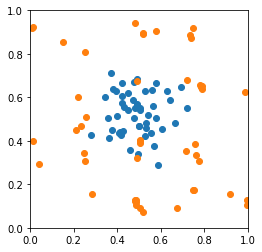

In [59]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.01, correlation

0.003995656967163086
tensor(-0.0117, grad_fn=<RsubBackward1>)

run=0, time=0.39s


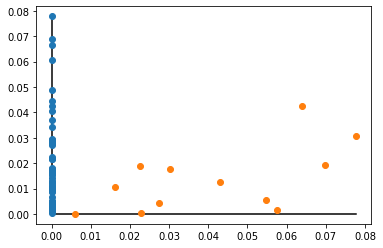

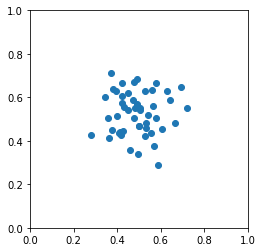

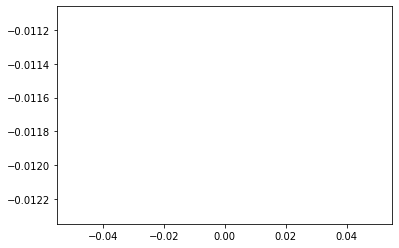


tensor(-0.0236, grad_fn=<RsubBackward1>)

tensor(-0.0529, grad_fn=<RsubBackward1>)

tensor(-0.0592, grad_fn=<RsubBackward1>)

tensor(-0.0669, grad_fn=<RsubBackward1>)

tensor(-0.0691, grad_fn=<RsubBackward1>)

tensor(-0.0733, grad_fn=<RsubBackward1>)

tensor(-0.0891, grad_fn=<RsubBackward1>)

tensor(-0.0859, grad_fn=<RsubBackward1>)

tensor(-0.1006, grad_fn=<RsubBackward1>)

tensor(-0.1115, grad_fn=<RsubBackward1>)

tensor(-0.1267, grad_fn=<RsubBackward1>)

tensor(-0.1122, grad_fn=<RsubBackward1>)

tensor(-0.1354, grad_fn=<RsubBackward1>)

tensor(-0.1504, grad_fn=<RsubBackward1>)

tensor(-0.1524, grad_fn=<RsubBackward1>)

tensor(-0.1481, grad_fn=<RsubBackward1>)

tensor(-0.1688, grad_fn=<RsubBackward1>)

tensor(-0.1766, grad_fn=<RsubBackward1>)

tensor(-0.1646, grad_fn=<RsubBackward1>)

tensor(-0.1622, grad_fn=<RsubBackward1>)

tensor(-0.1742, grad_fn=<RsubBackward1>)

tensor(-0.1639, grad_fn=<RsubBackward1>)

tensor(-0.1611, grad_fn=<RsubBackward1>)

tensor(-0.1891, grad_fn=<RsubBack

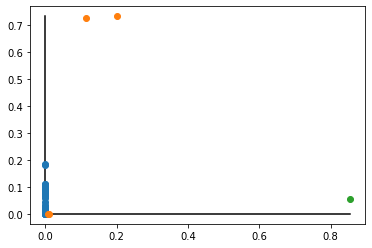

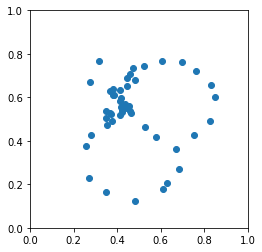

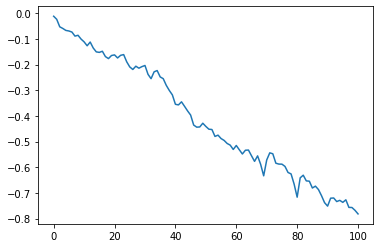


tensor(-0.7943, grad_fn=<RsubBackward1>)

tensor(-0.7709, grad_fn=<RsubBackward1>)

tensor(-0.7962, grad_fn=<RsubBackward1>)

tensor(-0.7808, grad_fn=<RsubBackward1>)

tensor(-0.7584, grad_fn=<RsubBackward1>)

tensor(-0.7773, grad_fn=<RsubBackward1>)

tensor(-0.8091, grad_fn=<RsubBackward1>)

tensor(-0.7936, grad_fn=<RsubBackward1>)

tensor(-0.8023, grad_fn=<RsubBackward1>)

tensor(-0.8217, grad_fn=<RsubBackward1>)

tensor(-0.8203, grad_fn=<RsubBackward1>)

tensor(-0.8305, grad_fn=<RsubBackward1>)

tensor(-0.8326, grad_fn=<RsubBackward1>)

tensor(-0.8270, grad_fn=<RsubBackward1>)

tensor(-0.8317, grad_fn=<RsubBackward1>)

tensor(-0.7948, grad_fn=<RsubBackward1>)

tensor(-0.8293, grad_fn=<RsubBackward1>)

tensor(-0.7942, grad_fn=<RsubBackward1>)

tensor(-0.7873, grad_fn=<RsubBackward1>)

tensor(-0.8182, grad_fn=<RsubBackward1>)

tensor(-0.8077, grad_fn=<RsubBackward1>)

tensor(-0.8123, grad_fn=<RsubBackward1>)

tensor(-0.7997, grad_fn=<RsubBackward1>)

tensor(-0.8045, grad_fn=<RsubBack

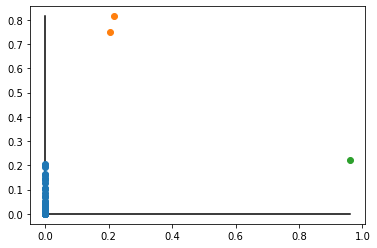

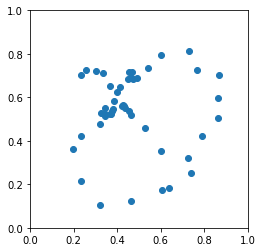

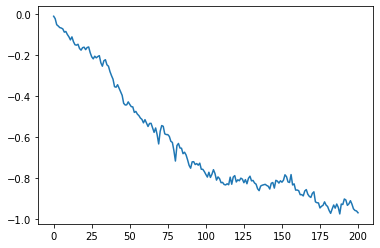


tensor(-0.9379, grad_fn=<RsubBackward1>)

tensor(-0.9402, grad_fn=<RsubBackward1>)

tensor(-0.9464, grad_fn=<RsubBackward1>)

tensor(-0.9581, grad_fn=<RsubBackward1>)

tensor(-0.9658, grad_fn=<RsubBackward1>)

tensor(-0.9614, grad_fn=<RsubBackward1>)

tensor(-0.9671, grad_fn=<RsubBackward1>)

tensor(-0.9470, grad_fn=<RsubBackward1>)

tensor(-0.9336, grad_fn=<RsubBackward1>)

tensor(-0.9659, grad_fn=<RsubBackward1>)

tensor(-0.9390, grad_fn=<RsubBackward1>)

tensor(-0.9333, grad_fn=<RsubBackward1>)

tensor(-0.9606, grad_fn=<RsubBackward1>)

tensor(-0.9320, grad_fn=<RsubBackward1>)

tensor(-0.9545, grad_fn=<RsubBackward1>)

tensor(-0.9585, grad_fn=<RsubBackward1>)

tensor(-0.9558, grad_fn=<RsubBackward1>)

tensor(-0.9534, grad_fn=<RsubBackward1>)

tensor(-0.9789, grad_fn=<RsubBackward1>)

tensor(-0.9691, grad_fn=<RsubBackward1>)

tensor(-1.0048, grad_fn=<RsubBackward1>)

tensor(-0.9881, grad_fn=<RsubBackward1>)

tensor(-0.9745, grad_fn=<RsubBackward1>)

tensor(-0.9739, grad_fn=<RsubBack

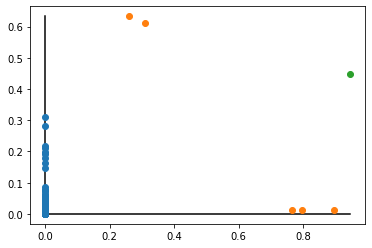

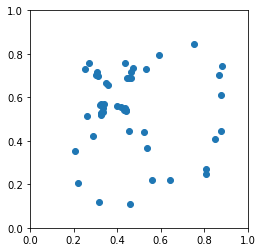

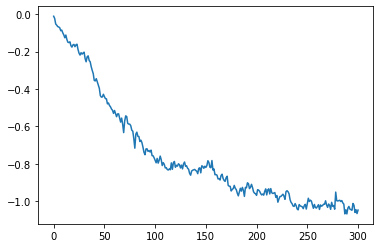


tensor(-1.0091, grad_fn=<RsubBackward1>)

tensor(-1.0199, grad_fn=<RsubBackward1>)

tensor(-1.0428, grad_fn=<RsubBackward1>)

tensor(-1.0311, grad_fn=<RsubBackward1>)

tensor(-1.0385, grad_fn=<RsubBackward1>)

tensor(-1.0107, grad_fn=<RsubBackward1>)

tensor(-0.9862, grad_fn=<RsubBackward1>)

tensor(-1.0276, grad_fn=<RsubBackward1>)

tensor(-1.0375, grad_fn=<RsubBackward1>)

tensor(-1.0355, grad_fn=<RsubBackward1>)

tensor(-1.0780, grad_fn=<RsubBackward1>)

tensor(-1.0407, grad_fn=<RsubBackward1>)

tensor(-1.0388, grad_fn=<RsubBackward1>)

tensor(-1.0365, grad_fn=<RsubBackward1>)

tensor(-1.0585, grad_fn=<RsubBackward1>)

tensor(-1.0565, grad_fn=<RsubBackward1>)

tensor(-1.0633, grad_fn=<RsubBackward1>)

tensor(-1.0673, grad_fn=<RsubBackward1>)

tensor(-1.0833, grad_fn=<RsubBackward1>)

tensor(-1.0994, grad_fn=<RsubBackward1>)

tensor(-1.1006, grad_fn=<RsubBackward1>)

tensor(-1.0879, grad_fn=<RsubBackward1>)

tensor(-1.0648, grad_fn=<RsubBackward1>)

tensor(-1.0776, grad_fn=<RsubBack

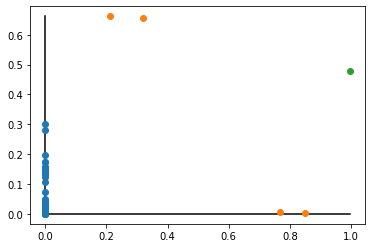

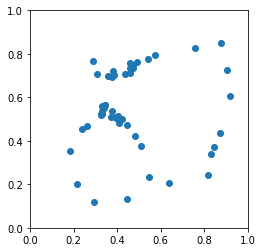

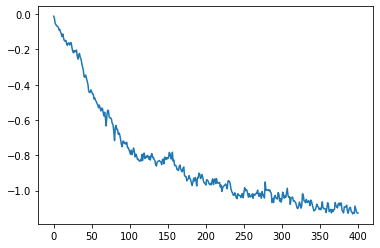


tensor(-1.1254, grad_fn=<RsubBackward1>)

tensor(-1.1111, grad_fn=<RsubBackward1>)

tensor(-1.1193, grad_fn=<RsubBackward1>)

tensor(-1.1255, grad_fn=<RsubBackward1>)

tensor(-1.1135, grad_fn=<RsubBackward1>)

tensor(-1.1157, grad_fn=<RsubBackward1>)

tensor(-1.1273, grad_fn=<RsubBackward1>)

tensor(-1.1276, grad_fn=<RsubBackward1>)

tensor(-1.1330, grad_fn=<RsubBackward1>)

tensor(-1.1095, grad_fn=<RsubBackward1>)

tensor(-1.1177, grad_fn=<RsubBackward1>)

tensor(-1.1386, grad_fn=<RsubBackward1>)

tensor(-1.1112, grad_fn=<RsubBackward1>)

tensor(-1.0498, grad_fn=<RsubBackward1>)

tensor(-1.0372, grad_fn=<RsubBackward1>)

tensor(-1.0852, grad_fn=<RsubBackward1>)

tensor(-1.0314, grad_fn=<RsubBackward1>)

tensor(-1.0009, grad_fn=<RsubBackward1>)

tensor(-0.9871, grad_fn=<RsubBackward1>)

tensor(-1.0395, grad_fn=<RsubBackward1>)

tensor(-1.1215, grad_fn=<RsubBackward1>)

tensor(-1.0454, grad_fn=<RsubBackward1>)

tensor(-1.0547, grad_fn=<RsubBackward1>)

tensor(-1.0738, grad_fn=<RsubBack

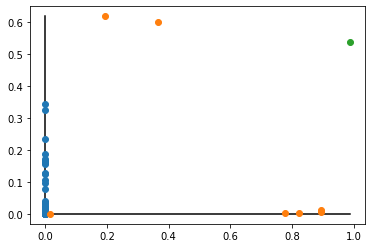

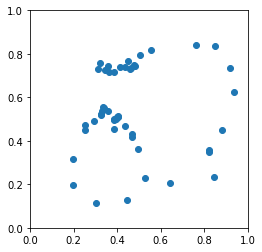

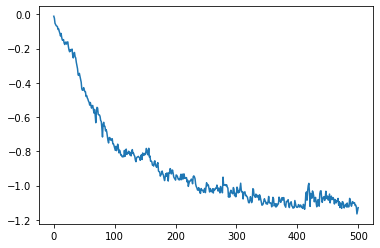


Training finished.


In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 49,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.01,
              init_phases = 'normal',
                bTranspose = True

            )
print(time.time()-t0)
model1.train()

-0.01170361042022705
-1.1654529571533203


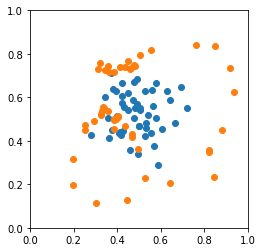

In [67]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.05, correlation

0.008453845977783203
tensor(-0.0117, grad_fn=<RsubBackward1>)

run=0, time=0.96s


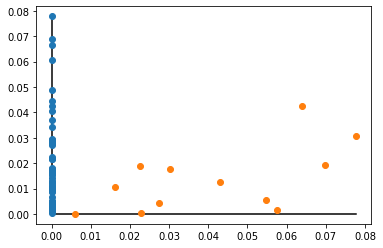

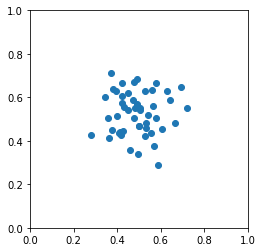

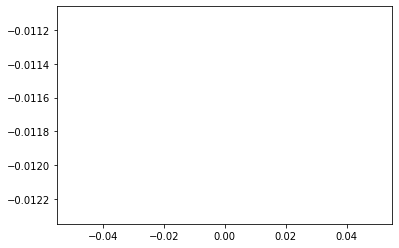


tensor(-0.0236, grad_fn=<RsubBackward1>)

tensor(-0.0432, grad_fn=<RsubBackward1>)

tensor(-0.0110, grad_fn=<RsubBackward1>)

tensor(-0.0020, grad_fn=<RsubBackward1>)

tensor(-0.0048, grad_fn=<RsubBackward1>)

tensor(-0.0065, grad_fn=<RsubBackward1>)

tensor(-0.0031, grad_fn=<RsubBackward1>)

tensor(-0.0525, grad_fn=<RsubBackward1>)

tensor(-0.0184, grad_fn=<RsubBackward1>)

tensor(-0.0223, grad_fn=<RsubBackward1>)

tensor(-0.0500, grad_fn=<RsubBackward1>)

tensor(-0.0008, grad_fn=<RsubBackward1>)

tensor(-0.0715, grad_fn=<RsubBackward1>)

tensor(-0.0019, grad_fn=<RsubBackward1>)

tensor(-0.0381, grad_fn=<RsubBackward1>)

tensor(-0.3203, grad_fn=<RsubBackward1>)

tensor(-0.4002, grad_fn=<RsubBackward1>)

tensor(-0.3286, grad_fn=<RsubBackward1>)

tensor(-0.4658, grad_fn=<RsubBackward1>)

tensor(-0.5189, grad_fn=<RsubBackward1>)

tensor(-0.5017, grad_fn=<RsubBackward1>)

tensor(-0.5659, grad_fn=<RsubBackward1>)

tensor(-0.4774, grad_fn=<RsubBackward1>)

tensor(-0.4218, grad_fn=<RsubBack

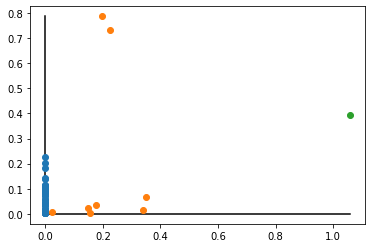

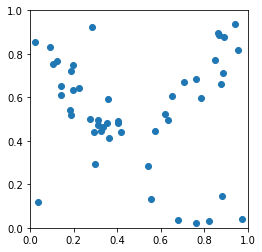

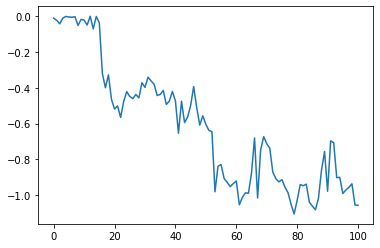


tensor(-1.0758, grad_fn=<RsubBackward1>)

tensor(-0.9596, grad_fn=<RsubBackward1>)

tensor(-1.0555, grad_fn=<RsubBackward1>)

tensor(-1.1147, grad_fn=<RsubBackward1>)

tensor(-1.0672, grad_fn=<RsubBackward1>)

tensor(-1.0714, grad_fn=<RsubBackward1>)

tensor(-0.9062, grad_fn=<RsubBackward1>)

tensor(-0.9464, grad_fn=<RsubBackward1>)

tensor(-0.9603, grad_fn=<RsubBackward1>)

tensor(-1.1144, grad_fn=<RsubBackward1>)

tensor(-1.1359, grad_fn=<RsubBackward1>)

tensor(-1.0987, grad_fn=<RsubBackward1>)

tensor(-1.1589, grad_fn=<RsubBackward1>)

tensor(-1.1277, grad_fn=<RsubBackward1>)

tensor(-1.1733, grad_fn=<RsubBackward1>)

tensor(-1.0503, grad_fn=<RsubBackward1>)

tensor(-0.9455, grad_fn=<RsubBackward1>)

tensor(-0.9768, grad_fn=<RsubBackward1>)

tensor(-0.9861, grad_fn=<RsubBackward1>)

tensor(-1.1256, grad_fn=<RsubBackward1>)

tensor(-0.8746, grad_fn=<RsubBackward1>)

tensor(-0.8418, grad_fn=<RsubBackward1>)

tensor(-0.8270, grad_fn=<RsubBackward1>)

tensor(-0.8069, grad_fn=<RsubBack

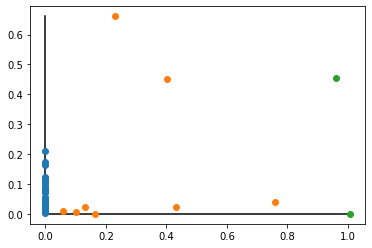

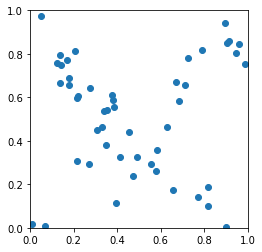

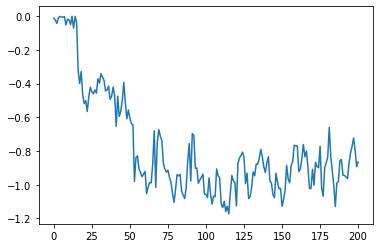


tensor(-0.9455, grad_fn=<RsubBackward1>)

tensor(-1.0198, grad_fn=<RsubBackward1>)

tensor(-1.1241, grad_fn=<RsubBackward1>)

tensor(-1.0047, grad_fn=<RsubBackward1>)

tensor(-1.0589, grad_fn=<RsubBackward1>)

tensor(-1.0321, grad_fn=<RsubBackward1>)

tensor(-1.0224, grad_fn=<RsubBackward1>)

tensor(-0.8277, grad_fn=<RsubBackward1>)

tensor(-1.0026, grad_fn=<RsubBackward1>)

tensor(-1.0433, grad_fn=<RsubBackward1>)

tensor(-1.0297, grad_fn=<RsubBackward1>)

tensor(-1.0378, grad_fn=<RsubBackward1>)

tensor(-1.1157, grad_fn=<RsubBackward1>)

tensor(-1.1042, grad_fn=<RsubBackward1>)

tensor(-1.0930, grad_fn=<RsubBackward1>)

tensor(-1.0565, grad_fn=<RsubBackward1>)

tensor(-1.1315, grad_fn=<RsubBackward1>)

tensor(-1.0213, grad_fn=<RsubBackward1>)

tensor(-1.0022, grad_fn=<RsubBackward1>)

tensor(-1.0194, grad_fn=<RsubBackward1>)

tensor(-1.1026, grad_fn=<RsubBackward1>)

tensor(-1.0782, grad_fn=<RsubBackward1>)

tensor(-1.0835, grad_fn=<RsubBackward1>)

tensor(-1.0767, grad_fn=<RsubBack

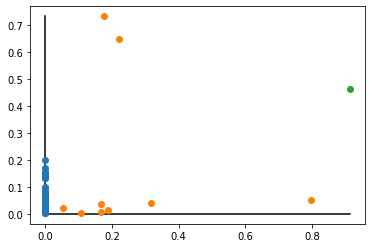

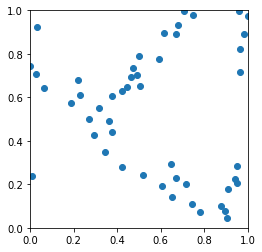

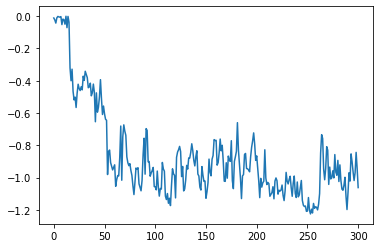


tensor(-0.9050, grad_fn=<RsubBackward1>)

tensor(-1.0631, grad_fn=<RsubBackward1>)

tensor(-0.9185, grad_fn=<RsubBackward1>)

tensor(-1.0623, grad_fn=<RsubBackward1>)

tensor(-1.0838, grad_fn=<RsubBackward1>)

tensor(-0.9876, grad_fn=<RsubBackward1>)

tensor(-1.0413, grad_fn=<RsubBackward1>)

tensor(-1.0262, grad_fn=<RsubBackward1>)

tensor(-0.8552, grad_fn=<RsubBackward1>)

tensor(-1.0541, grad_fn=<RsubBackward1>)

tensor(-1.1195, grad_fn=<RsubBackward1>)

tensor(-1.0203, grad_fn=<RsubBackward1>)

tensor(-1.1445, grad_fn=<RsubBackward1>)

tensor(-1.0696, grad_fn=<RsubBackward1>)

tensor(-1.1629, grad_fn=<RsubBackward1>)

tensor(-1.1540, grad_fn=<RsubBackward1>)

tensor(-1.0167, grad_fn=<RsubBackward1>)

tensor(-0.9038, grad_fn=<RsubBackward1>)

tensor(-1.0374, grad_fn=<RsubBackward1>)

tensor(-1.0040, grad_fn=<RsubBackward1>)

tensor(-0.9179, grad_fn=<RsubBackward1>)

tensor(-1.1225, grad_fn=<RsubBackward1>)

tensor(-0.8807, grad_fn=<RsubBackward1>)

tensor(-0.9772, grad_fn=<RsubBack

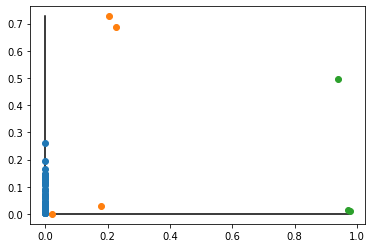

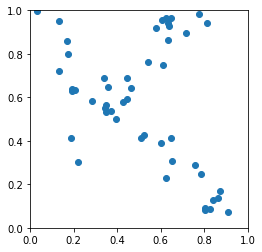

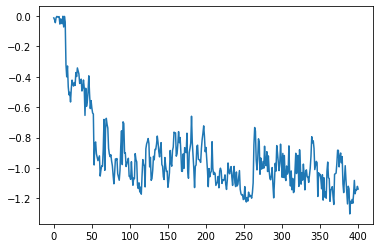


tensor(-1.0840, grad_fn=<RsubBackward1>)

tensor(-0.8692, grad_fn=<RsubBackward1>)

tensor(-0.9685, grad_fn=<RsubBackward1>)

tensor(-1.1022, grad_fn=<RsubBackward1>)

tensor(-0.9608, grad_fn=<RsubBackward1>)

tensor(-0.9686, grad_fn=<RsubBackward1>)

tensor(-1.0808, grad_fn=<RsubBackward1>)

tensor(-1.1803, grad_fn=<RsubBackward1>)

tensor(-1.1196, grad_fn=<RsubBackward1>)

tensor(-1.0341, grad_fn=<RsubBackward1>)

tensor(-0.9695, grad_fn=<RsubBackward1>)

tensor(-1.0663, grad_fn=<RsubBackward1>)

tensor(-1.0295, grad_fn=<RsubBackward1>)

tensor(-1.0788, grad_fn=<RsubBackward1>)

tensor(-1.0827, grad_fn=<RsubBackward1>)

tensor(-1.0948, grad_fn=<RsubBackward1>)

tensor(-1.0862, grad_fn=<RsubBackward1>)

tensor(-1.1467, grad_fn=<RsubBackward1>)

tensor(-1.2151, grad_fn=<RsubBackward1>)

tensor(-1.1159, grad_fn=<RsubBackward1>)

tensor(-1.0289, grad_fn=<RsubBackward1>)

tensor(-0.9309, grad_fn=<RsubBackward1>)

tensor(-1.0995, grad_fn=<RsubBackward1>)

tensor(-1.2279, grad_fn=<RsubBack

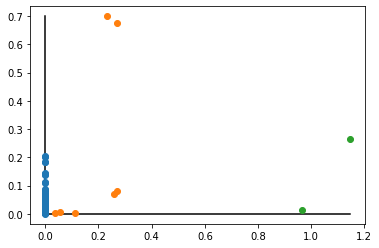

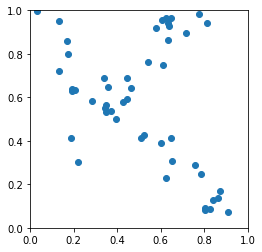

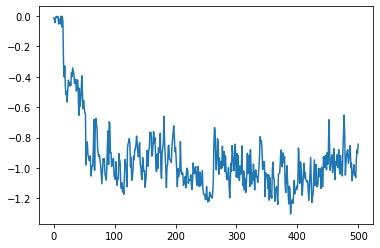


Training finished.


In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 49,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.05,
              init_phases = 'normal',
                bTranspose = True

            )
print(time.time()-t0)
model1.train()

-0.01170361042022705
-1.3035688400268555


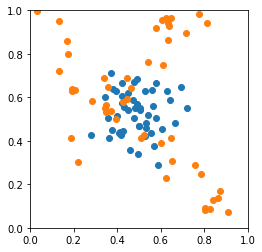

In [64]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

#### Init_phases = 'uniform'

##### 4 neurons, lr 0.01

0.011966228485107422
tensor(-0.2148, grad_fn=<RsubBackward1>)

run=0, time=0.49s


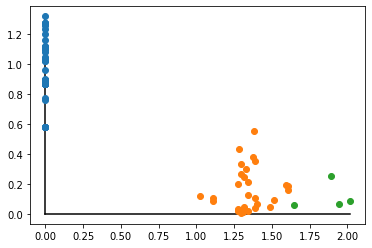

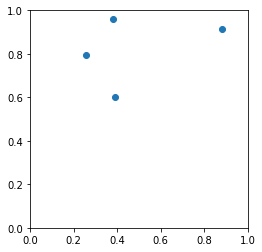

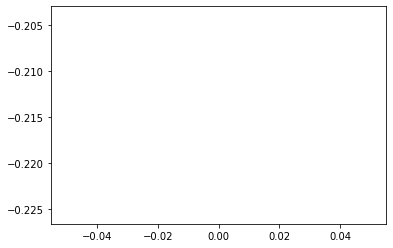


tensor(-0.4504, grad_fn=<RsubBackward1>)

tensor(-0.3929, grad_fn=<RsubBackward1>)

tensor(-0.4380, grad_fn=<RsubBackward1>)

tensor(-0.4280, grad_fn=<RsubBackward1>)

tensor(-0.5152, grad_fn=<RsubBackward1>)

tensor(-0.5183, grad_fn=<RsubBackward1>)

tensor(-0.5515, grad_fn=<RsubBackward1>)

tensor(-0.5102, grad_fn=<RsubBackward1>)

tensor(-0.4732, grad_fn=<RsubBackward1>)

tensor(-0.4512, grad_fn=<RsubBackward1>)

tensor(-0.5370, grad_fn=<RsubBackward1>)

tensor(-0.5979, grad_fn=<RsubBackward1>)

tensor(-0.5508, grad_fn=<RsubBackward1>)

tensor(-0.5609, grad_fn=<RsubBackward1>)

tensor(-0.5757, grad_fn=<RsubBackward1>)

tensor(-0.5661, grad_fn=<RsubBackward1>)

tensor(-0.5216, grad_fn=<RsubBackward1>)

tensor(-0.5458, grad_fn=<RsubBackward1>)

tensor(-0.5492, grad_fn=<RsubBackward1>)

tensor(-0.5925, grad_fn=<RsubBackward1>)

tensor(-0.6092, grad_fn=<RsubBackward1>)

tensor(-0.6185, grad_fn=<RsubBackward1>)

tensor(-0.6247, grad_fn=<RsubBackward1>)

tensor(-0.5542, grad_fn=<RsubBack

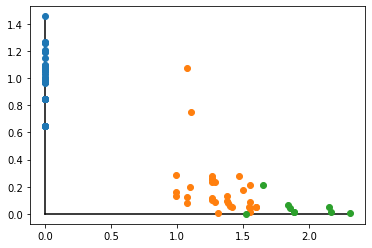

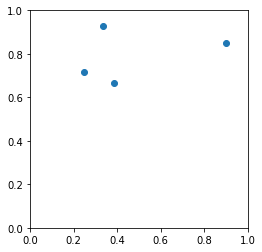

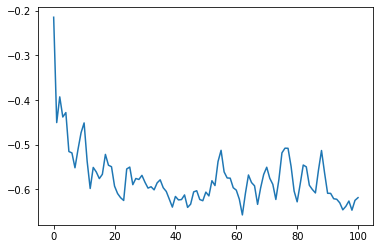


tensor(-0.6331, grad_fn=<RsubBackward1>)

tensor(-0.6310, grad_fn=<RsubBackward1>)

tensor(-0.6312, grad_fn=<RsubBackward1>)

tensor(-0.6455, grad_fn=<RsubBackward1>)

tensor(-0.6423, grad_fn=<RsubBackward1>)

tensor(-0.6442, grad_fn=<RsubBackward1>)

tensor(-0.6257, grad_fn=<RsubBackward1>)

tensor(-0.6167, grad_fn=<RsubBackward1>)

tensor(-0.6175, grad_fn=<RsubBackward1>)

tensor(-0.6325, grad_fn=<RsubBackward1>)

tensor(-0.6251, grad_fn=<RsubBackward1>)

tensor(-0.6335, grad_fn=<RsubBackward1>)

tensor(-0.6372, grad_fn=<RsubBackward1>)

tensor(-0.6435, grad_fn=<RsubBackward1>)

tensor(-0.6324, grad_fn=<RsubBackward1>)

tensor(-0.6118, grad_fn=<RsubBackward1>)

tensor(-0.5954, grad_fn=<RsubBackward1>)

tensor(-0.6058, grad_fn=<RsubBackward1>)

tensor(-0.6210, grad_fn=<RsubBackward1>)

tensor(-0.6291, grad_fn=<RsubBackward1>)

tensor(-0.6252, grad_fn=<RsubBackward1>)

tensor(-0.5634, grad_fn=<RsubBackward1>)

tensor(-0.5691, grad_fn=<RsubBackward1>)

tensor(-0.6384, grad_fn=<RsubBack

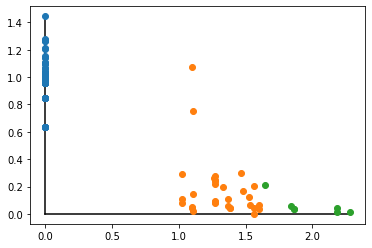

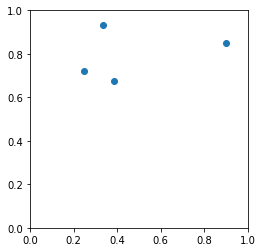

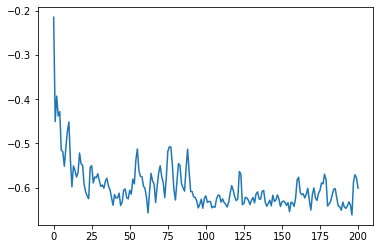


tensor(-0.5993, grad_fn=<RsubBackward1>)

tensor(-0.6059, grad_fn=<RsubBackward1>)

tensor(-0.6242, grad_fn=<RsubBackward1>)

tensor(-0.6187, grad_fn=<RsubBackward1>)

tensor(-0.6066, grad_fn=<RsubBackward1>)

tensor(-0.6208, grad_fn=<RsubBackward1>)

tensor(-0.6283, grad_fn=<RsubBackward1>)

tensor(-0.5828, grad_fn=<RsubBackward1>)

tensor(-0.5793, grad_fn=<RsubBackward1>)

tensor(-0.6203, grad_fn=<RsubBackward1>)

tensor(-0.6304, grad_fn=<RsubBackward1>)

tensor(-0.5875, grad_fn=<RsubBackward1>)

tensor(-0.5897, grad_fn=<RsubBackward1>)

tensor(-0.6316, grad_fn=<RsubBackward1>)

tensor(-0.6534, grad_fn=<RsubBackward1>)

tensor(-0.6268, grad_fn=<RsubBackward1>)

tensor(-0.6008, grad_fn=<RsubBackward1>)

tensor(-0.6168, grad_fn=<RsubBackward1>)

tensor(-0.6369, grad_fn=<RsubBackward1>)

tensor(-0.6060, grad_fn=<RsubBackward1>)

tensor(-0.5864, grad_fn=<RsubBackward1>)

tensor(-0.6120, grad_fn=<RsubBackward1>)

tensor(-0.6055, grad_fn=<RsubBackward1>)

tensor(-0.6028, grad_fn=<RsubBack

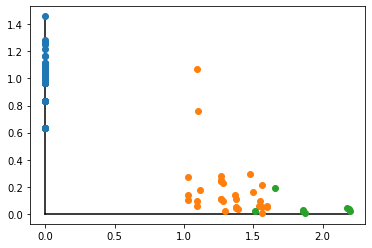

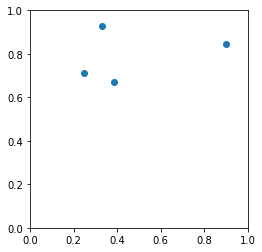

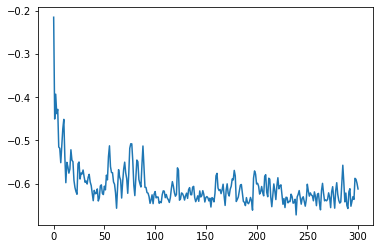


tensor(-0.6439, grad_fn=<RsubBackward1>)

tensor(-0.6529, grad_fn=<RsubBackward1>)

tensor(-0.6457, grad_fn=<RsubBackward1>)

tensor(-0.6415, grad_fn=<RsubBackward1>)

tensor(-0.6413, grad_fn=<RsubBackward1>)

tensor(-0.5842, grad_fn=<RsubBackward1>)

tensor(-0.5712, grad_fn=<RsubBackward1>)

tensor(-0.6113, grad_fn=<RsubBackward1>)

tensor(-0.6386, grad_fn=<RsubBackward1>)

tensor(-0.6431, grad_fn=<RsubBackward1>)

tensor(-0.6137, grad_fn=<RsubBackward1>)

tensor(-0.6219, grad_fn=<RsubBackward1>)

tensor(-0.6334, grad_fn=<RsubBackward1>)

tensor(-0.6425, grad_fn=<RsubBackward1>)

tensor(-0.6204, grad_fn=<RsubBackward1>)

tensor(-0.6260, grad_fn=<RsubBackward1>)

tensor(-0.6476, grad_fn=<RsubBackward1>)

tensor(-0.6335, grad_fn=<RsubBackward1>)

tensor(-0.6343, grad_fn=<RsubBackward1>)

tensor(-0.6481, grad_fn=<RsubBackward1>)

tensor(-0.6472, grad_fn=<RsubBackward1>)

tensor(-0.6467, grad_fn=<RsubBackward1>)

tensor(-0.6570, grad_fn=<RsubBackward1>)

tensor(-0.6669, grad_fn=<RsubBack

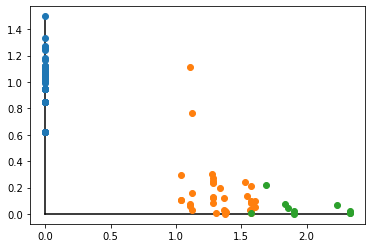

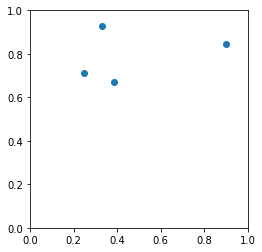

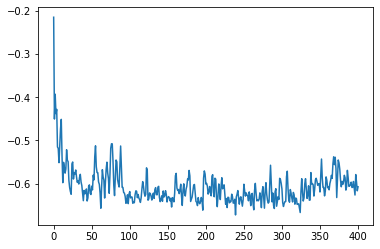


tensor(-0.6195, grad_fn=<RsubBackward1>)

tensor(-0.6007, grad_fn=<RsubBackward1>)

tensor(-0.6306, grad_fn=<RsubBackward1>)

tensor(-0.6338, grad_fn=<RsubBackward1>)

tensor(-0.6363, grad_fn=<RsubBackward1>)

tensor(-0.6492, grad_fn=<RsubBackward1>)

tensor(-0.6463, grad_fn=<RsubBackward1>)

tensor(-0.6167, grad_fn=<RsubBackward1>)

tensor(-0.6368, grad_fn=<RsubBackward1>)

tensor(-0.6336, grad_fn=<RsubBackward1>)

tensor(-0.6166, grad_fn=<RsubBackward1>)

tensor(-0.6175, grad_fn=<RsubBackward1>)

tensor(-0.5990, grad_fn=<RsubBackward1>)

tensor(-0.6039, grad_fn=<RsubBackward1>)

tensor(-0.6279, grad_fn=<RsubBackward1>)

tensor(-0.5915, grad_fn=<RsubBackward1>)

tensor(-0.5532, grad_fn=<RsubBackward1>)

tensor(-0.5669, grad_fn=<RsubBackward1>)

tensor(-0.6069, grad_fn=<RsubBackward1>)

tensor(-0.6026, grad_fn=<RsubBackward1>)

tensor(-0.6110, grad_fn=<RsubBackward1>)

tensor(-0.5591, grad_fn=<RsubBackward1>)

tensor(-0.5246, grad_fn=<RsubBackward1>)

tensor(-0.5902, grad_fn=<RsubBack

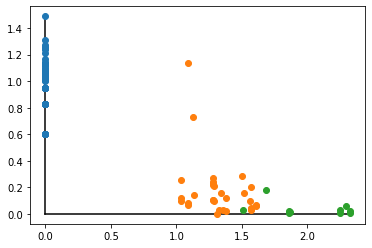

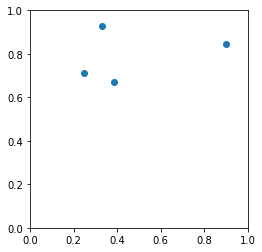

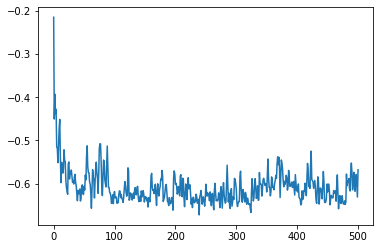


Training finished.


In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 4,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.01,
              init_phases = 'uniform',
              bTranspose = False
            )
print(time.time()-t0)
model1.train()

-0.21481215953826904
-0.6724424362182617


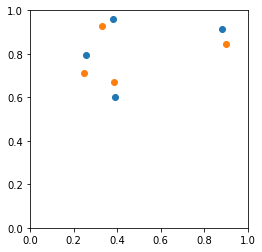

In [73]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 4 neurons, lr 0.05

0.004000663757324219
tensor(-0.2148, grad_fn=<RsubBackward1>)

run=0, time=0.40s


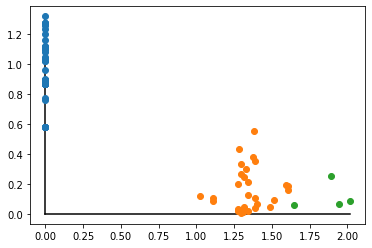

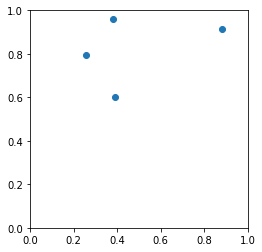

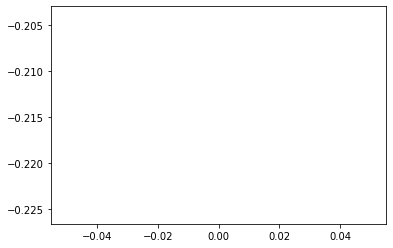


tensor(-0.1155, grad_fn=<RsubBackward1>)

tensor(-0.0875, grad_fn=<RsubBackward1>)

tensor(-0.2853, grad_fn=<RsubBackward1>)

tensor(-0.0414, grad_fn=<RsubBackward1>)

tensor(-0.1029, grad_fn=<RsubBackward1>)

tensor(-0.0419, grad_fn=<RsubBackward1>)

tensor(-0.0914, grad_fn=<RsubBackward1>)

tensor(-0.0435, grad_fn=<RsubBackward1>)

tensor(-0.0177, grad_fn=<RsubBackward1>)

tensor(-0.0049, grad_fn=<RsubBackward1>)

tensor(-0.1202, grad_fn=<RsubBackward1>)

tensor(-0.1058, grad_fn=<RsubBackward1>)

tensor(-0.1387, grad_fn=<RsubBackward1>)

tensor(-0.0520, grad_fn=<RsubBackward1>)

tensor(-0.0497, grad_fn=<RsubBackward1>)

tensor(-0.0581, grad_fn=<RsubBackward1>)

tensor(-0.1352, grad_fn=<RsubBackward1>)

tensor(-0.0023, grad_fn=<RsubBackward1>)

tensor(-0.0060, grad_fn=<RsubBackward1>)

tensor(-0.0094, grad_fn=<RsubBackward1>)

tensor(-0.0864, grad_fn=<RsubBackward1>)

tensor(-0.0285, grad_fn=<RsubBackward1>)

tensor(-0.2002, grad_fn=<RsubBackward1>)

tensor(-0.1306, grad_fn=<RsubBack

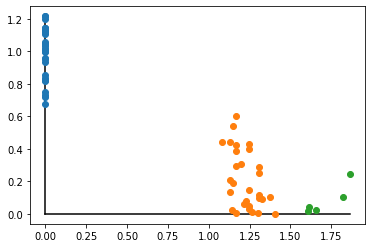

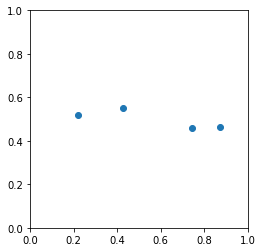

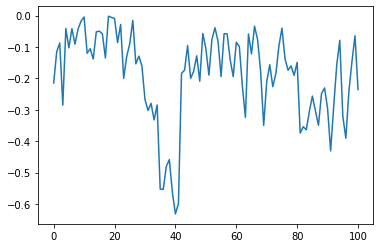


tensor(-0.2598, grad_fn=<RsubBackward1>)

tensor(-0.2218, grad_fn=<RsubBackward1>)

tensor(-0.2539, grad_fn=<RsubBackward1>)

tensor(-0.2747, grad_fn=<RsubBackward1>)

tensor(-0.3809, grad_fn=<RsubBackward1>)

tensor(-0.5441, grad_fn=<RsubBackward1>)

tensor(-0.4945, grad_fn=<RsubBackward1>)

tensor(-0.4924, grad_fn=<RsubBackward1>)

tensor(-0.3125, grad_fn=<RsubBackward1>)

tensor(-0.4599, grad_fn=<RsubBackward1>)

tensor(-0.3640, grad_fn=<RsubBackward1>)

tensor(-0.4501, grad_fn=<RsubBackward1>)

tensor(-0.3321, grad_fn=<RsubBackward1>)

tensor(-0.3740, grad_fn=<RsubBackward1>)

tensor(-0.2281, grad_fn=<RsubBackward1>)

tensor(-0.3649, grad_fn=<RsubBackward1>)

tensor(-0.3134, grad_fn=<RsubBackward1>)

tensor(-0.2404, grad_fn=<RsubBackward1>)

tensor(-0.3259, grad_fn=<RsubBackward1>)

tensor(-0.2915, grad_fn=<RsubBackward1>)

tensor(-0.3660, grad_fn=<RsubBackward1>)

tensor(-0.4829, grad_fn=<RsubBackward1>)

tensor(-0.4566, grad_fn=<RsubBackward1>)

tensor(-0.3627, grad_fn=<RsubBack

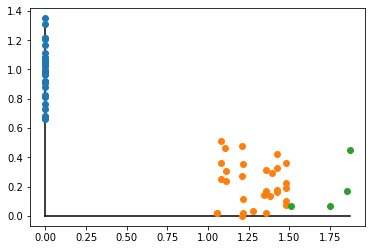

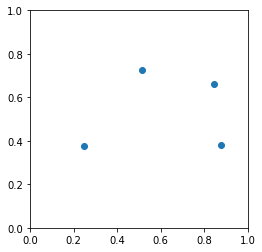

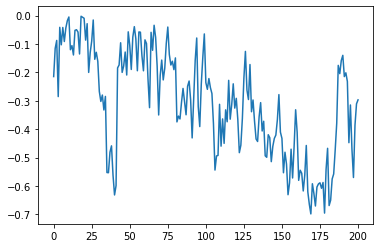


tensor(-0.1881, grad_fn=<RsubBackward1>)

tensor(-0.2271, grad_fn=<RsubBackward1>)

tensor(-0.2269, grad_fn=<RsubBackward1>)

tensor(-0.3489, grad_fn=<RsubBackward1>)

tensor(-0.3107, grad_fn=<RsubBackward1>)

tensor(-0.2148, grad_fn=<RsubBackward1>)

tensor(-0.2941, grad_fn=<RsubBackward1>)

tensor(-0.3989, grad_fn=<RsubBackward1>)

tensor(-0.1785, grad_fn=<RsubBackward1>)

tensor(-0.2525, grad_fn=<RsubBackward1>)

tensor(-0.1673, grad_fn=<RsubBackward1>)

tensor(-0.2424, grad_fn=<RsubBackward1>)

tensor(-0.2947, grad_fn=<RsubBackward1>)

tensor(-0.3284, grad_fn=<RsubBackward1>)

tensor(-0.1680, grad_fn=<RsubBackward1>)

tensor(-0.1160, grad_fn=<RsubBackward1>)

tensor(-0.0758, grad_fn=<RsubBackward1>)

tensor(-0.2051, grad_fn=<RsubBackward1>)

tensor(-0.0728, grad_fn=<RsubBackward1>)

tensor(-0.3518, grad_fn=<RsubBackward1>)

tensor(-0.0288, grad_fn=<RsubBackward1>)

tensor(-0.1251, grad_fn=<RsubBackward1>)

tensor(-0.1207, grad_fn=<RsubBackward1>)

tensor(-0.0174, grad_fn=<RsubBack

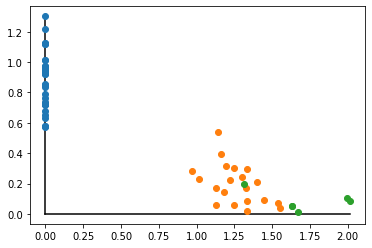

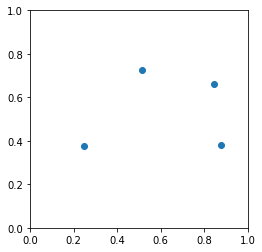

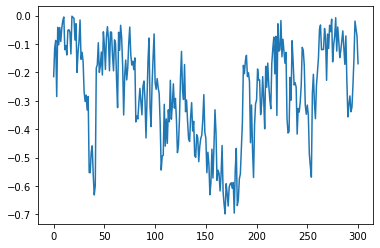


tensor(-0.1678, grad_fn=<RsubBackward1>)

tensor(-0.2543, grad_fn=<RsubBackward1>)

tensor(-0.2705, grad_fn=<RsubBackward1>)

tensor(-0.1388, grad_fn=<RsubBackward1>)

tensor(-0.1740, grad_fn=<RsubBackward1>)

tensor(-0.1780, grad_fn=<RsubBackward1>)

tensor(-0.2456, grad_fn=<RsubBackward1>)

tensor(-0.1912, grad_fn=<RsubBackward1>)

tensor(-0.2259, grad_fn=<RsubBackward1>)

tensor(-0.1364, grad_fn=<RsubBackward1>)

tensor(-0.1062, grad_fn=<RsubBackward1>)

tensor(-0.0590, grad_fn=<RsubBackward1>)

tensor(-0.1319, grad_fn=<RsubBackward1>)

tensor(-0.2198, grad_fn=<RsubBackward1>)

tensor(-0.0725, grad_fn=<RsubBackward1>)

tensor(-0.2402, grad_fn=<RsubBackward1>)

tensor(-0.1414, grad_fn=<RsubBackward1>)

tensor(-0.0813, grad_fn=<RsubBackward1>)

tensor(-0.1697, grad_fn=<RsubBackward1>)

tensor(-0.2633, grad_fn=<RsubBackward1>)

tensor(-0.1501, grad_fn=<RsubBackward1>)

tensor(-0.0301, grad_fn=<RsubBackward1>)

tensor(-0.1064, grad_fn=<RsubBackward1>)

tensor(-0.2787, grad_fn=<RsubBack

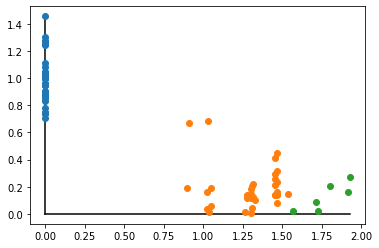

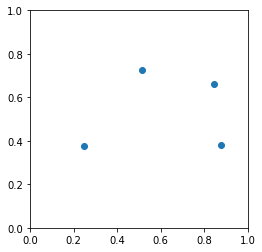

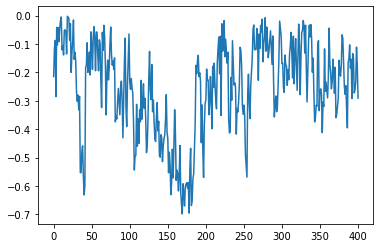


tensor(-0.3196, grad_fn=<RsubBackward1>)

tensor(-0.3318, grad_fn=<RsubBackward1>)

tensor(-0.3433, grad_fn=<RsubBackward1>)

tensor(-0.5387, grad_fn=<RsubBackward1>)

tensor(-0.1800, grad_fn=<RsubBackward1>)

tensor(-0.0933, grad_fn=<RsubBackward1>)

tensor(-0.0301, grad_fn=<RsubBackward1>)

tensor(-0.1138, grad_fn=<RsubBackward1>)

tensor(-0.0996, grad_fn=<RsubBackward1>)

tensor(-0.1012, grad_fn=<RsubBackward1>)

tensor(-0.1037, grad_fn=<RsubBackward1>)

tensor(-0.1229, grad_fn=<RsubBackward1>)

tensor(-0.1679, grad_fn=<RsubBackward1>)

tensor(-0.2328, grad_fn=<RsubBackward1>)

tensor(-0.2094, grad_fn=<RsubBackward1>)

tensor(-0.1931, grad_fn=<RsubBackward1>)

tensor(-0.2659, grad_fn=<RsubBackward1>)

tensor(-0.4131, grad_fn=<RsubBackward1>)

tensor(-0.3554, grad_fn=<RsubBackward1>)

tensor(-0.1727, grad_fn=<RsubBackward1>)

tensor(-0.1536, grad_fn=<RsubBackward1>)

tensor(-0.2201, grad_fn=<RsubBackward1>)

tensor(-0.3367, grad_fn=<RsubBackward1>)

tensor(-0.3112, grad_fn=<RsubBack

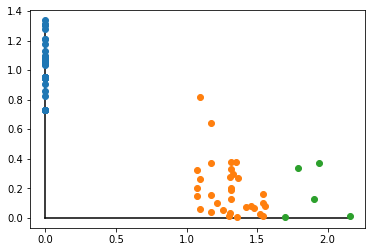

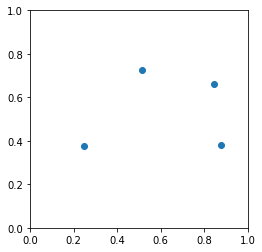

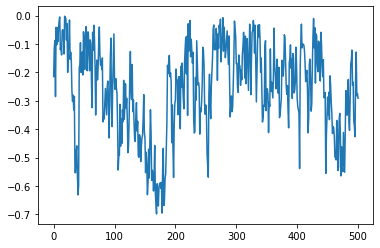


Training finished.


In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 4,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.05,
              init_phases = 'uniform',
              bTranspose = False
            )
print(time.time()-t0)
model1.train()

-0.21481215953826904
-0.698609471321106


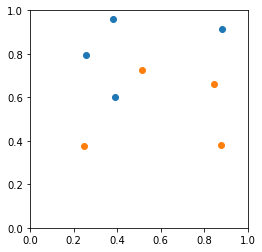

In [75]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.05

0.0030024051666259766
tensor(-5.4432, grad_fn=<RsubBackward1>)

run=0, time=0.43s


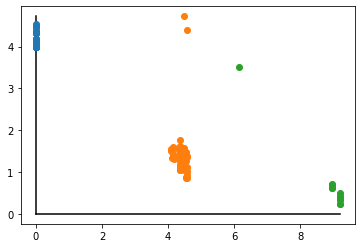

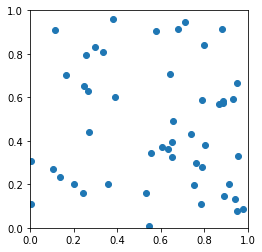

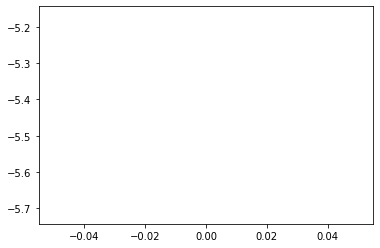


tensor(-2.6943, grad_fn=<RsubBackward1>)

tensor(-2.9751, grad_fn=<RsubBackward1>)

tensor(-3.0855, grad_fn=<RsubBackward1>)

tensor(-3.0972, grad_fn=<RsubBackward1>)

tensor(-2.8345, grad_fn=<RsubBackward1>)

tensor(-4.0240, grad_fn=<RsubBackward1>)

tensor(-5.3987, grad_fn=<RsubBackward1>)

tensor(-6.2493, grad_fn=<RsubBackward1>)

tensor(-5.6025, grad_fn=<RsubBackward1>)

tensor(-4.8688, grad_fn=<RsubBackward1>)

tensor(-5.0819, grad_fn=<RsubBackward1>)

tensor(-5.4581, grad_fn=<RsubBackward1>)

tensor(-5.6311, grad_fn=<RsubBackward1>)

tensor(-5.3866, grad_fn=<RsubBackward1>)

tensor(-5.0837, grad_fn=<RsubBackward1>)

tensor(-5.3823, grad_fn=<RsubBackward1>)

tensor(-5.8628, grad_fn=<RsubBackward1>)

tensor(-5.5092, grad_fn=<RsubBackward1>)

tensor(-5.5930, grad_fn=<RsubBackward1>)

tensor(-5.3847, grad_fn=<RsubBackward1>)

tensor(-5.4515, grad_fn=<RsubBackward1>)

tensor(-5.5579, grad_fn=<RsubBackward1>)

tensor(-5.4162, grad_fn=<RsubBackward1>)

tensor(-5.0311, grad_fn=<RsubBack

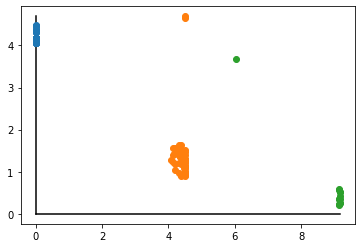

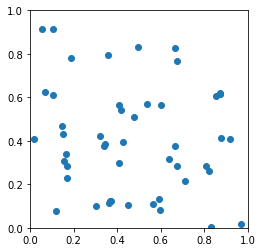

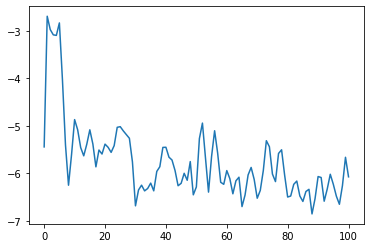


tensor(-5.7468, grad_fn=<RsubBackward1>)

tensor(-5.6986, grad_fn=<RsubBackward1>)

tensor(-5.9301, grad_fn=<RsubBackward1>)

tensor(-6.0468, grad_fn=<RsubBackward1>)

tensor(-6.2784, grad_fn=<RsubBackward1>)

tensor(-6.0778, grad_fn=<RsubBackward1>)

tensor(-6.0147, grad_fn=<RsubBackward1>)

tensor(-6.0243, grad_fn=<RsubBackward1>)

tensor(-6.5425, grad_fn=<RsubBackward1>)

tensor(-6.5840, grad_fn=<RsubBackward1>)

tensor(-6.1981, grad_fn=<RsubBackward1>)

tensor(-6.2719, grad_fn=<RsubBackward1>)

tensor(-6.3482, grad_fn=<RsubBackward1>)

tensor(-6.5718, grad_fn=<RsubBackward1>)

tensor(-6.4514, grad_fn=<RsubBackward1>)

tensor(-6.6872, grad_fn=<RsubBackward1>)

tensor(-6.5273, grad_fn=<RsubBackward1>)

tensor(-5.9226, grad_fn=<RsubBackward1>)

tensor(-5.9329, grad_fn=<RsubBackward1>)

tensor(-6.2862, grad_fn=<RsubBackward1>)

tensor(-6.0449, grad_fn=<RsubBackward1>)

tensor(-6.1328, grad_fn=<RsubBackward1>)

tensor(-5.9245, grad_fn=<RsubBackward1>)

tensor(-5.8887, grad_fn=<RsubBack

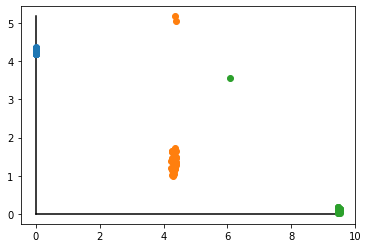

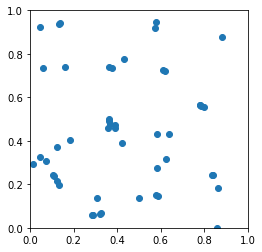

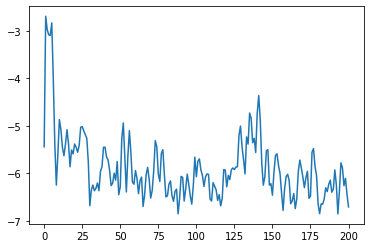


tensor(-6.2919, grad_fn=<RsubBackward1>)

tensor(-6.1035, grad_fn=<RsubBackward1>)

tensor(-5.9682, grad_fn=<RsubBackward1>)

tensor(-6.2357, grad_fn=<RsubBackward1>)

tensor(-6.4893, grad_fn=<RsubBackward1>)

tensor(-6.2798, grad_fn=<RsubBackward1>)

tensor(-6.1807, grad_fn=<RsubBackward1>)

tensor(-6.4156, grad_fn=<RsubBackward1>)

tensor(-6.3153, grad_fn=<RsubBackward1>)

tensor(-6.3975, grad_fn=<RsubBackward1>)

tensor(-6.2824, grad_fn=<RsubBackward1>)

tensor(-5.3672, grad_fn=<RsubBackward1>)

tensor(-5.2868, grad_fn=<RsubBackward1>)

tensor(-6.3519, grad_fn=<RsubBackward1>)

tensor(-5.7926, grad_fn=<RsubBackward1>)

tensor(-5.1921, grad_fn=<RsubBackward1>)

tensor(-5.3169, grad_fn=<RsubBackward1>)

tensor(-5.4780, grad_fn=<RsubBackward1>)

tensor(-5.9830, grad_fn=<RsubBackward1>)

tensor(-5.7119, grad_fn=<RsubBackward1>)

tensor(-5.5502, grad_fn=<RsubBackward1>)

tensor(-5.5431, grad_fn=<RsubBackward1>)

tensor(-5.5207, grad_fn=<RsubBackward1>)

tensor(-5.9641, grad_fn=<RsubBack

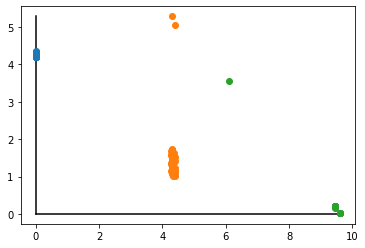

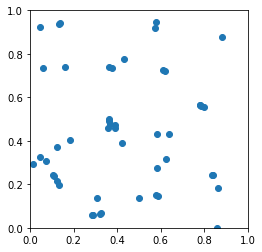

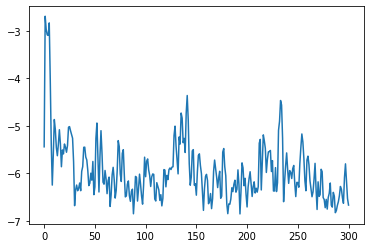


tensor(-6.4386, grad_fn=<RsubBackward1>)

tensor(-6.0860, grad_fn=<RsubBackward1>)

tensor(-5.9739, grad_fn=<RsubBackward1>)

tensor(-6.3240, grad_fn=<RsubBackward1>)

tensor(-6.2076, grad_fn=<RsubBackward1>)

tensor(-6.3687, grad_fn=<RsubBackward1>)

tensor(-6.4129, grad_fn=<RsubBackward1>)

tensor(-6.5547, grad_fn=<RsubBackward1>)

tensor(-6.5441, grad_fn=<RsubBackward1>)

tensor(-6.6509, grad_fn=<RsubBackward1>)

tensor(-6.6936, grad_fn=<RsubBackward1>)

tensor(-6.5367, grad_fn=<RsubBackward1>)

tensor(-6.0910, grad_fn=<RsubBackward1>)

tensor(-6.3978, grad_fn=<RsubBackward1>)

tensor(-6.5956, grad_fn=<RsubBackward1>)

tensor(-6.1178, grad_fn=<RsubBackward1>)

tensor(-5.7085, grad_fn=<RsubBackward1>)

tensor(-5.7933, grad_fn=<RsubBackward1>)

tensor(-5.9785, grad_fn=<RsubBackward1>)

tensor(-6.4748, grad_fn=<RsubBackward1>)

tensor(-6.7092, grad_fn=<RsubBackward1>)

tensor(-6.6140, grad_fn=<RsubBackward1>)

tensor(-6.0065, grad_fn=<RsubBackward1>)

tensor(-6.2602, grad_fn=<RsubBack

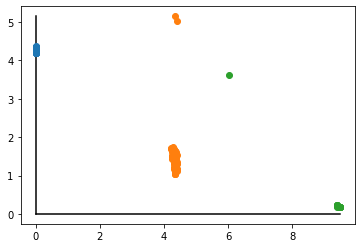

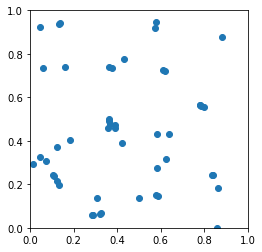

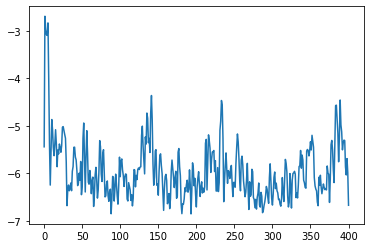


tensor(-5.8667, grad_fn=<RsubBackward1>)

tensor(-5.1567, grad_fn=<RsubBackward1>)

tensor(-5.4165, grad_fn=<RsubBackward1>)

tensor(-5.7958, grad_fn=<RsubBackward1>)

tensor(-5.8534, grad_fn=<RsubBackward1>)

tensor(-4.9025, grad_fn=<RsubBackward1>)

tensor(-4.8776, grad_fn=<RsubBackward1>)

tensor(-5.3738, grad_fn=<RsubBackward1>)

tensor(-4.9844, grad_fn=<RsubBackward1>)

tensor(-5.6051, grad_fn=<RsubBackward1>)

tensor(-5.7351, grad_fn=<RsubBackward1>)

tensor(-6.1909, grad_fn=<RsubBackward1>)

tensor(-6.1672, grad_fn=<RsubBackward1>)

tensor(-5.0733, grad_fn=<RsubBackward1>)

tensor(-4.3396, grad_fn=<RsubBackward1>)

tensor(-4.4902, grad_fn=<RsubBackward1>)

tensor(-5.5236, grad_fn=<RsubBackward1>)

tensor(-6.1342, grad_fn=<RsubBackward1>)

tensor(-4.9804, grad_fn=<RsubBackward1>)

tensor(-4.3838, grad_fn=<RsubBackward1>)

tensor(-4.2583, grad_fn=<RsubBackward1>)

tensor(-4.2783, grad_fn=<RsubBackward1>)

tensor(-5.0793, grad_fn=<RsubBackward1>)

tensor(-5.7033, grad_fn=<RsubBack

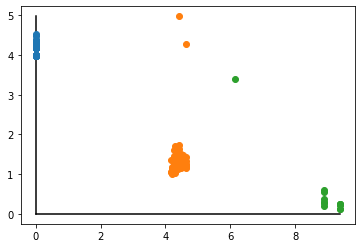

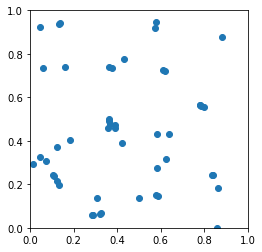

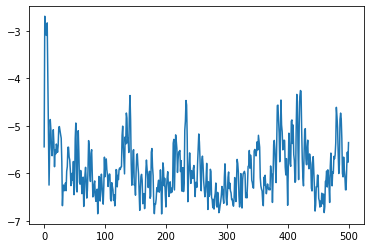


Training finished.


In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                   ks_sqr,
                   non_negative = False,
              N = 49,
              maxdim = 2,
              batch_size = 49,
              epochs = 5,
              train_steps = 100,
              lr = 0.05,
              init_phases = 'uniform',
              bTranspose = False
            )
print(time.time()-t0)
model1.train()

-5.443170547485352
-6.85621452331543


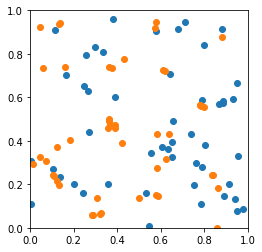

In [83]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

-5.443170547485352
-6.85621452331543


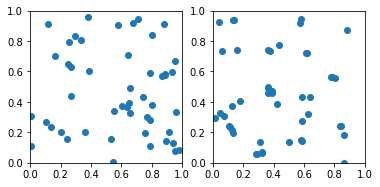

In [86]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,2)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].scatter(p0[:,0],p0[:,1])
ax[0].set_aspect('equal', 'box')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].scatter(p1[:,0],p1[:,1])
ax[1].set_aspect('equal', 'box')

### Score = sum

#### Init_phase = Normal

##### 4 neurons, lr 0.01

0.0029993057250976562
tensor(-1.1688, grad_fn=<SubBackward0>)

run=0, time=0.37s


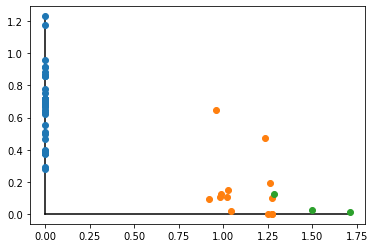

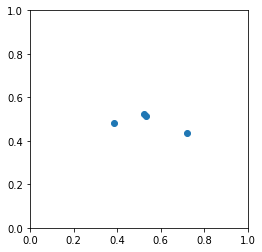

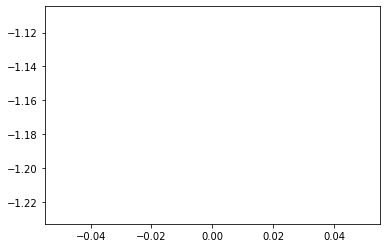


tensor(-1.2599, grad_fn=<SubBackward0>)

tensor(-1.2377, grad_fn=<SubBackward0>)

tensor(-1.1274, grad_fn=<SubBackward0>)

tensor(-1.1584, grad_fn=<SubBackward0>)

tensor(-1.1301, grad_fn=<SubBackward0>)

tensor(-1.1704, grad_fn=<SubBackward0>)

tensor(-1.2828, grad_fn=<SubBackward0>)

tensor(-1.3177, grad_fn=<SubBackward0>)

tensor(-1.3242, grad_fn=<SubBackward0>)

tensor(-1.2685, grad_fn=<SubBackward0>)

tensor(-1.2439, grad_fn=<SubBackward0>)

tensor(-1.2200, grad_fn=<SubBackward0>)

tensor(-1.2891, grad_fn=<SubBackward0>)

tensor(-1.2342, grad_fn=<SubBackward0>)

tensor(-1.2013, grad_fn=<SubBackward0>)

tensor(-1.2832, grad_fn=<SubBackward0>)

tensor(-1.3625, grad_fn=<SubBackward0>)

tensor(-1.3457, grad_fn=<SubBackward0>)

tensor(-1.3369, grad_fn=<SubBackward0>)

tensor(-1.3545, grad_fn=<SubBackward0>)

tensor(-1.3324, grad_fn=<SubBackward0>)

tensor(-1.3377, grad_fn=<SubBackward0>)

tensor(-1.3749, grad_fn=<SubBackward0>)

tensor(-1.3397, grad_fn=<SubBackward0>)

tensor(-1.3241,

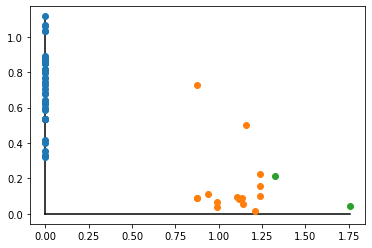

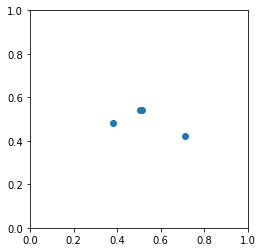

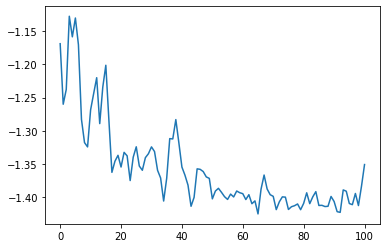


tensor(-1.3783, grad_fn=<SubBackward0>)

tensor(-1.4027, grad_fn=<SubBackward0>)

tensor(-1.4043, grad_fn=<SubBackward0>)

tensor(-1.4021, grad_fn=<SubBackward0>)

tensor(-1.4011, grad_fn=<SubBackward0>)

tensor(-1.3941, grad_fn=<SubBackward0>)

tensor(-1.4175, grad_fn=<SubBackward0>)

tensor(-1.3890, grad_fn=<SubBackward0>)

tensor(-1.3763, grad_fn=<SubBackward0>)

tensor(-1.3911, grad_fn=<SubBackward0>)

tensor(-1.3957, grad_fn=<SubBackward0>)

tensor(-1.3833, grad_fn=<SubBackward0>)

tensor(-1.3645, grad_fn=<SubBackward0>)

tensor(-1.3728, grad_fn=<SubBackward0>)

tensor(-1.3903, grad_fn=<SubBackward0>)

tensor(-1.3820, grad_fn=<SubBackward0>)

tensor(-1.3774, grad_fn=<SubBackward0>)

tensor(-1.3899, grad_fn=<SubBackward0>)

tensor(-1.4018, grad_fn=<SubBackward0>)

tensor(-1.3988, grad_fn=<SubBackward0>)

tensor(-1.4013, grad_fn=<SubBackward0>)

tensor(-1.3974, grad_fn=<SubBackward0>)

tensor(-1.4265, grad_fn=<SubBackward0>)

tensor(-1.3991, grad_fn=<SubBackward0>)

tensor(-1.4028,

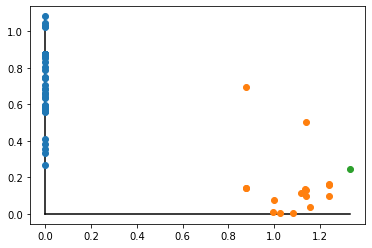

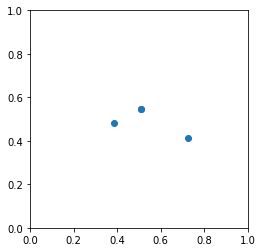

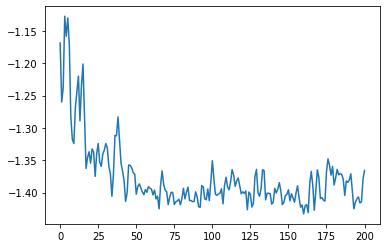


tensor(-1.3455, grad_fn=<SubBackward0>)

tensor(-1.3574, grad_fn=<SubBackward0>)

tensor(-1.3865, grad_fn=<SubBackward0>)

tensor(-1.4123, grad_fn=<SubBackward0>)

tensor(-1.4159, grad_fn=<SubBackward0>)

tensor(-1.4149, grad_fn=<SubBackward0>)

tensor(-1.4292, grad_fn=<SubBackward0>)

tensor(-1.4261, grad_fn=<SubBackward0>)

tensor(-1.4266, grad_fn=<SubBackward0>)

tensor(-1.4259, grad_fn=<SubBackward0>)

tensor(-1.4314, grad_fn=<SubBackward0>)

tensor(-1.4222, grad_fn=<SubBackward0>)

tensor(-1.4176, grad_fn=<SubBackward0>)

tensor(-1.4255, grad_fn=<SubBackward0>)

tensor(-1.4248, grad_fn=<SubBackward0>)

tensor(-1.4206, grad_fn=<SubBackward0>)

tensor(-1.4225, grad_fn=<SubBackward0>)

tensor(-1.4177, grad_fn=<SubBackward0>)

tensor(-1.4202, grad_fn=<SubBackward0>)

tensor(-1.4180, grad_fn=<SubBackward0>)

tensor(-1.4301, grad_fn=<SubBackward0>)

tensor(-1.4284, grad_fn=<SubBackward0>)

tensor(-1.4259, grad_fn=<SubBackward0>)

tensor(-1.4269, grad_fn=<SubBackward0>)

tensor(-1.4173,

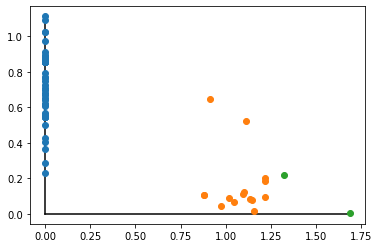

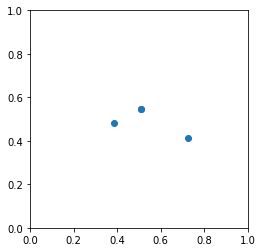

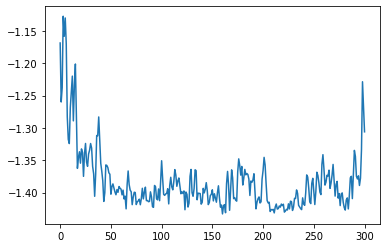


tensor(-1.3863, grad_fn=<SubBackward0>)

tensor(-1.3835, grad_fn=<SubBackward0>)

tensor(-1.3363, grad_fn=<SubBackward0>)

tensor(-1.3486, grad_fn=<SubBackward0>)

tensor(-1.3545, grad_fn=<SubBackward0>)

tensor(-1.3724, grad_fn=<SubBackward0>)

tensor(-1.3952, grad_fn=<SubBackward0>)

tensor(-1.3952, grad_fn=<SubBackward0>)

tensor(-1.3794, grad_fn=<SubBackward0>)

tensor(-1.3766, grad_fn=<SubBackward0>)

tensor(-1.3846, grad_fn=<SubBackward0>)

tensor(-1.4219, grad_fn=<SubBackward0>)

tensor(-1.3847, grad_fn=<SubBackward0>)

tensor(-1.3495, grad_fn=<SubBackward0>)

tensor(-1.3824, grad_fn=<SubBackward0>)

tensor(-1.4234, grad_fn=<SubBackward0>)

tensor(-1.3969, grad_fn=<SubBackward0>)

tensor(-1.4079, grad_fn=<SubBackward0>)

tensor(-1.3735, grad_fn=<SubBackward0>)

tensor(-1.3738, grad_fn=<SubBackward0>)

tensor(-1.4082, grad_fn=<SubBackward0>)

tensor(-1.3769, grad_fn=<SubBackward0>)

tensor(-1.3724, grad_fn=<SubBackward0>)

tensor(-1.3421, grad_fn=<SubBackward0>)

tensor(-1.3401,

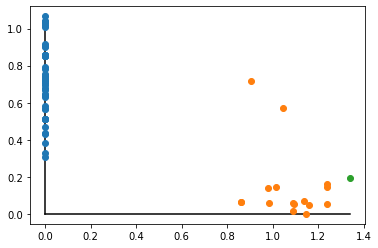

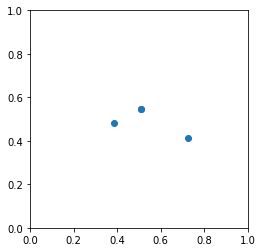

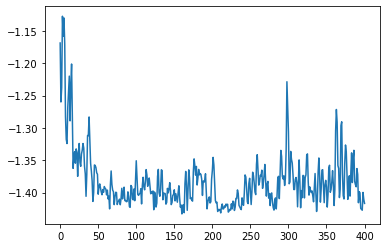


tensor(-1.3758, grad_fn=<SubBackward0>)

tensor(-1.3850, grad_fn=<SubBackward0>)

tensor(-1.3736, grad_fn=<SubBackward0>)

tensor(-1.3645, grad_fn=<SubBackward0>)

tensor(-1.3958, grad_fn=<SubBackward0>)

tensor(-1.3598, grad_fn=<SubBackward0>)

tensor(-1.3721, grad_fn=<SubBackward0>)

tensor(-1.4035, grad_fn=<SubBackward0>)

tensor(-1.2859, grad_fn=<SubBackward0>)

tensor(-1.2708, grad_fn=<SubBackward0>)

tensor(-1.2773, grad_fn=<SubBackward0>)

tensor(-1.2822, grad_fn=<SubBackward0>)

tensor(-1.3340, grad_fn=<SubBackward0>)

tensor(-1.3571, grad_fn=<SubBackward0>)

tensor(-1.3566, grad_fn=<SubBackward0>)

tensor(-1.3570, grad_fn=<SubBackward0>)

tensor(-1.3735, grad_fn=<SubBackward0>)

tensor(-1.3477, grad_fn=<SubBackward0>)

tensor(-1.3386, grad_fn=<SubBackward0>)

tensor(-1.3633, grad_fn=<SubBackward0>)

tensor(-1.3788, grad_fn=<SubBackward0>)

tensor(-1.3997, grad_fn=<SubBackward0>)

tensor(-1.3618, grad_fn=<SubBackward0>)

tensor(-1.3458, grad_fn=<SubBackward0>)

tensor(-1.3495,

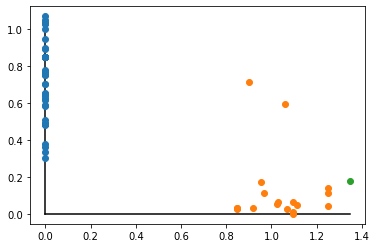

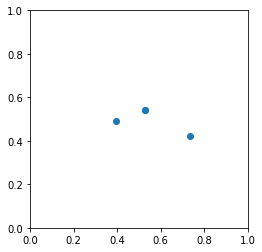

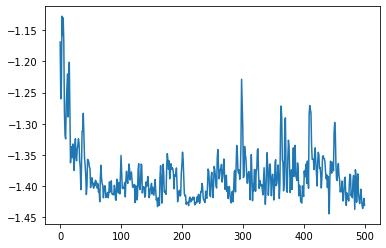


Training finished.


In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                    ks_sqr,
                    non_negative = False,
                    N = 4,
                    maxdim = 2,
                    batch_size = 49,
                    epochs = 5,
                    train_steps = 100,
                    lr = 0.01,
                    init_phases = 'normal',
                    bTranspose = False,
                    score = 'sum'

            )
print(time.time()-t0)
model1.train()

-1.168786644935608
-1.4446526765823364


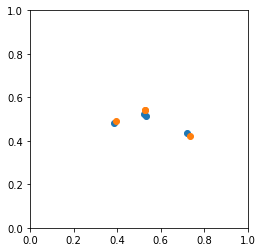

In [81]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 4 neurons, lr 0.05

0.004002094268798828
tensor(-1.1688, grad_fn=<SubBackward0>)

run=0, time=0.47s


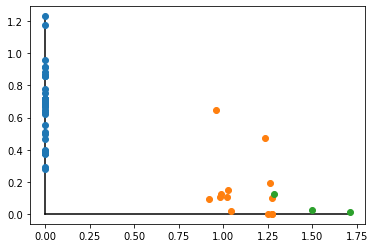

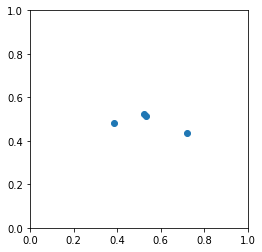

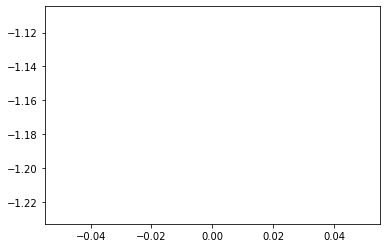


tensor(-0.9394, grad_fn=<SubBackward0>)

tensor(-0.9726, grad_fn=<SubBackward0>)

tensor(-0.8861, grad_fn=<SubBackward0>)

tensor(-0.9633, grad_fn=<SubBackward0>)

tensor(-1.0937, grad_fn=<SubBackward0>)

tensor(-0.6895, grad_fn=<SubBackward0>)

tensor(-0.7954, grad_fn=<SubBackward0>)

tensor(-0.8573, grad_fn=<SubBackward0>)

tensor(-0.8870, grad_fn=<SubBackward0>)

tensor(-0.9866, grad_fn=<SubBackward0>)

tensor(-0.9102, grad_fn=<SubBackward0>)

tensor(-1.0295, grad_fn=<SubBackward0>)

tensor(-1.0587, grad_fn=<SubBackward0>)

tensor(-1.1269, grad_fn=<SubBackward0>)

tensor(-1.1280, grad_fn=<SubBackward0>)

tensor(-0.9641, grad_fn=<SubBackward0>)

tensor(-1.1064, grad_fn=<SubBackward0>)

tensor(-1.1079, grad_fn=<SubBackward0>)

tensor(-1.1584, grad_fn=<SubBackward0>)

tensor(-1.1245, grad_fn=<SubBackward0>)

tensor(-1.1738, grad_fn=<SubBackward0>)

tensor(-1.2283, grad_fn=<SubBackward0>)

tensor(-1.2902, grad_fn=<SubBackward0>)

tensor(-1.2267, grad_fn=<SubBackward0>)

tensor(-1.1960,

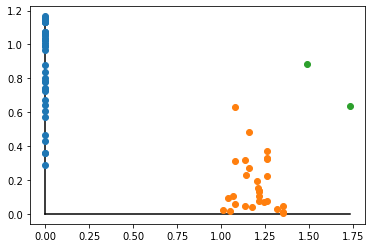

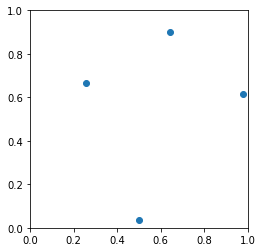

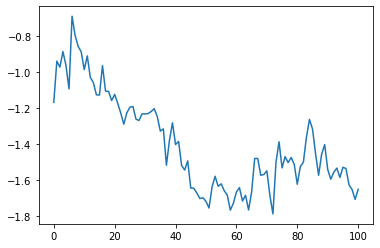


tensor(-1.5766, grad_fn=<SubBackward0>)

tensor(-1.6559, grad_fn=<SubBackward0>)

tensor(-1.6416, grad_fn=<SubBackward0>)

tensor(-1.6039, grad_fn=<SubBackward0>)

tensor(-1.6373, grad_fn=<SubBackward0>)

tensor(-1.7183, grad_fn=<SubBackward0>)

tensor(-1.7333, grad_fn=<SubBackward0>)

tensor(-1.7247, grad_fn=<SubBackward0>)

tensor(-1.7987, grad_fn=<SubBackward0>)

tensor(-1.6890, grad_fn=<SubBackward0>)

tensor(-1.6974, grad_fn=<SubBackward0>)

tensor(-1.7248, grad_fn=<SubBackward0>)

tensor(-1.7108, grad_fn=<SubBackward0>)

tensor(-1.7999, grad_fn=<SubBackward0>)

tensor(-1.7562, grad_fn=<SubBackward0>)

tensor(-1.7607, grad_fn=<SubBackward0>)

tensor(-1.8023, grad_fn=<SubBackward0>)

tensor(-1.7157, grad_fn=<SubBackward0>)

tensor(-1.6027, grad_fn=<SubBackward0>)

tensor(-1.7268, grad_fn=<SubBackward0>)

tensor(-1.8148, grad_fn=<SubBackward0>)

tensor(-1.7436, grad_fn=<SubBackward0>)

tensor(-1.7047, grad_fn=<SubBackward0>)

tensor(-1.7957, grad_fn=<SubBackward0>)

tensor(-1.7342,

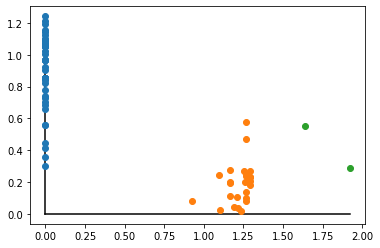

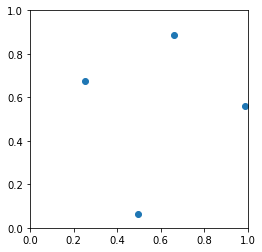

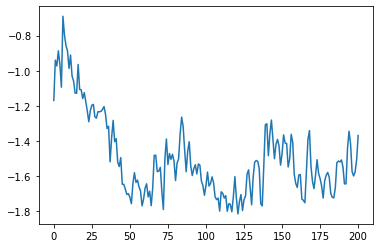


tensor(-1.2997, grad_fn=<SubBackward0>)

tensor(-1.3846, grad_fn=<SubBackward0>)

tensor(-1.4932, grad_fn=<SubBackward0>)

tensor(-1.5701, grad_fn=<SubBackward0>)

tensor(-1.6771, grad_fn=<SubBackward0>)

tensor(-1.7149, grad_fn=<SubBackward0>)

tensor(-1.5511, grad_fn=<SubBackward0>)

tensor(-1.6055, grad_fn=<SubBackward0>)

tensor(-1.6771, grad_fn=<SubBackward0>)

tensor(-1.7404, grad_fn=<SubBackward0>)

tensor(-1.5952, grad_fn=<SubBackward0>)

tensor(-1.5124, grad_fn=<SubBackward0>)

tensor(-1.5945, grad_fn=<SubBackward0>)

tensor(-1.7139, grad_fn=<SubBackward0>)

tensor(-1.7594, grad_fn=<SubBackward0>)

tensor(-1.5650, grad_fn=<SubBackward0>)

tensor(-1.5355, grad_fn=<SubBackward0>)

tensor(-1.6404, grad_fn=<SubBackward0>)

tensor(-1.6873, grad_fn=<SubBackward0>)

tensor(-1.6474, grad_fn=<SubBackward0>)

tensor(-1.6093, grad_fn=<SubBackward0>)

tensor(-1.6399, grad_fn=<SubBackward0>)

tensor(-1.5902, grad_fn=<SubBackward0>)

tensor(-1.6058, grad_fn=<SubBackward0>)

tensor(-1.6791,

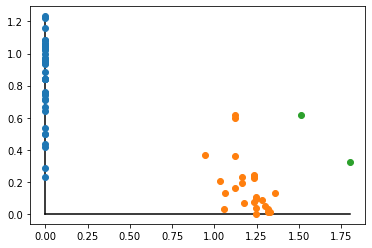

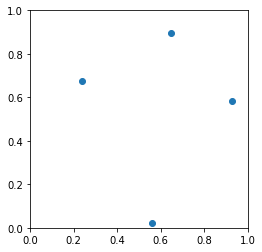

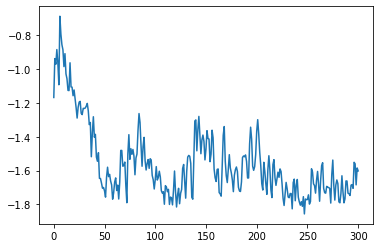


tensor(-1.5996, grad_fn=<SubBackward0>)

tensor(-1.6499, grad_fn=<SubBackward0>)

tensor(-1.6675, grad_fn=<SubBackward0>)

tensor(-1.7511, grad_fn=<SubBackward0>)

tensor(-1.7443, grad_fn=<SubBackward0>)

tensor(-1.5952, grad_fn=<SubBackward0>)

tensor(-1.6389, grad_fn=<SubBackward0>)

tensor(-1.6460, grad_fn=<SubBackward0>)

tensor(-1.6908, grad_fn=<SubBackward0>)

tensor(-1.7990, grad_fn=<SubBackward0>)

tensor(-1.7625, grad_fn=<SubBackward0>)

tensor(-1.7185, grad_fn=<SubBackward0>)

tensor(-1.7271, grad_fn=<SubBackward0>)

tensor(-1.7542, grad_fn=<SubBackward0>)

tensor(-1.7000, grad_fn=<SubBackward0>)

tensor(-1.6824, grad_fn=<SubBackward0>)

tensor(-1.7539, grad_fn=<SubBackward0>)

tensor(-1.7364, grad_fn=<SubBackward0>)

tensor(-1.7521, grad_fn=<SubBackward0>)

tensor(-1.6407, grad_fn=<SubBackward0>)

tensor(-1.6194, grad_fn=<SubBackward0>)

tensor(-1.7304, grad_fn=<SubBackward0>)

tensor(-1.7555, grad_fn=<SubBackward0>)

tensor(-1.7162, grad_fn=<SubBackward0>)

tensor(-1.8423,

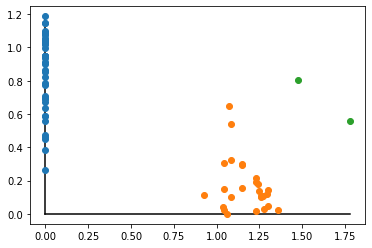

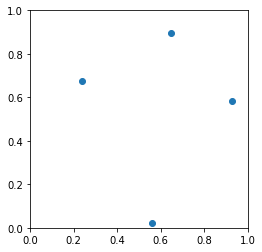

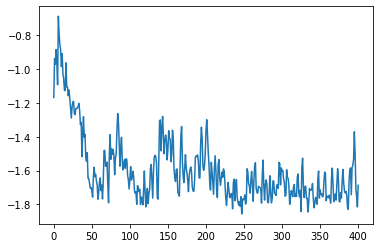


tensor(-1.7817, grad_fn=<SubBackward0>)

tensor(-1.7268, grad_fn=<SubBackward0>)

tensor(-1.7398, grad_fn=<SubBackward0>)

tensor(-1.7921, grad_fn=<SubBackward0>)

tensor(-1.7845, grad_fn=<SubBackward0>)

tensor(-1.8534, grad_fn=<SubBackward0>)

tensor(-1.7228, grad_fn=<SubBackward0>)

tensor(-1.6484, grad_fn=<SubBackward0>)

tensor(-1.7378, grad_fn=<SubBackward0>)

tensor(-1.8179, grad_fn=<SubBackward0>)

tensor(-1.8215, grad_fn=<SubBackward0>)

tensor(-1.7601, grad_fn=<SubBackward0>)

tensor(-1.7834, grad_fn=<SubBackward0>)

tensor(-1.7799, grad_fn=<SubBackward0>)

tensor(-1.7945, grad_fn=<SubBackward0>)

tensor(-1.8178, grad_fn=<SubBackward0>)

tensor(-1.6748, grad_fn=<SubBackward0>)

tensor(-1.6125, grad_fn=<SubBackward0>)

tensor(-1.7970, grad_fn=<SubBackward0>)

tensor(-1.7509, grad_fn=<SubBackward0>)

tensor(-1.6722, grad_fn=<SubBackward0>)

tensor(-1.7807, grad_fn=<SubBackward0>)

tensor(-1.6472, grad_fn=<SubBackward0>)

tensor(-1.5508, grad_fn=<SubBackward0>)

tensor(-1.6996,

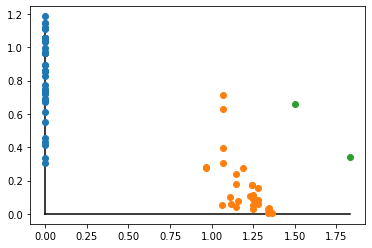

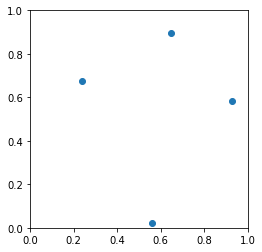

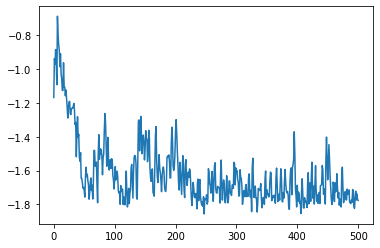


Training finished.


In [87]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                    ks_sqr,
                    non_negative = False,
                    N = 4,
                    maxdim = 2,
                    batch_size = 49,
                    epochs = 5,
                    train_steps = 100,
                    lr = 0.05,
                    init_phases = 'normal',
                    bTranspose = False,
                    score = 'sum'
            )
print(time.time()-t0)
model1.train()

-1.168786644935608
-1.8556952476501465


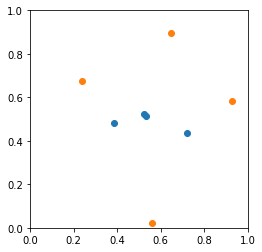

In [88]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.01

0.0030028820037841797
tensor(-4.8524, grad_fn=<SubBackward0>)

run=0, time=0.37s


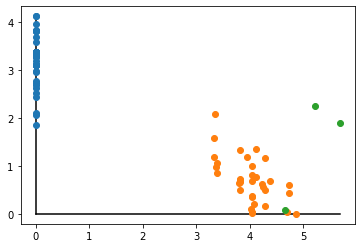

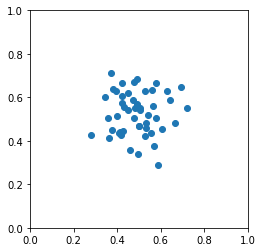

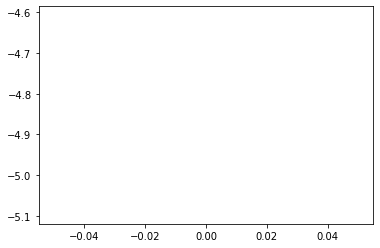


tensor(-5.0481, grad_fn=<SubBackward0>)

tensor(-5.4495, grad_fn=<SubBackward0>)

tensor(-5.5342, grad_fn=<SubBackward0>)

tensor(-5.7352, grad_fn=<SubBackward0>)

tensor(-5.9776, grad_fn=<SubBackward0>)

tensor(-6.4077, grad_fn=<SubBackward0>)

tensor(-6.0893, grad_fn=<SubBackward0>)

tensor(-5.7721, grad_fn=<SubBackward0>)

tensor(-5.7402, grad_fn=<SubBackward0>)

tensor(-5.8763, grad_fn=<SubBackward0>)

tensor(-6.1591, grad_fn=<SubBackward0>)

tensor(-6.3343, grad_fn=<SubBackward0>)

tensor(-6.2104, grad_fn=<SubBackward0>)

tensor(-6.1542, grad_fn=<SubBackward0>)

tensor(-6.2382, grad_fn=<SubBackward0>)

tensor(-6.3159, grad_fn=<SubBackward0>)

tensor(-6.3731, grad_fn=<SubBackward0>)

tensor(-6.3672, grad_fn=<SubBackward0>)

tensor(-6.3297, grad_fn=<SubBackward0>)

tensor(-6.3643, grad_fn=<SubBackward0>)

tensor(-6.3888, grad_fn=<SubBackward0>)

tensor(-6.3701, grad_fn=<SubBackward0>)

tensor(-6.3959, grad_fn=<SubBackward0>)

tensor(-6.4113, grad_fn=<SubBackward0>)

tensor(-6.4160,

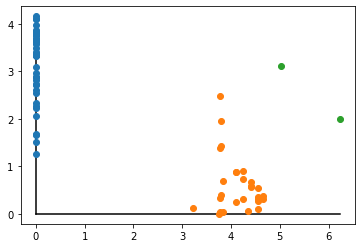

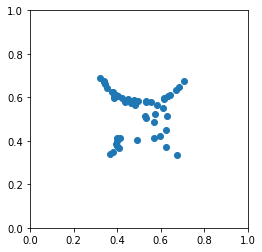

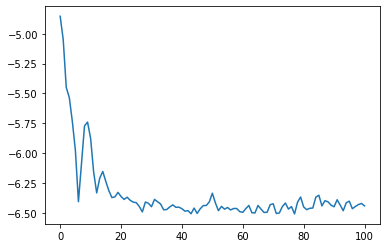


tensor(-6.3794, grad_fn=<SubBackward0>)

tensor(-6.3667, grad_fn=<SubBackward0>)

tensor(-6.4123, grad_fn=<SubBackward0>)

tensor(-6.4487, grad_fn=<SubBackward0>)

tensor(-6.4655, grad_fn=<SubBackward0>)

tensor(-6.4347, grad_fn=<SubBackward0>)

tensor(-6.3862, grad_fn=<SubBackward0>)

tensor(-6.3872, grad_fn=<SubBackward0>)

tensor(-6.4479, grad_fn=<SubBackward0>)

tensor(-6.3718, grad_fn=<SubBackward0>)

tensor(-6.2783, grad_fn=<SubBackward0>)

tensor(-6.3208, grad_fn=<SubBackward0>)

tensor(-6.3915, grad_fn=<SubBackward0>)

tensor(-6.4128, grad_fn=<SubBackward0>)

tensor(-6.4565, grad_fn=<SubBackward0>)

tensor(-6.4669, grad_fn=<SubBackward0>)

tensor(-6.4486, grad_fn=<SubBackward0>)

tensor(-6.3850, grad_fn=<SubBackward0>)

tensor(-6.3697, grad_fn=<SubBackward0>)

tensor(-6.4680, grad_fn=<SubBackward0>)

tensor(-6.4303, grad_fn=<SubBackward0>)

tensor(-6.4333, grad_fn=<SubBackward0>)

tensor(-6.4688, grad_fn=<SubBackward0>)

tensor(-6.4435, grad_fn=<SubBackward0>)

tensor(-6.4423,

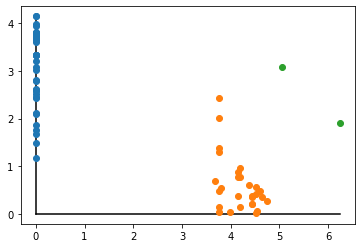

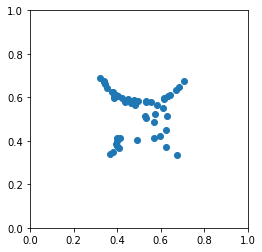

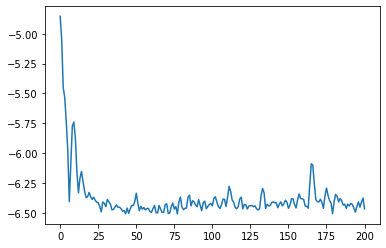


tensor(-6.4699, grad_fn=<SubBackward0>)

tensor(-6.4676, grad_fn=<SubBackward0>)

tensor(-6.4739, grad_fn=<SubBackward0>)

tensor(-6.4914, grad_fn=<SubBackward0>)

tensor(-6.4891, grad_fn=<SubBackward0>)

tensor(-6.4494, grad_fn=<SubBackward0>)

tensor(-6.4338, grad_fn=<SubBackward0>)

tensor(-6.4948, grad_fn=<SubBackward0>)

tensor(-6.4979, grad_fn=<SubBackward0>)

tensor(-6.4798, grad_fn=<SubBackward0>)

tensor(-6.4580, grad_fn=<SubBackward0>)

tensor(-6.4356, grad_fn=<SubBackward0>)

tensor(-6.4796, grad_fn=<SubBackward0>)

tensor(-6.4502, grad_fn=<SubBackward0>)

tensor(-6.4782, grad_fn=<SubBackward0>)

tensor(-6.4502, grad_fn=<SubBackward0>)

tensor(-6.4511, grad_fn=<SubBackward0>)

tensor(-6.4747, grad_fn=<SubBackward0>)

tensor(-6.4769, grad_fn=<SubBackward0>)

tensor(-6.4593, grad_fn=<SubBackward0>)

tensor(-6.4471, grad_fn=<SubBackward0>)

tensor(-6.4938, grad_fn=<SubBackward0>)

tensor(-6.3998, grad_fn=<SubBackward0>)

tensor(-6.3610, grad_fn=<SubBackward0>)

tensor(-6.4341,

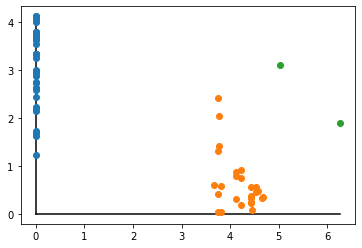

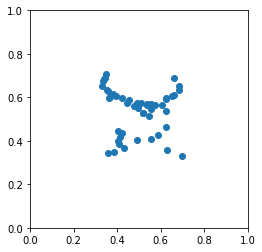

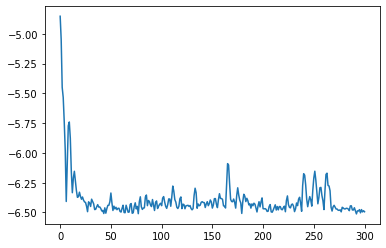


tensor(-6.5256, grad_fn=<SubBackward0>)

tensor(-6.4930, grad_fn=<SubBackward0>)

tensor(-6.4838, grad_fn=<SubBackward0>)

tensor(-6.4926, grad_fn=<SubBackward0>)

tensor(-6.4733, grad_fn=<SubBackward0>)

tensor(-6.5072, grad_fn=<SubBackward0>)

tensor(-6.4424, grad_fn=<SubBackward0>)

tensor(-6.4662, grad_fn=<SubBackward0>)

tensor(-6.4252, grad_fn=<SubBackward0>)

tensor(-6.4124, grad_fn=<SubBackward0>)

tensor(-6.4692, grad_fn=<SubBackward0>)

tensor(-6.4719, grad_fn=<SubBackward0>)

tensor(-6.4663, grad_fn=<SubBackward0>)

tensor(-6.4863, grad_fn=<SubBackward0>)

tensor(-6.4048, grad_fn=<SubBackward0>)

tensor(-6.3910, grad_fn=<SubBackward0>)

tensor(-6.4517, grad_fn=<SubBackward0>)

tensor(-6.4122, grad_fn=<SubBackward0>)

tensor(-6.4085, grad_fn=<SubBackward0>)

tensor(-6.4181, grad_fn=<SubBackward0>)

tensor(-6.4679, grad_fn=<SubBackward0>)

tensor(-6.3242, grad_fn=<SubBackward0>)

tensor(-6.2348, grad_fn=<SubBackward0>)

tensor(-6.2637, grad_fn=<SubBackward0>)

tensor(-6.3668,

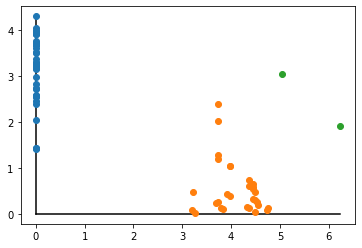

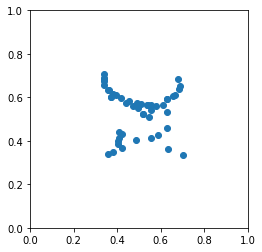

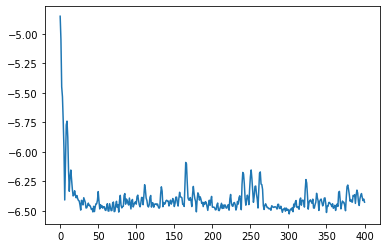


tensor(-6.4482, grad_fn=<SubBackward0>)

tensor(-6.4636, grad_fn=<SubBackward0>)

tensor(-6.4846, grad_fn=<SubBackward0>)

tensor(-6.3802, grad_fn=<SubBackward0>)

tensor(-6.3733, grad_fn=<SubBackward0>)

tensor(-6.4509, grad_fn=<SubBackward0>)

tensor(-6.4064, grad_fn=<SubBackward0>)

tensor(-6.3877, grad_fn=<SubBackward0>)

tensor(-6.4048, grad_fn=<SubBackward0>)

tensor(-6.4371, grad_fn=<SubBackward0>)

tensor(-6.3836, grad_fn=<SubBackward0>)

tensor(-6.3641, grad_fn=<SubBackward0>)

tensor(-6.4159, grad_fn=<SubBackward0>)

tensor(-6.4213, grad_fn=<SubBackward0>)

tensor(-6.4191, grad_fn=<SubBackward0>)

tensor(-6.4378, grad_fn=<SubBackward0>)

tensor(-6.4321, grad_fn=<SubBackward0>)

tensor(-6.4023, grad_fn=<SubBackward0>)

tensor(-6.4356, grad_fn=<SubBackward0>)

tensor(-6.4002, grad_fn=<SubBackward0>)

tensor(-6.3627, grad_fn=<SubBackward0>)

tensor(-6.3884, grad_fn=<SubBackward0>)

tensor(-6.4448, grad_fn=<SubBackward0>)

tensor(-6.4481, grad_fn=<SubBackward0>)

tensor(-6.4188,

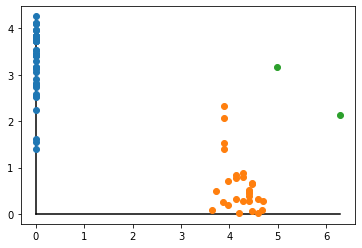

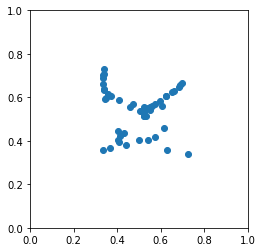

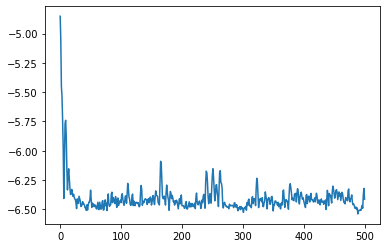


Training finished.


In [89]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                    ks_sqr,
                    non_negative = False,
                    N = 49,
                    maxdim = 2,
                    batch_size = 49,
                    epochs = 5,
                    train_steps = 100,
                    lr = 0.01,
                    init_phases = 'normal',
                    bTranspose = False,
                    score = 'sum'

            )
print(time.time()-t0)
model1.train()

-4.852390289306641
-6.538958549499512


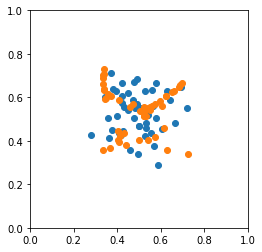

In [90]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.05

0.0050051212310791016
tensor(-4.8524, grad_fn=<SubBackward0>)

run=0, time=0.55s


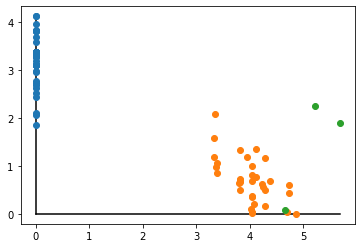

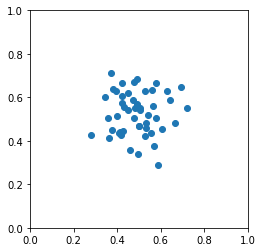

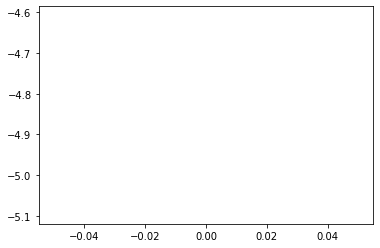


tensor(-4.5506, grad_fn=<SubBackward0>)

tensor(-4.5470, grad_fn=<SubBackward0>)

tensor(-5.6191, grad_fn=<SubBackward0>)

tensor(-5.5393, grad_fn=<SubBackward0>)

tensor(-4.0014, grad_fn=<SubBackward0>)

tensor(-4.1013, grad_fn=<SubBackward0>)

tensor(-4.2415, grad_fn=<SubBackward0>)

tensor(-4.0477, grad_fn=<SubBackward0>)

tensor(-4.1920, grad_fn=<SubBackward0>)

tensor(-4.5662, grad_fn=<SubBackward0>)

tensor(-4.4051, grad_fn=<SubBackward0>)

tensor(-4.7037, grad_fn=<SubBackward0>)

tensor(-4.5884, grad_fn=<SubBackward0>)

tensor(-4.1181, grad_fn=<SubBackward0>)

tensor(-3.8794, grad_fn=<SubBackward0>)

tensor(-4.1148, grad_fn=<SubBackward0>)

tensor(-4.8126, grad_fn=<SubBackward0>)

tensor(-4.5443, grad_fn=<SubBackward0>)

tensor(-4.4395, grad_fn=<SubBackward0>)

tensor(-4.8530, grad_fn=<SubBackward0>)

tensor(-4.3575, grad_fn=<SubBackward0>)

tensor(-4.5337, grad_fn=<SubBackward0>)

tensor(-4.6405, grad_fn=<SubBackward0>)

tensor(-4.6834, grad_fn=<SubBackward0>)

tensor(-4.5908,

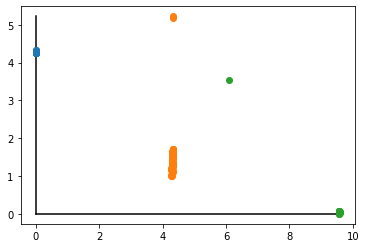

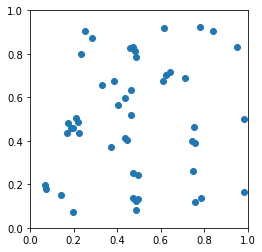

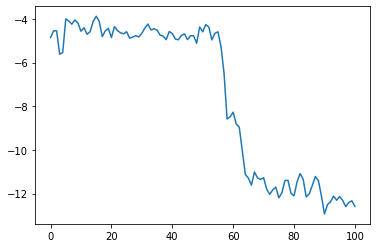


tensor(-12.1224, grad_fn=<SubBackward0>)

tensor(-12.0280, grad_fn=<SubBackward0>)

tensor(-12.0975, grad_fn=<SubBackward0>)

tensor(-12.2929, grad_fn=<SubBackward0>)

tensor(-12.2991, grad_fn=<SubBackward0>)

tensor(-12.4043, grad_fn=<SubBackward0>)

tensor(-12.1827, grad_fn=<SubBackward0>)

tensor(-12.0881, grad_fn=<SubBackward0>)

tensor(-12.4139, grad_fn=<SubBackward0>)

tensor(-12.5359, grad_fn=<SubBackward0>)

tensor(-12.3133, grad_fn=<SubBackward0>)

tensor(-12.3932, grad_fn=<SubBackward0>)

tensor(-12.6946, grad_fn=<SubBackward0>)

tensor(-12.2477, grad_fn=<SubBackward0>)

tensor(-12.2249, grad_fn=<SubBackward0>)

tensor(-12.5179, grad_fn=<SubBackward0>)

tensor(-11.7541, grad_fn=<SubBackward0>)

tensor(-11.7138, grad_fn=<SubBackward0>)

tensor(-12.2822, grad_fn=<SubBackward0>)

tensor(-12.3402, grad_fn=<SubBackward0>)

tensor(-11.7985, grad_fn=<SubBackward0>)

tensor(-12.1251, grad_fn=<SubBackward0>)

tensor(-12.4842, grad_fn=<SubBackward0>)

tensor(-12.2746, grad_fn=<SubBack

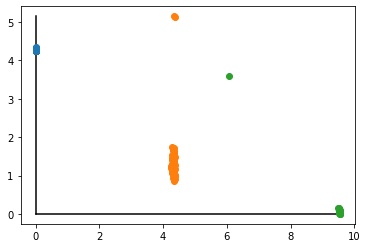

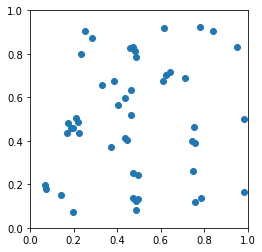

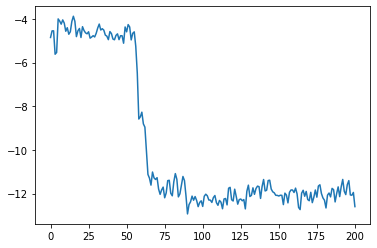


tensor(-12.0845, grad_fn=<SubBackward0>)

tensor(-11.8958, grad_fn=<SubBackward0>)

tensor(-11.8902, grad_fn=<SubBackward0>)

tensor(-12.0400, grad_fn=<SubBackward0>)

tensor(-11.9965, grad_fn=<SubBackward0>)

tensor(-12.1199, grad_fn=<SubBackward0>)

tensor(-12.4479, grad_fn=<SubBackward0>)

tensor(-12.2453, grad_fn=<SubBackward0>)

tensor(-12.3746, grad_fn=<SubBackward0>)

tensor(-12.3969, grad_fn=<SubBackward0>)

tensor(-11.9266, grad_fn=<SubBackward0>)

tensor(-12.0888, grad_fn=<SubBackward0>)

tensor(-11.8504, grad_fn=<SubBackward0>)

tensor(-11.9572, grad_fn=<SubBackward0>)

tensor(-12.5061, grad_fn=<SubBackward0>)

tensor(-12.2531, grad_fn=<SubBackward0>)

tensor(-12.4344, grad_fn=<SubBackward0>)

tensor(-12.3204, grad_fn=<SubBackward0>)

tensor(-12.2722, grad_fn=<SubBackward0>)

tensor(-12.3101, grad_fn=<SubBackward0>)

tensor(-12.2973, grad_fn=<SubBackward0>)

tensor(-12.4451, grad_fn=<SubBackward0>)

tensor(-12.6883, grad_fn=<SubBackward0>)

tensor(-12.4406, grad_fn=<SubBack

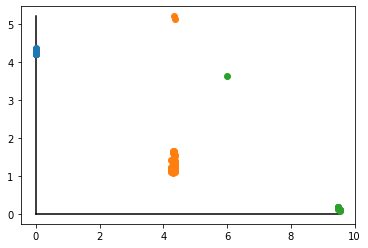

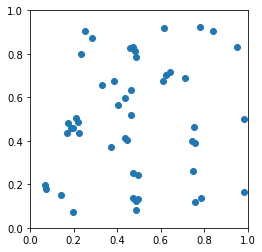

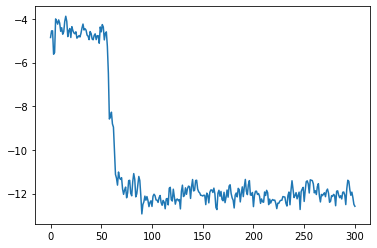


tensor(-12.6374, grad_fn=<SubBackward0>)

tensor(-12.5554, grad_fn=<SubBackward0>)

tensor(-12.4161, grad_fn=<SubBackward0>)

tensor(-12.9272, grad_fn=<SubBackward0>)

tensor(-12.1484, grad_fn=<SubBackward0>)

tensor(-11.8543, grad_fn=<SubBackward0>)

tensor(-12.2678, grad_fn=<SubBackward0>)

tensor(-12.3987, grad_fn=<SubBackward0>)

tensor(-11.7917, grad_fn=<SubBackward0>)

tensor(-11.8851, grad_fn=<SubBackward0>)

tensor(-11.6076, grad_fn=<SubBackward0>)

tensor(-11.6738, grad_fn=<SubBackward0>)

tensor(-12.0329, grad_fn=<SubBackward0>)

tensor(-12.1159, grad_fn=<SubBackward0>)

tensor(-11.9341, grad_fn=<SubBackward0>)

tensor(-12.2000, grad_fn=<SubBackward0>)

tensor(-12.4844, grad_fn=<SubBackward0>)

tensor(-12.5779, grad_fn=<SubBackward0>)

tensor(-12.0851, grad_fn=<SubBackward0>)

tensor(-12.2549, grad_fn=<SubBackward0>)

tensor(-12.0222, grad_fn=<SubBackward0>)

tensor(-11.9800, grad_fn=<SubBackward0>)

tensor(-12.3578, grad_fn=<SubBackward0>)

tensor(-12.5062, grad_fn=<SubBack

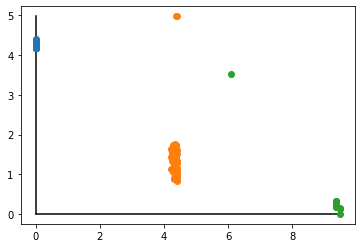

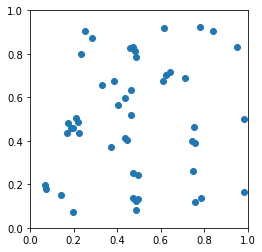

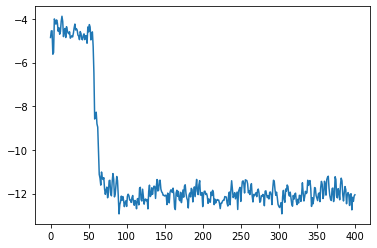


tensor(-12.3236, grad_fn=<SubBackward0>)

tensor(-11.9791, grad_fn=<SubBackward0>)

tensor(-12.2288, grad_fn=<SubBackward0>)

tensor(-12.1071, grad_fn=<SubBackward0>)

tensor(-11.5729, grad_fn=<SubBackward0>)

tensor(-11.7471, grad_fn=<SubBackward0>)

tensor(-12.2759, grad_fn=<SubBackward0>)

tensor(-12.2521, grad_fn=<SubBackward0>)

tensor(-12.4909, grad_fn=<SubBackward0>)

tensor(-12.4401, grad_fn=<SubBackward0>)

tensor(-12.3170, grad_fn=<SubBackward0>)

tensor(-12.2471, grad_fn=<SubBackward0>)

tensor(-12.6620, grad_fn=<SubBackward0>)

tensor(-12.0918, grad_fn=<SubBackward0>)

tensor(-11.6554, grad_fn=<SubBackward0>)

tensor(-11.4445, grad_fn=<SubBackward0>)

tensor(-11.5093, grad_fn=<SubBackward0>)

tensor(-12.1016, grad_fn=<SubBackward0>)

tensor(-11.9355, grad_fn=<SubBackward0>)

tensor(-11.5657, grad_fn=<SubBackward0>)

tensor(-11.8931, grad_fn=<SubBackward0>)

tensor(-12.3836, grad_fn=<SubBackward0>)

tensor(-12.1067, grad_fn=<SubBackward0>)

tensor(-12.2785, grad_fn=<SubBack

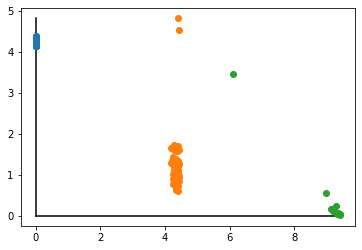

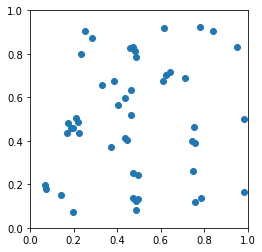

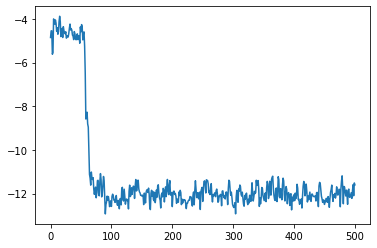

In [91]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                    ks_sqr,
                    non_negative = False,
                    N = 49,
                    maxdim = 2,
                    batch_size = 49,
                    epochs = 5,
                    train_steps = 100,
                    lr = 0.05,
                    init_phases = 'normal',
                    bTranspose = False,
                    score = 'sum'
            )
print(time.time()-t0)
model1.train()

-4.852390289306641
-12.930943489074707


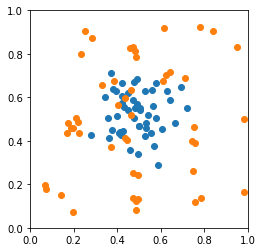

In [92]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.01, correlation

0.0030045509338378906
tensor(-0.0663, grad_fn=<SubBackward0>)

run=0, time=0.42s


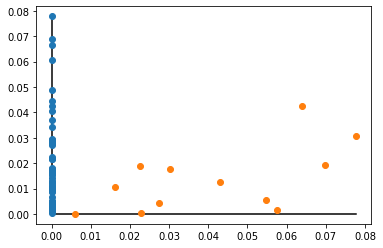

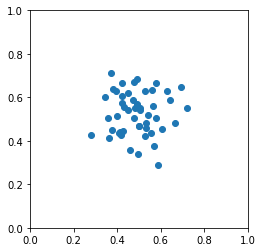

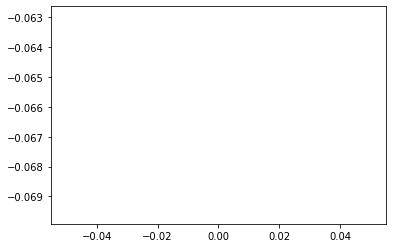


tensor(-0.1720, grad_fn=<SubBackward0>)

tensor(-0.1819, grad_fn=<SubBackward0>)

tensor(-0.2585, grad_fn=<SubBackward0>)

tensor(-0.2650, grad_fn=<SubBackward0>)

tensor(-0.2677, grad_fn=<SubBackward0>)

tensor(-0.2931, grad_fn=<SubBackward0>)

tensor(-0.3154, grad_fn=<SubBackward0>)

tensor(-0.3050, grad_fn=<SubBackward0>)

tensor(-0.3398, grad_fn=<SubBackward0>)

tensor(-0.3861, grad_fn=<SubBackward0>)

tensor(-0.4215, grad_fn=<SubBackward0>)

tensor(-0.4571, grad_fn=<SubBackward0>)

tensor(-0.4694, grad_fn=<SubBackward0>)

tensor(-0.5045, grad_fn=<SubBackward0>)

tensor(-0.5127, grad_fn=<SubBackward0>)

tensor(-0.5523, grad_fn=<SubBackward0>)

tensor(-0.5739, grad_fn=<SubBackward0>)

tensor(-0.5682, grad_fn=<SubBackward0>)

tensor(-0.5614, grad_fn=<SubBackward0>)

tensor(-0.5828, grad_fn=<SubBackward0>)

tensor(-0.6280, grad_fn=<SubBackward0>)

tensor(-0.6534, grad_fn=<SubBackward0>)

tensor(-0.6827, grad_fn=<SubBackward0>)

tensor(-0.7190, grad_fn=<SubBackward0>)

tensor(-0.7672,

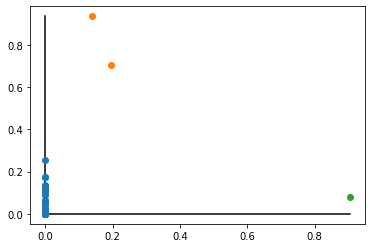

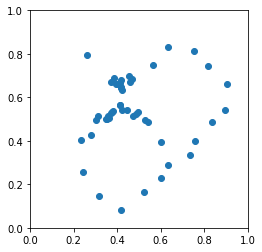

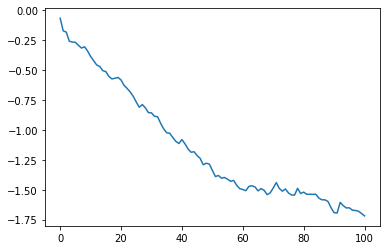


tensor(-1.7262, grad_fn=<SubBackward0>)

tensor(-1.7573, grad_fn=<SubBackward0>)

tensor(-1.7558, grad_fn=<SubBackward0>)

tensor(-1.7503, grad_fn=<SubBackward0>)

tensor(-1.7812, grad_fn=<SubBackward0>)

tensor(-1.7402, grad_fn=<SubBackward0>)

tensor(-1.7437, grad_fn=<SubBackward0>)

tensor(-1.7588, grad_fn=<SubBackward0>)

tensor(-1.7718, grad_fn=<SubBackward0>)

tensor(-1.7416, grad_fn=<SubBackward0>)

tensor(-1.7583, grad_fn=<SubBackward0>)

tensor(-1.7515, grad_fn=<SubBackward0>)

tensor(-1.7896, grad_fn=<SubBackward0>)

tensor(-1.7828, grad_fn=<SubBackward0>)

tensor(-1.7765, grad_fn=<SubBackward0>)

tensor(-1.8030, grad_fn=<SubBackward0>)

tensor(-1.7849, grad_fn=<SubBackward0>)

tensor(-1.7948, grad_fn=<SubBackward0>)

tensor(-1.8117, grad_fn=<SubBackward0>)

tensor(-1.8398, grad_fn=<SubBackward0>)

tensor(-1.7852, grad_fn=<SubBackward0>)

tensor(-1.7687, grad_fn=<SubBackward0>)

tensor(-1.7821, grad_fn=<SubBackward0>)

tensor(-1.7898, grad_fn=<SubBackward0>)

tensor(-1.7870,

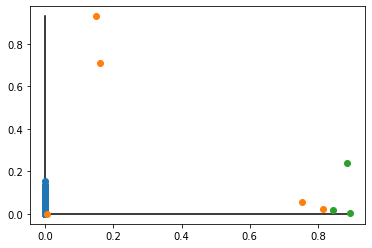

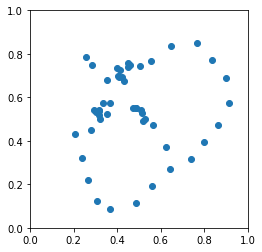

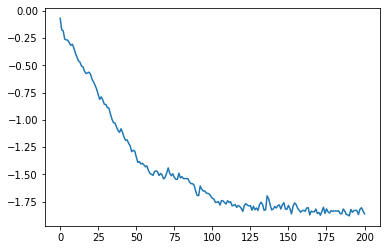


tensor(-1.8506, grad_fn=<SubBackward0>)

tensor(-1.8420, grad_fn=<SubBackward0>)

tensor(-1.8604, grad_fn=<SubBackward0>)

tensor(-1.8071, grad_fn=<SubBackward0>)

tensor(-1.8099, grad_fn=<SubBackward0>)

tensor(-1.8626, grad_fn=<SubBackward0>)

tensor(-1.8748, grad_fn=<SubBackward0>)

tensor(-1.8252, grad_fn=<SubBackward0>)

tensor(-1.8101, grad_fn=<SubBackward0>)

tensor(-1.8327, grad_fn=<SubBackward0>)

tensor(-1.8197, grad_fn=<SubBackward0>)

tensor(-1.8396, grad_fn=<SubBackward0>)

tensor(-1.8270, grad_fn=<SubBackward0>)

tensor(-1.8260, grad_fn=<SubBackward0>)

tensor(-1.8284, grad_fn=<SubBackward0>)

tensor(-1.8384, grad_fn=<SubBackward0>)

tensor(-1.8351, grad_fn=<SubBackward0>)

tensor(-1.8222, grad_fn=<SubBackward0>)

tensor(-1.8579, grad_fn=<SubBackward0>)

tensor(-1.8247, grad_fn=<SubBackward0>)

tensor(-1.8509, grad_fn=<SubBackward0>)

tensor(-1.8389, grad_fn=<SubBackward0>)

tensor(-1.8378, grad_fn=<SubBackward0>)

tensor(-1.8792, grad_fn=<SubBackward0>)

tensor(-1.8381,

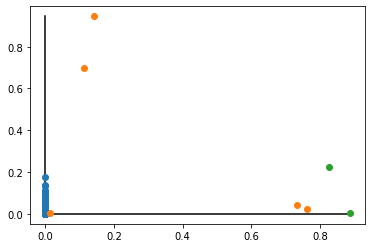

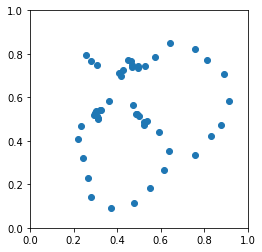

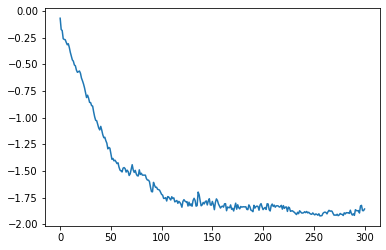


tensor(-1.8913, grad_fn=<SubBackward0>)

tensor(-1.9059, grad_fn=<SubBackward0>)

tensor(-1.9039, grad_fn=<SubBackward0>)

tensor(-1.9026, grad_fn=<SubBackward0>)

tensor(-1.9190, grad_fn=<SubBackward0>)

tensor(-1.9254, grad_fn=<SubBackward0>)

tensor(-1.9056, grad_fn=<SubBackward0>)

tensor(-1.9034, grad_fn=<SubBackward0>)

tensor(-1.8898, grad_fn=<SubBackward0>)

tensor(-1.9015, grad_fn=<SubBackward0>)

tensor(-1.9184, grad_fn=<SubBackward0>)

tensor(-1.9095, grad_fn=<SubBackward0>)

tensor(-1.9210, grad_fn=<SubBackward0>)

tensor(-1.9027, grad_fn=<SubBackward0>)

tensor(-1.9095, grad_fn=<SubBackward0>)

tensor(-1.9032, grad_fn=<SubBackward0>)

tensor(-1.9065, grad_fn=<SubBackward0>)

tensor(-1.8580, grad_fn=<SubBackward0>)

tensor(-1.8637, grad_fn=<SubBackward0>)

tensor(-1.8938, grad_fn=<SubBackward0>)

tensor(-1.8345, grad_fn=<SubBackward0>)

tensor(-1.8359, grad_fn=<SubBackward0>)

tensor(-1.8761, grad_fn=<SubBackward0>)

tensor(-1.8839, grad_fn=<SubBackward0>)

tensor(-1.8654,

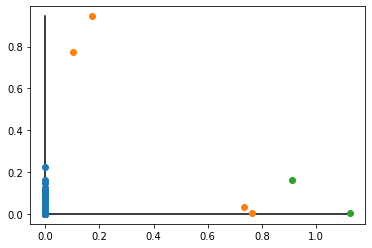

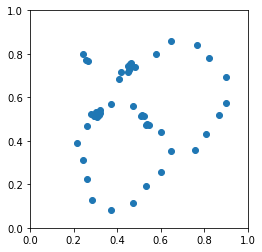

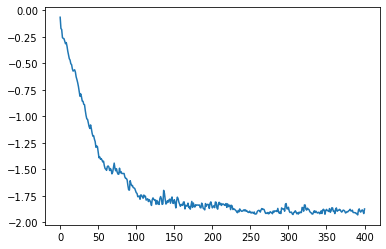


tensor(-1.8389, grad_fn=<SubBackward0>)

tensor(-1.8488, grad_fn=<SubBackward0>)

tensor(-1.8410, grad_fn=<SubBackward0>)

tensor(-1.8518, grad_fn=<SubBackward0>)

tensor(-1.8816, grad_fn=<SubBackward0>)

tensor(-1.8474, grad_fn=<SubBackward0>)

tensor(-1.8420, grad_fn=<SubBackward0>)

tensor(-1.8702, grad_fn=<SubBackward0>)

tensor(-1.9002, grad_fn=<SubBackward0>)

tensor(-1.9200, grad_fn=<SubBackward0>)

tensor(-1.8981, grad_fn=<SubBackward0>)

tensor(-1.8963, grad_fn=<SubBackward0>)

tensor(-1.9018, grad_fn=<SubBackward0>)

tensor(-1.9112, grad_fn=<SubBackward0>)

tensor(-1.9113, grad_fn=<SubBackward0>)

tensor(-1.9283, grad_fn=<SubBackward0>)

tensor(-1.9081, grad_fn=<SubBackward0>)

tensor(-1.9004, grad_fn=<SubBackward0>)

tensor(-1.9049, grad_fn=<SubBackward0>)

tensor(-1.9079, grad_fn=<SubBackward0>)

tensor(-1.9091, grad_fn=<SubBackward0>)

tensor(-1.9186, grad_fn=<SubBackward0>)

tensor(-1.9111, grad_fn=<SubBackward0>)

tensor(-1.9164, grad_fn=<SubBackward0>)

tensor(-1.8904,

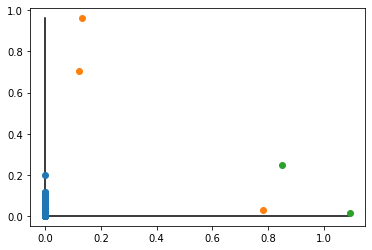

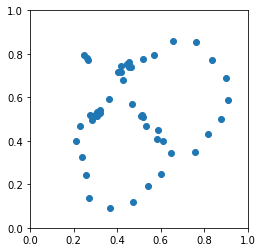

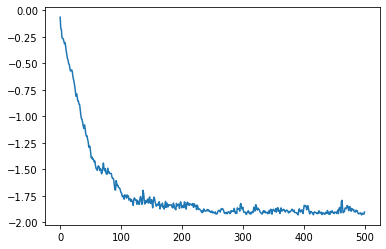


Training finished.


In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                    ks_sqr,
                    non_negative = False,
                    N = 49,
                    maxdim = 2,
                    batch_size = 49,
                    epochs = 5,
                    train_steps = 100,
                    lr = 0.01,
                    init_phases = 'normal',
                    bTranspose = True,
                    score = 'sum'

            )
print(time.time()-t0)
model1.train()

-0.06627161055803299
-1.9295579195022583


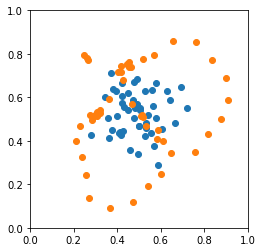

In [94]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.05, correlation

0.0030035972595214844
tensor(-0.0663, grad_fn=<SubBackward0>)

run=0, time=0.47s


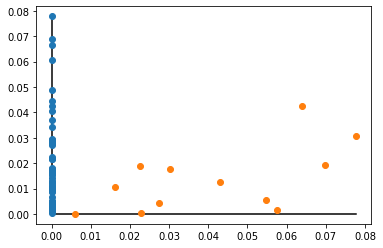

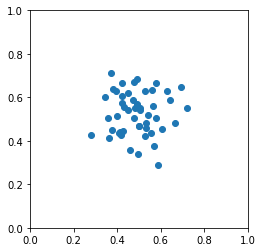

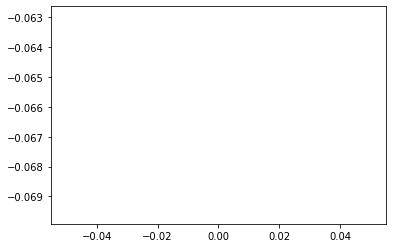


tensor(-0.0938, grad_fn=<SubBackward0>)

tensor(-0.1218, grad_fn=<SubBackward0>)

tensor(-0.1885, grad_fn=<SubBackward0>)

tensor(-0.1043, grad_fn=<SubBackward0>)

tensor(-0.2802, grad_fn=<SubBackward0>)

tensor(-0.1187, grad_fn=<SubBackward0>)

tensor(-0.2772, grad_fn=<SubBackward0>)

tensor(-0.5134, grad_fn=<SubBackward0>)

tensor(-0.7329, grad_fn=<SubBackward0>)

tensor(-0.8108, grad_fn=<SubBackward0>)

tensor(-0.9716, grad_fn=<SubBackward0>)

tensor(-0.9052, grad_fn=<SubBackward0>)

tensor(-0.9802, grad_fn=<SubBackward0>)

tensor(-1.1372, grad_fn=<SubBackward0>)

tensor(-1.3846, grad_fn=<SubBackward0>)

tensor(-1.4114, grad_fn=<SubBackward0>)

tensor(-1.5435, grad_fn=<SubBackward0>)

tensor(-1.5834, grad_fn=<SubBackward0>)

tensor(-1.5547, grad_fn=<SubBackward0>)

tensor(-1.6175, grad_fn=<SubBackward0>)

tensor(-1.5008, grad_fn=<SubBackward0>)

tensor(-1.4594, grad_fn=<SubBackward0>)

tensor(-1.4976, grad_fn=<SubBackward0>)

tensor(-1.4220, grad_fn=<SubBackward0>)

tensor(-1.4218,

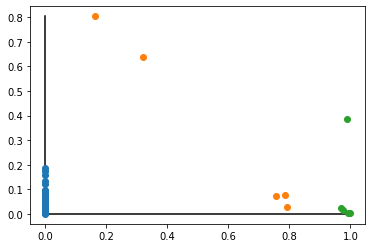

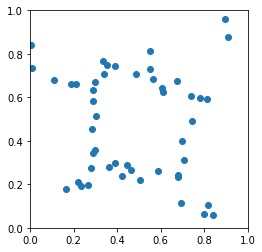

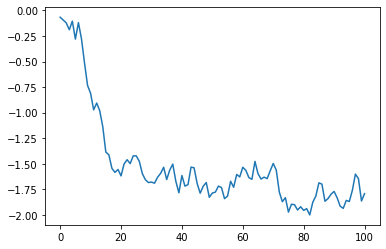


tensor(-1.8116, grad_fn=<SubBackward0>)

tensor(-1.9615, grad_fn=<SubBackward0>)

tensor(-1.8149, grad_fn=<SubBackward0>)

tensor(-1.7421, grad_fn=<SubBackward0>)

tensor(-1.7841, grad_fn=<SubBackward0>)

tensor(-1.8946, grad_fn=<SubBackward0>)

tensor(-1.9114, grad_fn=<SubBackward0>)

tensor(-1.8291, grad_fn=<SubBackward0>)

tensor(-1.6976, grad_fn=<SubBackward0>)

tensor(-1.7443, grad_fn=<SubBackward0>)

tensor(-1.7589, grad_fn=<SubBackward0>)

tensor(-1.8105, grad_fn=<SubBackward0>)

tensor(-1.7222, grad_fn=<SubBackward0>)

tensor(-1.8341, grad_fn=<SubBackward0>)

tensor(-1.7191, grad_fn=<SubBackward0>)

tensor(-1.7446, grad_fn=<SubBackward0>)

tensor(-1.8590, grad_fn=<SubBackward0>)

tensor(-1.6319, grad_fn=<SubBackward0>)

tensor(-1.6591, grad_fn=<SubBackward0>)

tensor(-1.5703, grad_fn=<SubBackward0>)

tensor(-1.6216, grad_fn=<SubBackward0>)

tensor(-1.7068, grad_fn=<SubBackward0>)

tensor(-1.7955, grad_fn=<SubBackward0>)

tensor(-1.7850, grad_fn=<SubBackward0>)

tensor(-1.7079,

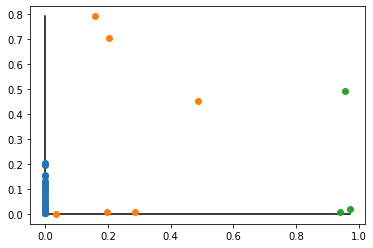

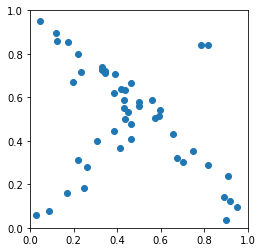

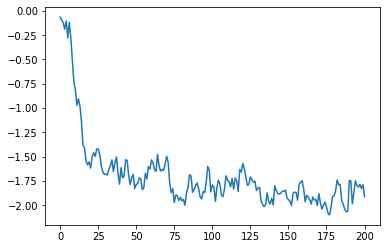


tensor(-1.8206, grad_fn=<SubBackward0>)

tensor(-1.7503, grad_fn=<SubBackward0>)

tensor(-1.9096, grad_fn=<SubBackward0>)

tensor(-1.8423, grad_fn=<SubBackward0>)

tensor(-1.7750, grad_fn=<SubBackward0>)

tensor(-1.8548, grad_fn=<SubBackward0>)

tensor(-1.8702, grad_fn=<SubBackward0>)

tensor(-1.8477, grad_fn=<SubBackward0>)

tensor(-1.8219, grad_fn=<SubBackward0>)

tensor(-1.8204, grad_fn=<SubBackward0>)

tensor(-1.8147, grad_fn=<SubBackward0>)

tensor(-1.8846, grad_fn=<SubBackward0>)

tensor(-1.8895, grad_fn=<SubBackward0>)

tensor(-1.8051, grad_fn=<SubBackward0>)

tensor(-1.8348, grad_fn=<SubBackward0>)

tensor(-1.8767, grad_fn=<SubBackward0>)

tensor(-1.8427, grad_fn=<SubBackward0>)

tensor(-1.7577, grad_fn=<SubBackward0>)

tensor(-1.9171, grad_fn=<SubBackward0>)

tensor(-2.0077, grad_fn=<SubBackward0>)

tensor(-1.9594, grad_fn=<SubBackward0>)

tensor(-2.0634, grad_fn=<SubBackward0>)

tensor(-2.0429, grad_fn=<SubBackward0>)

tensor(-2.0267, grad_fn=<SubBackward0>)

tensor(-1.9292,

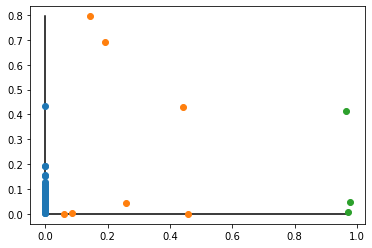

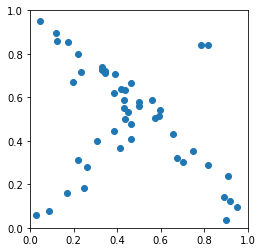

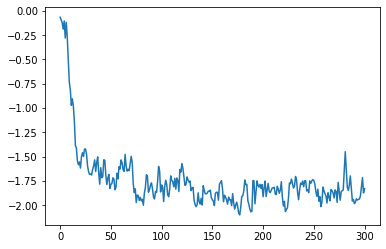


tensor(-1.8430, grad_fn=<SubBackward0>)

tensor(-1.8292, grad_fn=<SubBackward0>)

tensor(-2.0367, grad_fn=<SubBackward0>)

tensor(-1.9863, grad_fn=<SubBackward0>)

tensor(-1.7910, grad_fn=<SubBackward0>)

tensor(-1.7569, grad_fn=<SubBackward0>)

tensor(-1.8728, grad_fn=<SubBackward0>)

tensor(-1.9390, grad_fn=<SubBackward0>)

tensor(-1.8676, grad_fn=<SubBackward0>)

tensor(-1.8773, grad_fn=<SubBackward0>)

tensor(-1.9889, grad_fn=<SubBackward0>)

tensor(-1.9385, grad_fn=<SubBackward0>)

tensor(-1.9930, grad_fn=<SubBackward0>)

tensor(-1.9953, grad_fn=<SubBackward0>)

tensor(-1.9081, grad_fn=<SubBackward0>)

tensor(-1.7497, grad_fn=<SubBackward0>)

tensor(-1.8760, grad_fn=<SubBackward0>)

tensor(-1.7636, grad_fn=<SubBackward0>)

tensor(-1.8975, grad_fn=<SubBackward0>)

tensor(-1.8232, grad_fn=<SubBackward0>)

tensor(-1.8506, grad_fn=<SubBackward0>)

tensor(-1.8555, grad_fn=<SubBackward0>)

tensor(-1.8728, grad_fn=<SubBackward0>)

tensor(-1.8545, grad_fn=<SubBackward0>)

tensor(-1.7775,

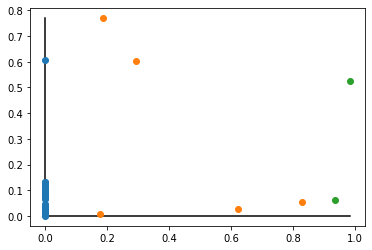

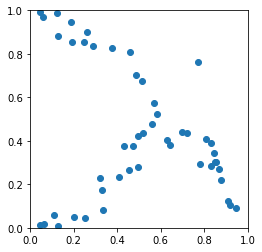

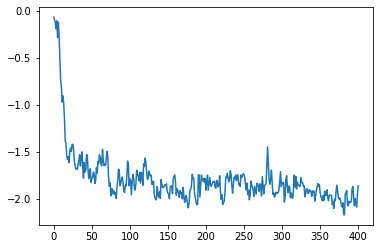


tensor(-1.9555, grad_fn=<SubBackward0>)

tensor(-1.8991, grad_fn=<SubBackward0>)

tensor(-1.9447, grad_fn=<SubBackward0>)

tensor(-2.0290, grad_fn=<SubBackward0>)

tensor(-2.0322, grad_fn=<SubBackward0>)

tensor(-1.9502, grad_fn=<SubBackward0>)

tensor(-1.9792, grad_fn=<SubBackward0>)

tensor(-2.0041, grad_fn=<SubBackward0>)

tensor(-2.0070, grad_fn=<SubBackward0>)

tensor(-1.9419, grad_fn=<SubBackward0>)

tensor(-2.0259, grad_fn=<SubBackward0>)

tensor(-2.1112, grad_fn=<SubBackward0>)

tensor(-2.1320, grad_fn=<SubBackward0>)

tensor(-2.0340, grad_fn=<SubBackward0>)

tensor(-2.0271, grad_fn=<SubBackward0>)

tensor(-2.1419, grad_fn=<SubBackward0>)

tensor(-2.1935, grad_fn=<SubBackward0>)

tensor(-2.1663, grad_fn=<SubBackward0>)

tensor(-2.1295, grad_fn=<SubBackward0>)

tensor(-2.1521, grad_fn=<SubBackward0>)

tensor(-2.0022, grad_fn=<SubBackward0>)

tensor(-2.0514, grad_fn=<SubBackward0>)

tensor(-2.0999, grad_fn=<SubBackward0>)

tensor(-2.1551, grad_fn=<SubBackward0>)

tensor(-2.1050,

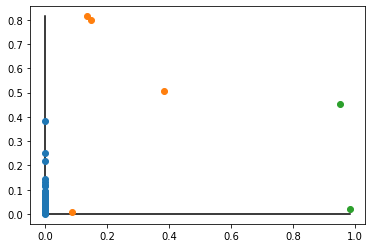

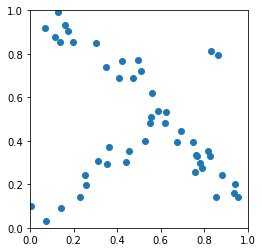

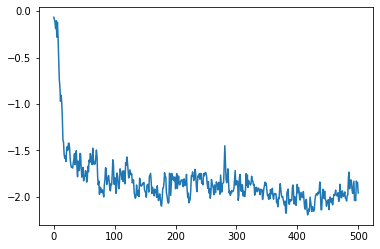


Training finished.


In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                    ks_sqr,
                    non_negative = False,
                    N = 49,
                    maxdim = 2,
                    batch_size = 49,
                    epochs = 5,
                    train_steps = 100,
                    lr = 0.05,
                    init_phases = 'normal',
                    bTranspose = True,
                    score = 'sum'
            )
print(time.time()-t0)
model1.train()

-0.06627161055803299
-2.193492889404297


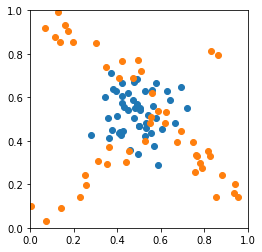

In [96]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

#### Init_phases = 'uniform'

##### 4 neurons, lr 0.01

0.0
tensor(-1.0672, grad_fn=<SubBackward0>)

run=0, time=0.37s


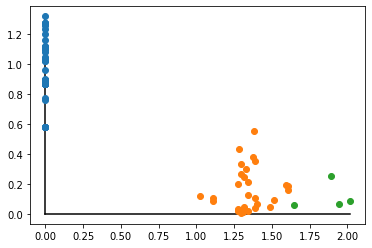

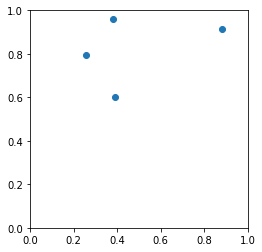

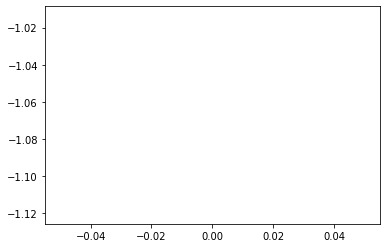


tensor(-1.6420, grad_fn=<SubBackward0>)

tensor(-1.6473, grad_fn=<SubBackward0>)

tensor(-1.6333, grad_fn=<SubBackward0>)

tensor(-1.8236, grad_fn=<SubBackward0>)

tensor(-1.6714, grad_fn=<SubBackward0>)

tensor(-1.6442, grad_fn=<SubBackward0>)

tensor(-1.6488, grad_fn=<SubBackward0>)

tensor(-1.7131, grad_fn=<SubBackward0>)

tensor(-1.7381, grad_fn=<SubBackward0>)

tensor(-1.7041, grad_fn=<SubBackward0>)

tensor(-1.7380, grad_fn=<SubBackward0>)

tensor(-1.8656, grad_fn=<SubBackward0>)

tensor(-1.9372, grad_fn=<SubBackward0>)

tensor(-2.0099, grad_fn=<SubBackward0>)

tensor(-1.9953, grad_fn=<SubBackward0>)

tensor(-1.9777, grad_fn=<SubBackward0>)

tensor(-2.0094, grad_fn=<SubBackward0>)

tensor(-2.0477, grad_fn=<SubBackward0>)

tensor(-1.9708, grad_fn=<SubBackward0>)

tensor(-1.9246, grad_fn=<SubBackward0>)

tensor(-1.9767, grad_fn=<SubBackward0>)

tensor(-1.9728, grad_fn=<SubBackward0>)

tensor(-1.8986, grad_fn=<SubBackward0>)

tensor(-1.8249, grad_fn=<SubBackward0>)

tensor(-1.8443,

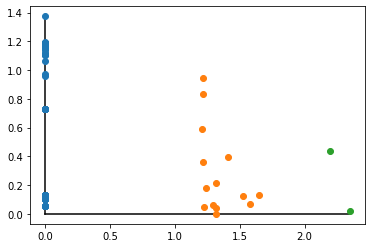

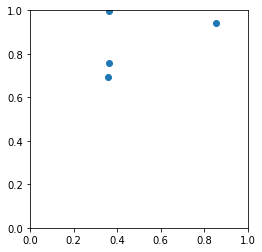

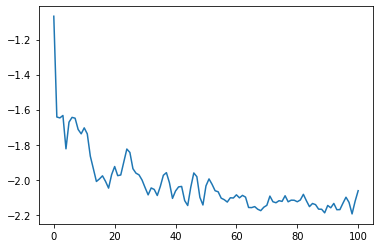


tensor(-2.0556, grad_fn=<SubBackward0>)

tensor(-2.0847, grad_fn=<SubBackward0>)

tensor(-2.1348, grad_fn=<SubBackward0>)

tensor(-2.1577, grad_fn=<SubBackward0>)

tensor(-2.0994, grad_fn=<SubBackward0>)

tensor(-2.0730, grad_fn=<SubBackward0>)

tensor(-2.1031, grad_fn=<SubBackward0>)

tensor(-2.0841, grad_fn=<SubBackward0>)

tensor(-2.0672, grad_fn=<SubBackward0>)

tensor(-2.1384, grad_fn=<SubBackward0>)

tensor(-2.1517, grad_fn=<SubBackward0>)

tensor(-2.1347, grad_fn=<SubBackward0>)

tensor(-2.0747, grad_fn=<SubBackward0>)

tensor(-2.1132, grad_fn=<SubBackward0>)

tensor(-2.1392, grad_fn=<SubBackward0>)

tensor(-2.1514, grad_fn=<SubBackward0>)

tensor(-2.0784, grad_fn=<SubBackward0>)

tensor(-2.0172, grad_fn=<SubBackward0>)

tensor(-2.0340, grad_fn=<SubBackward0>)

tensor(-2.0963, grad_fn=<SubBackward0>)

tensor(-2.1224, grad_fn=<SubBackward0>)

tensor(-2.1079, grad_fn=<SubBackward0>)

tensor(-2.1473, grad_fn=<SubBackward0>)

tensor(-2.1764, grad_fn=<SubBackward0>)

tensor(-2.1155,

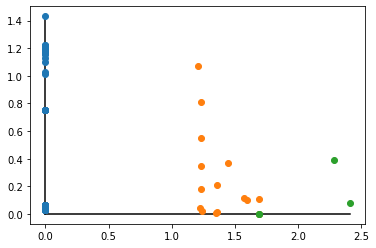

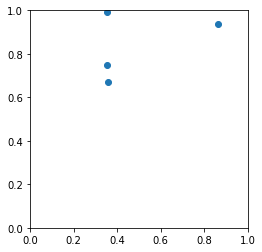

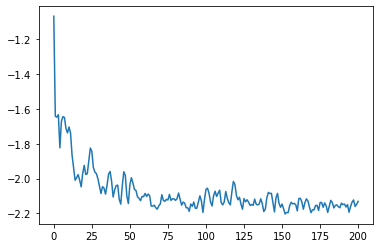


tensor(-2.1736, grad_fn=<SubBackward0>)

tensor(-2.1668, grad_fn=<SubBackward0>)

tensor(-2.1391, grad_fn=<SubBackward0>)

tensor(-2.1578, grad_fn=<SubBackward0>)

tensor(-2.1705, grad_fn=<SubBackward0>)

tensor(-2.1188, grad_fn=<SubBackward0>)

tensor(-2.0878, grad_fn=<SubBackward0>)

tensor(-2.1051, grad_fn=<SubBackward0>)

tensor(-2.1282, grad_fn=<SubBackward0>)

tensor(-2.1148, grad_fn=<SubBackward0>)

tensor(-2.0739, grad_fn=<SubBackward0>)

tensor(-2.0634, grad_fn=<SubBackward0>)

tensor(-2.1299, grad_fn=<SubBackward0>)

tensor(-2.1193, grad_fn=<SubBackward0>)

tensor(-2.0870, grad_fn=<SubBackward0>)

tensor(-2.1209, grad_fn=<SubBackward0>)

tensor(-2.1613, grad_fn=<SubBackward0>)

tensor(-2.1542, grad_fn=<SubBackward0>)

tensor(-2.1470, grad_fn=<SubBackward0>)

tensor(-2.1451, grad_fn=<SubBackward0>)

tensor(-2.1188, grad_fn=<SubBackward0>)

tensor(-2.1461, grad_fn=<SubBackward0>)

tensor(-2.1722, grad_fn=<SubBackward0>)

tensor(-2.1482, grad_fn=<SubBackward0>)

tensor(-2.1382,

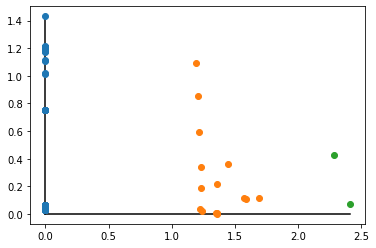

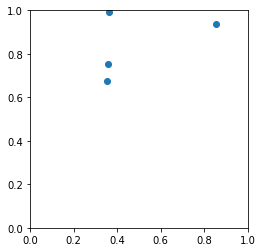

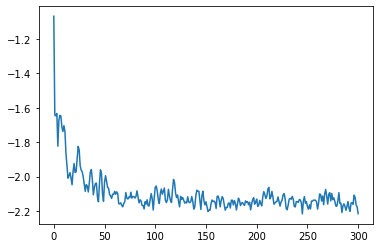


tensor(-2.1197, grad_fn=<SubBackward0>)

tensor(-2.1284, grad_fn=<SubBackward0>)

tensor(-2.1080, grad_fn=<SubBackward0>)

tensor(-2.1212, grad_fn=<SubBackward0>)

tensor(-2.1216, grad_fn=<SubBackward0>)

tensor(-2.1134, grad_fn=<SubBackward0>)

tensor(-2.1551, grad_fn=<SubBackward0>)

tensor(-2.1653, grad_fn=<SubBackward0>)

tensor(-2.1485, grad_fn=<SubBackward0>)

tensor(-2.1536, grad_fn=<SubBackward0>)

tensor(-2.1714, grad_fn=<SubBackward0>)

tensor(-2.1637, grad_fn=<SubBackward0>)

tensor(-2.1566, grad_fn=<SubBackward0>)

tensor(-2.1762, grad_fn=<SubBackward0>)

tensor(-2.1595, grad_fn=<SubBackward0>)

tensor(-2.1437, grad_fn=<SubBackward0>)

tensor(-2.1725, grad_fn=<SubBackward0>)

tensor(-2.2125, grad_fn=<SubBackward0>)

tensor(-2.1799, grad_fn=<SubBackward0>)

tensor(-2.2068, grad_fn=<SubBackward0>)

tensor(-2.1489, grad_fn=<SubBackward0>)

tensor(-2.1399, grad_fn=<SubBackward0>)

tensor(-2.1474, grad_fn=<SubBackward0>)

tensor(-2.1507, grad_fn=<SubBackward0>)

tensor(-2.0950,

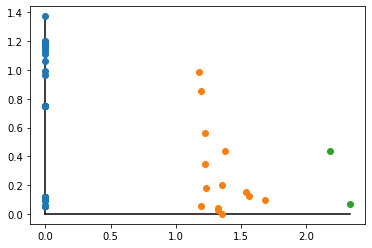

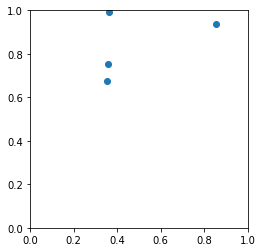

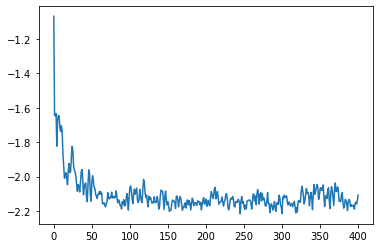


tensor(-2.1103, grad_fn=<SubBackward0>)

tensor(-2.1511, grad_fn=<SubBackward0>)

tensor(-2.1541, grad_fn=<SubBackward0>)

tensor(-2.1695, grad_fn=<SubBackward0>)

tensor(-2.1560, grad_fn=<SubBackward0>)

tensor(-2.1011, grad_fn=<SubBackward0>)

tensor(-2.0823, grad_fn=<SubBackward0>)

tensor(-2.1456, grad_fn=<SubBackward0>)

tensor(-2.1641, grad_fn=<SubBackward0>)

tensor(-2.1560, grad_fn=<SubBackward0>)

tensor(-2.1762, grad_fn=<SubBackward0>)

tensor(-2.1827, grad_fn=<SubBackward0>)

tensor(-2.1684, grad_fn=<SubBackward0>)

tensor(-2.1753, grad_fn=<SubBackward0>)

tensor(-2.1609, grad_fn=<SubBackward0>)

tensor(-2.1545, grad_fn=<SubBackward0>)

tensor(-2.1626, grad_fn=<SubBackward0>)

tensor(-2.1899, grad_fn=<SubBackward0>)

tensor(-2.1842, grad_fn=<SubBackward0>)

tensor(-2.1981, grad_fn=<SubBackward0>)

tensor(-2.1860, grad_fn=<SubBackward0>)

tensor(-2.1496, grad_fn=<SubBackward0>)

tensor(-2.1865, grad_fn=<SubBackward0>)

tensor(-2.1600, grad_fn=<SubBackward0>)

tensor(-2.1642,

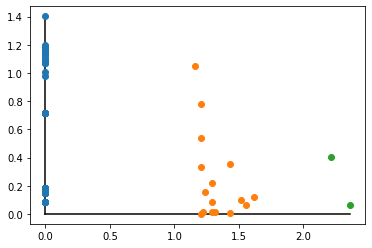

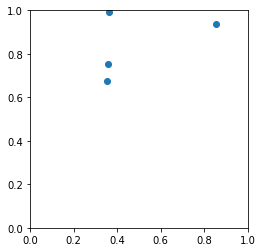

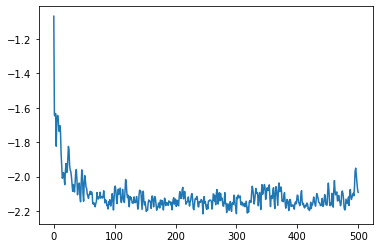


Training finished.


In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                    ks_sqr,
                    non_negative = False,
                    N = 4,
                    maxdim = 2,
                    batch_size = 49,
                    epochs = 5,
                    train_steps = 100,
                    lr = 0.01,
                    init_phases = 'uniform',
                    bTranspose = False,
                    score = 'sum'
            )
print(time.time()-t0)
model1.train()

-1.067201018333435
-2.2177233695983887


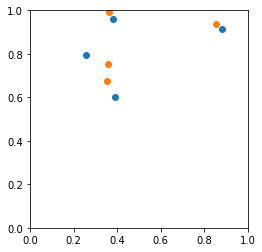

In [98]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')

##### 49 neurons, lr 0.05

0.008195638656616211
tensor(-1.0672, grad_fn=<SubBackward0>)

run=0, time=0.39s


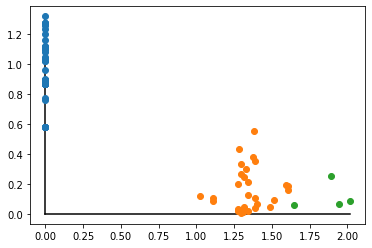

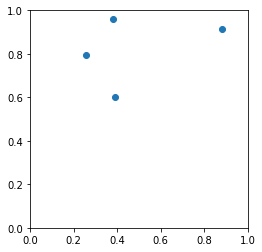

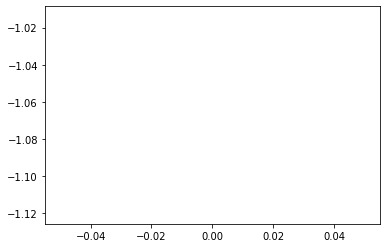


tensor(-0.5821, grad_fn=<SubBackward0>)

tensor(-0.6221, grad_fn=<SubBackward0>)

tensor(-0.9635, grad_fn=<SubBackward0>)

tensor(-0.9091, grad_fn=<SubBackward0>)

tensor(-0.7947, grad_fn=<SubBackward0>)

tensor(-0.5535, grad_fn=<SubBackward0>)

tensor(-0.8326, grad_fn=<SubBackward0>)

tensor(-1.1217, grad_fn=<SubBackward0>)

tensor(-1.0035, grad_fn=<SubBackward0>)

tensor(-1.0898, grad_fn=<SubBackward0>)

tensor(-1.1709, grad_fn=<SubBackward0>)

tensor(-1.3084, grad_fn=<SubBackward0>)

tensor(-1.4886, grad_fn=<SubBackward0>)

tensor(-1.3654, grad_fn=<SubBackward0>)

tensor(-1.2070, grad_fn=<SubBackward0>)

tensor(-1.2818, grad_fn=<SubBackward0>)

tensor(-1.4527, grad_fn=<SubBackward0>)

tensor(-1.7075, grad_fn=<SubBackward0>)

tensor(-1.7061, grad_fn=<SubBackward0>)

tensor(-1.5020, grad_fn=<SubBackward0>)

tensor(-1.4076, grad_fn=<SubBackward0>)

tensor(-1.2368, grad_fn=<SubBackward0>)

tensor(-1.1591, grad_fn=<SubBackward0>)

tensor(-1.1428, grad_fn=<SubBackward0>)

tensor(-1.1803,

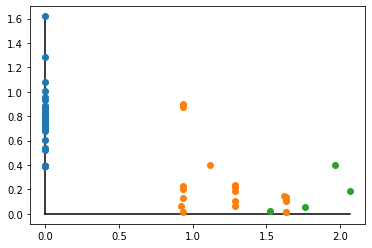

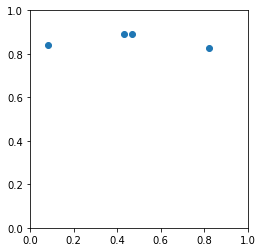

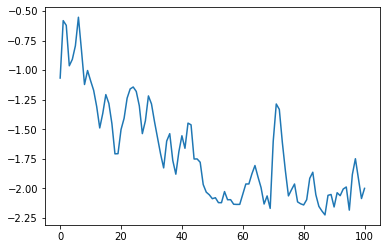


tensor(-2.1071, grad_fn=<SubBackward0>)

tensor(-2.1698, grad_fn=<SubBackward0>)

tensor(-1.7786, grad_fn=<SubBackward0>)

tensor(-1.8774, grad_fn=<SubBackward0>)

tensor(-1.9154, grad_fn=<SubBackward0>)

tensor(-1.9870, grad_fn=<SubBackward0>)

tensor(-2.0691, grad_fn=<SubBackward0>)

tensor(-1.5128, grad_fn=<SubBackward0>)

tensor(-1.4356, grad_fn=<SubBackward0>)

tensor(-1.4238, grad_fn=<SubBackward0>)

tensor(-1.4701, grad_fn=<SubBackward0>)

tensor(-1.4607, grad_fn=<SubBackward0>)

tensor(-1.7560, grad_fn=<SubBackward0>)

tensor(-2.0432, grad_fn=<SubBackward0>)

tensor(-1.7081, grad_fn=<SubBackward0>)

tensor(-1.5243, grad_fn=<SubBackward0>)

tensor(-1.2128, grad_fn=<SubBackward0>)

tensor(-1.1720, grad_fn=<SubBackward0>)

tensor(-1.3198, grad_fn=<SubBackward0>)

tensor(-1.7430, grad_fn=<SubBackward0>)

tensor(-1.8333, grad_fn=<SubBackward0>)

tensor(-1.8178, grad_fn=<SubBackward0>)

tensor(-1.8490, grad_fn=<SubBackward0>)

tensor(-1.9258, grad_fn=<SubBackward0>)

tensor(-1.9028,

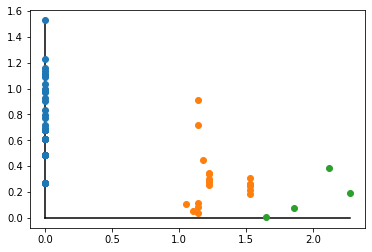

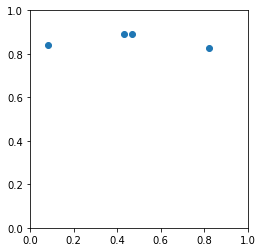

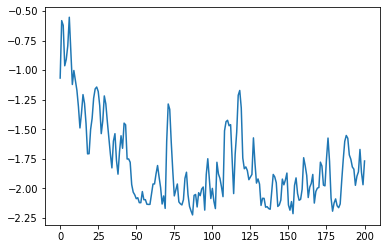


tensor(-1.5133, grad_fn=<SubBackward0>)

tensor(-1.3528, grad_fn=<SubBackward0>)

tensor(-1.1776, grad_fn=<SubBackward0>)

tensor(-1.3813, grad_fn=<SubBackward0>)

tensor(-1.8279, grad_fn=<SubBackward0>)

tensor(-2.1364, grad_fn=<SubBackward0>)

tensor(-1.8061, grad_fn=<SubBackward0>)

tensor(-1.6889, grad_fn=<SubBackward0>)

tensor(-1.8427, grad_fn=<SubBackward0>)

tensor(-2.0228, grad_fn=<SubBackward0>)

tensor(-2.0690, grad_fn=<SubBackward0>)

tensor(-1.9414, grad_fn=<SubBackward0>)

tensor(-1.9047, grad_fn=<SubBackward0>)

tensor(-2.1219, grad_fn=<SubBackward0>)

tensor(-2.0394, grad_fn=<SubBackward0>)

tensor(-1.7319, grad_fn=<SubBackward0>)

tensor(-1.8928, grad_fn=<SubBackward0>)

tensor(-1.9992, grad_fn=<SubBackward0>)

tensor(-2.0854, grad_fn=<SubBackward0>)

tensor(-2.1981, grad_fn=<SubBackward0>)

tensor(-2.0468, grad_fn=<SubBackward0>)

tensor(-2.0588, grad_fn=<SubBackward0>)

tensor(-2.1584, grad_fn=<SubBackward0>)

tensor(-2.0415, grad_fn=<SubBackward0>)

tensor(-1.9100,

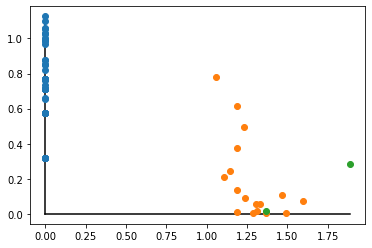

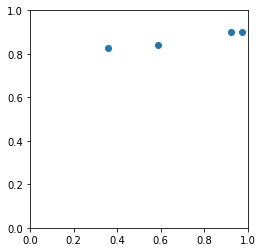

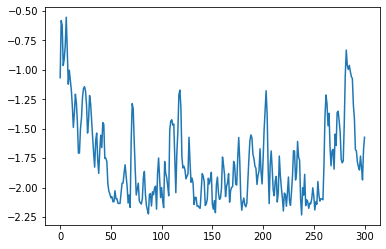


tensor(-1.4574, grad_fn=<SubBackward0>)

tensor(-1.4850, grad_fn=<SubBackward0>)

tensor(-1.6069, grad_fn=<SubBackward0>)

tensor(-1.3196, grad_fn=<SubBackward0>)

tensor(-1.3204, grad_fn=<SubBackward0>)

tensor(-1.5052, grad_fn=<SubBackward0>)

tensor(-1.6759, grad_fn=<SubBackward0>)

tensor(-1.3514, grad_fn=<SubBackward0>)

tensor(-1.0480, grad_fn=<SubBackward0>)

tensor(-0.9251, grad_fn=<SubBackward0>)

tensor(-0.9873, grad_fn=<SubBackward0>)

tensor(-1.2106, grad_fn=<SubBackward0>)

tensor(-1.4218, grad_fn=<SubBackward0>)

tensor(-1.9140, grad_fn=<SubBackward0>)

tensor(-1.9060, grad_fn=<SubBackward0>)

tensor(-2.0942, grad_fn=<SubBackward0>)

tensor(-1.7423, grad_fn=<SubBackward0>)

tensor(-1.5371, grad_fn=<SubBackward0>)

tensor(-1.5215, grad_fn=<SubBackward0>)

tensor(-1.7336, grad_fn=<SubBackward0>)

tensor(-1.9083, grad_fn=<SubBackward0>)

tensor(-1.8400, grad_fn=<SubBackward0>)

tensor(-1.5056, grad_fn=<SubBackward0>)

tensor(-1.5744, grad_fn=<SubBackward0>)

tensor(-1.7118,

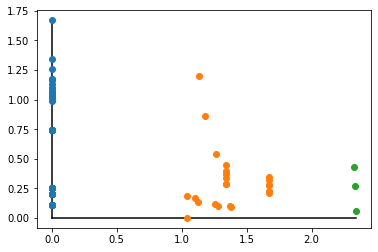

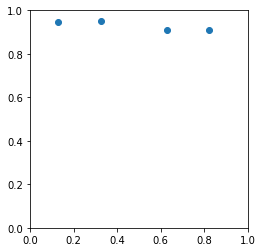

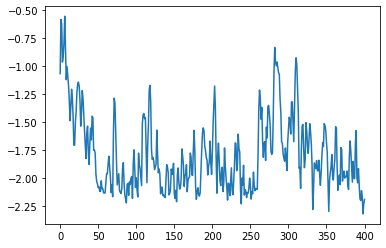


tensor(-2.2688, grad_fn=<SubBackward0>)

tensor(-2.0052, grad_fn=<SubBackward0>)

tensor(-2.0175, grad_fn=<SubBackward0>)

tensor(-2.1581, grad_fn=<SubBackward0>)

tensor(-1.9701, grad_fn=<SubBackward0>)

tensor(-1.9659, grad_fn=<SubBackward0>)

tensor(-1.9663, grad_fn=<SubBackward0>)

tensor(-1.6447, grad_fn=<SubBackward0>)

tensor(-1.5720, grad_fn=<SubBackward0>)

tensor(-1.5297, grad_fn=<SubBackward0>)

tensor(-1.5388, grad_fn=<SubBackward0>)

tensor(-1.5994, grad_fn=<SubBackward0>)

tensor(-1.6916, grad_fn=<SubBackward0>)

tensor(-1.7927, grad_fn=<SubBackward0>)

tensor(-1.6323, grad_fn=<SubBackward0>)

tensor(-1.7319, grad_fn=<SubBackward0>)

tensor(-1.8666, grad_fn=<SubBackward0>)

tensor(-1.6869, grad_fn=<SubBackward0>)

tensor(-1.6351, grad_fn=<SubBackward0>)

tensor(-1.6469, grad_fn=<SubBackward0>)

tensor(-1.7706, grad_fn=<SubBackward0>)

tensor(-1.7294, grad_fn=<SubBackward0>)

tensor(-1.6179, grad_fn=<SubBackward0>)

tensor(-1.5635, grad_fn=<SubBackward0>)

tensor(-1.6692,

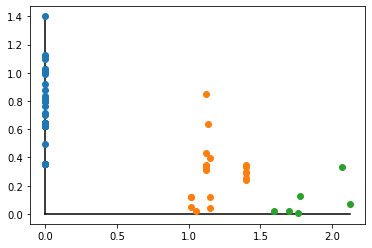

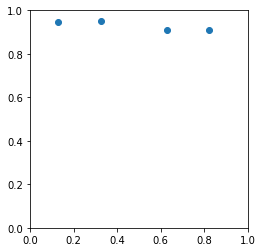

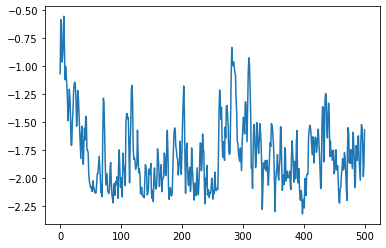


Training finished.


In [100]:
device = "cuda" if torch.cuda.is_available() else "cpu"
t0 = time.time()
model1 = OptimPhase(pos1,
                    ks_sqr,
                    non_negative = False,
                    N = 4,
                    maxdim = 2,
                    batch_size = 49,
                    epochs = 5,
                    train_steps = 100,
                    lr = 0.05,
                    init_phases = 'uniform',
                    bTranspose = False,
                    score = 'sum'
            )
print(time.time()-t0)
model1.train()

-1.067201018333435
-2.322075843811035


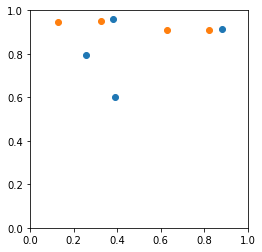

In [101]:
bestphase = np.argmin(model1.stats['loss'])
print(model1.stats['loss'][0])
print(model1.stats['loss'][bestphase])
p0 = model1.stats['phases'][0]%1
p1 = model1.stats['phases'][bestphase]%1

fig, ax = plt.subplots(1,1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(p0[:,0],p0[:,1])
ax.scatter(p1[:,0],p1[:,1])
ax.set_aspect('equal', 'box')
ax.set_aspect('equal', 'box')